In [ ]:
# Load necessary libraries efficiently
necessary_libraries <- c("scales", "ggplot2", "zoo", "corrplot", "dplyr", "Synth","SCtools")
installed_libraries <- rownames(installed.packages())
for (lib in necessary_libraries) {
  if (!(lib %in% installed_libraries)) install.packages(lib, quietly = TRUE)
  library(lib, character.only = TRUE, quietly = TRUE)
}

# Set options to avoid scientific notation
options(scipen = 999)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

corrplot 0.95 loaded


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘numDeriv’, ‘nloptr’, ‘pracma’, ‘kernlab’, ‘optimx’, ‘rgenoud’


##
## Synth Package: Implements Synthetic Control Methods.


## See https://web.stanford.edu/~jhain/synthpage.html for additional information.



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘DEoptimR’, ‘globals’, ‘listenv’, ‘parallelly’, ‘robus

# 2024

In [ ]:
# Loading the working file: 2024_recoded_rescaled.csv_rescaled.csv
df <- read.csv("/content/sample_data/2024_recoded_rescaled.csv_rescaled.csv")

## Main Model: Y = Wallet Value (Transformed Predictors)



X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 34.48346 

solution.v:
 0.3507145 0.003893283 0.01971714 0.06406632 0.001030215 0.1131409 0.2391886 0.09873222 0.1095168 

solution.w:
 0.2510573 0.0000002854 0.0000004886 0.0000003597 0.0000004008 0.0000003523 0.1087263 0.0000004108 0.000000423 0.0000003337 0.0000001609 0.062605 0.0000004345 0.0000005458 0.0000001614 0.0000004994 0.0000005187 0.0000002892 0.1541804 0.0000004755 0.0000003752 0.0000005281 0.423424 

$tab.pred
                                                         Treated Synthetic
mean_active_addresses_ratio_Active                         0.019     0.014
mean_addresses_by_holdings_in_usd_X_1_00____10_00_share   23.424    16.873
log_all_time_highers                                      13.631     9.512
log_all_time_lowers                                       10.321     7.911
mean_da

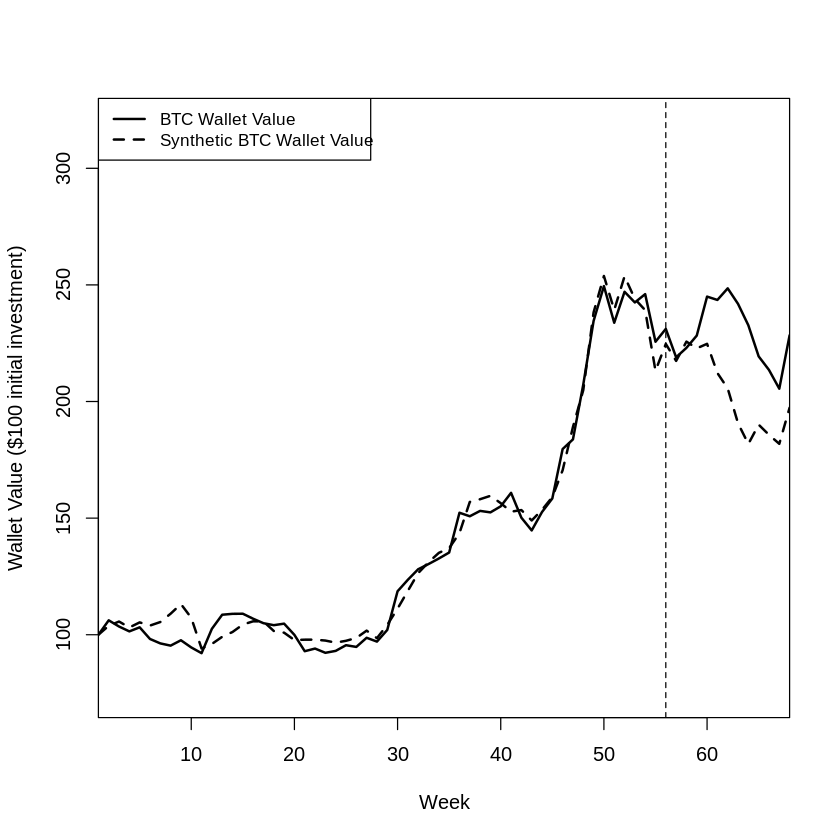

In [ ]:
# New list of predictors
predictors_list <- c(
  "mean_active_addresses_ratio_Active",
  "mean_addresses_by_holdings_in_usd_X_1_00____10_00_share",
  "log_all_time_highers",
  "log_all_time_lowers",
  "mean_daily_active_addresses_Zero_Balance_Addresses_share",
  "mean_balance_by_time_held_undefined_Hodlers__1Y___share",
  "mean_balance_by_time_held_undefined_Traders___1M__share",
  "mean_new_adoption_rate_New_Adoption_Rate",
  "mean_total_addresses_Total_Zero_Balance_share"
)

# Define the key dates
#start_date <- as.Date("2023-04-02")  # Week 1
#halving_date <- as.Date("2024-04-21")  # Week 56
#end_date <- as.Date("2024-07-21")  # Week 68

# Define the time periods
time_predictors_prior <- c(1:56)
time_optimize_ssr <- time_predictors_prior
time_plot <- c(1:68)

all_controls <- c(2:26) # define the list of all control units
excluded_units <- c(6, 14) # excluded due to NAs: DOGE, JET
controls_identifier <- setdiff(all_controls, excluded_units) # create the final list of control units by excluding the specified units

# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "wallet_value",  # Use the wallet value as the dependent variable
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 1,  # Set the treated unit identifier
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)

# Run synth
synth.out <- synth(dataprep.out)

# Get result tables and assess pre-treatment fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)

# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "Wallet Value ($100 initial investment)",
  Xlab = "Week",
  Legend = c("BTC Wallet Value", "Synthetic BTC Wallet Value"),
  Legend.position = "topleft"
)

abline(v   = 56,
       lty = 2)

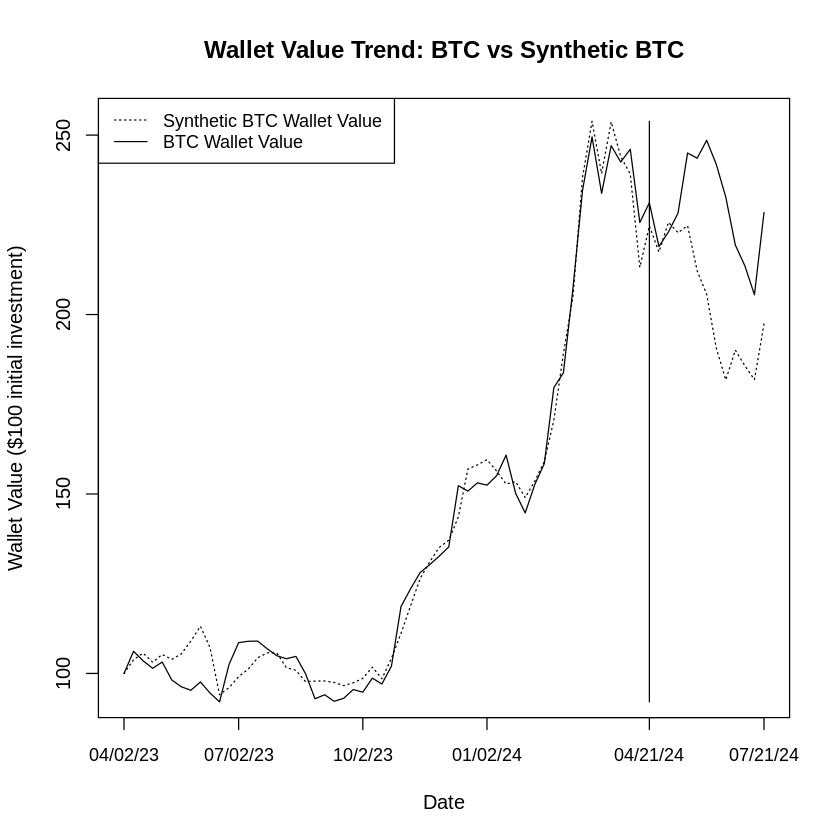

In [ ]:
# Extract the synthetic control and actual series
synth_2024_series <- dataprep.out$Y0plot %*% synth.out$solution.w
y1_2024_series <- dataprep.out$Y1plot

# Create a plot dataframe
halving_date <- 1:68
halving_plot <- data.frame(
  Date = halving_date,
  Synthetic = as.vector(synth_2024_series),
  Actual = as.vector(y1_2024_series)
)

# Plot results
plot(
  x = halving_date, y = halving_plot$Synthetic, type = "l", col = 'black', lty = 'dotted',
  ylab = "Wallet Value ($100 initial investment)", xlab = "Date", xaxt = 'n'
)
lines(x = halving_date, y = halving_plot$Actual, col = 'black')
title(main = "Wallet Value Trend: BTC vs Synthetic BTC")
#abline(v = c(56), col = c('black'))

# Use segments to draw vertical lines
y_limits <- range(c(halving_plot$Synthetic, halving_plot$Actual)) # Get y-axis limits
segments(x0 = 56, y0 = y_limits[1], x1 = 56, y1 = y_limits[2], col = 'black', lty = 1)

# Legend
legend(
  'topleft',
  legend = c("Synthetic BTC Wallet Value", "BTC Wallet Value"),
  lty = c("dotted", "solid"),
  col = c("black", "black"),
  ncol = 1,
  cex = 0.9       # Reduce legend text size
)

axis(
  side = 1, at = c(1, 13, 26, 39, 56, 68),
  labels = c("04/02/23", "07/02/23", "10/2/23", "01/02/24", "04/21/24","07/21/24"),
  cex.axis = 0.9, # Reduce font size of axis labels
  las = 1         # Rotate labels 90 degrees
)


## Gaps

,1
1,0.000000001646129
2,2.352658198465505
3,-2.134970927276854
4,-1.673871418605501
5,-2.116755911563814
6,-5.741081416535707
7,-9.161359576441768
8,-13.690474114297814
9,-15.528327281472002
10,-12.715141487252211


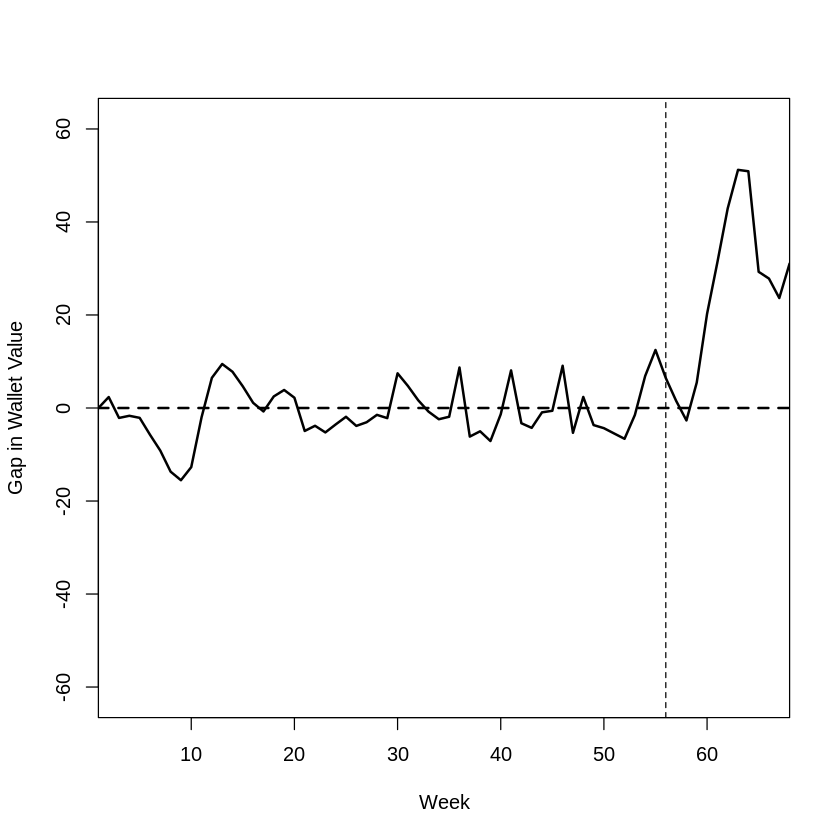

In [ ]:
# Main model: gaps plot
gaps.plot(synth.res    = synth.out,
          dataprep.res = dataprep.out,
          Ylab         = c("Gap in Wallet Value"),
          Xlab         = c("Week"),
          Main         = ""
)
abline(v   = 56,
       lty = 2)

gaps<- dataprep.out$Y1plot-(
        dataprep.out$Y0plot%*%synth.out$solution.w
        ) ; gaps

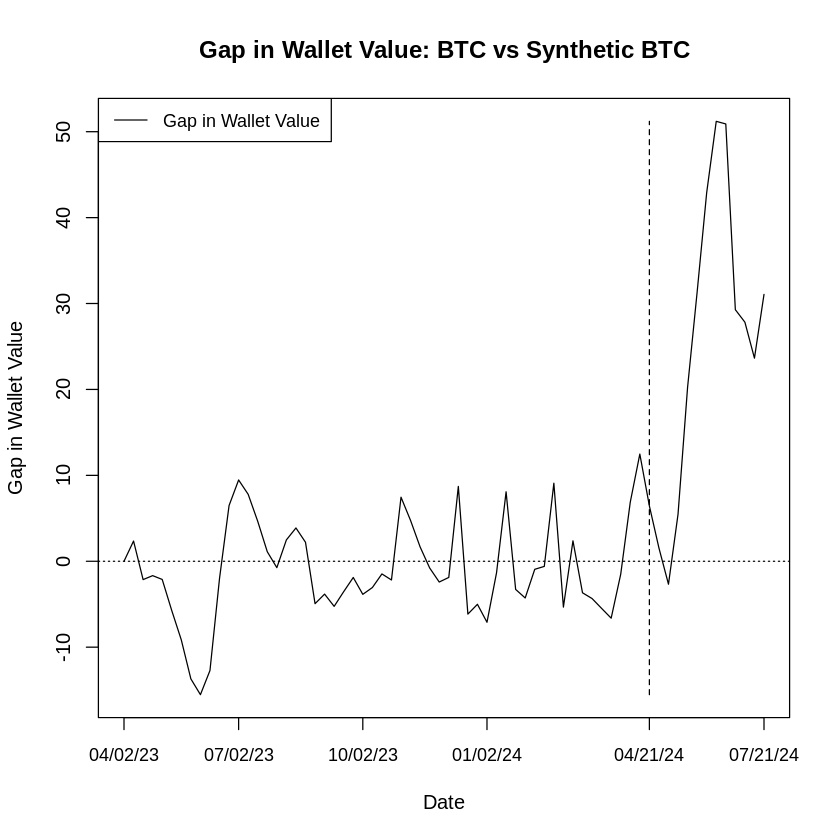

In [ ]:
# Create a plot dataframe
halving_date <- 1:68  # Week indices
halving_plot <- data.frame(
  Date = halving_date,
  Gap = as.vector(gaps[1:68])  # Restrict gaps to the desired range
)

# Plot the gaps
plot(
  x = halving_date, y = halving_plot$Gap, type = "l", col = 'black',
  ylab = "Gap in Wallet Value", xlab = "Date", xaxt = 'n',
  main = "Gap in Wallet Value: BTC vs Synthetic BTC"
)

# Add a vertical line at the treatment date (week 56)
y_limits <- range(halving_plot$Gap)  # Get y-axis limits
segments(x0 = 56, y0 = y_limits[1], x1 = 56, y1 = y_limits[2], col = 'black', lty = 2)

# Add a horizontal dotted line at y = 0
abline(h = 0, col = 'black', lty = 3)  # lty = 3 creates a dotted line

# Add a legend
legend(
  'topleft',
  legend = c("Gap in Wallet Value"),
  lty = "solid",
  col = "black",
  ncol = 1,
  cex = 0.9  # Reduce legend text size
)

# Customize the x-axis with date labels
axis(
  side = 1, at = c(1, 13, 26, 39, 56, 68),
  labels = c("04/02/23", "07/02/23", "10/02/23", "01/02/24", "04/21/24", "07/21/24"),
  cex.axis = 0.9,  # Reduce font size of axis labels
  las = 1          # Keep labels horizontal
)

## Placebo In Time: Late Nov 2023


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 26.39329 

solution.v:
 0.08846279 0.10819 0.2246061 0.05432487 0.001970281 0.3075623 0.1402698 0.03198176 0.04263202 

solution.w:
 0.1759706 0.0000000077 0.0000000329 0.0000000178 0.0000000355 0.2424961 0.0000000249 0.0000000547 0.000000018 0.0000000125 0.0000000071 0.0963381 0.000000008 0.0000000727 0.0000000013 0.0000001191 0.0000001675 0.0000000222 0.0000000034 0.0000000447 0.0000000151 0.0000000121 0.4851945 

$tab.pred
                                                         Treated Synthetic
mean_active_addresses_ratio_Active                         0.020     0.014
mean_addresses_by_holdings_in_usd_X_1_00____10_00_share   24.115    19.630
log_all_time_highers                                      13.451    12.060
log_all_time_lowers                                       10.322     9.147
mean_d

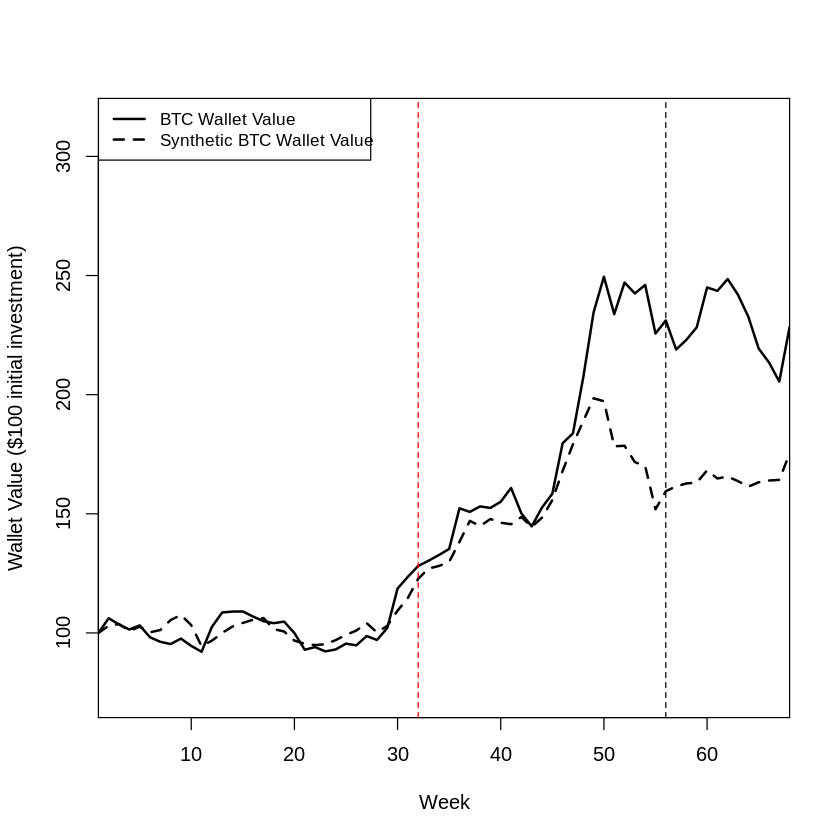

In [ ]:
# Define the time periods
time_predictors_prior <- c(1:32)
time_optimize_ssr <- time_predictors_prior
time_plot <- c(1:68)

all_controls <- c(2:26) # define the list of all control units
excluded_units <- c(6, 14) # excluded due to NAs: DOGE, JET
controls_identifier <- setdiff(all_controls, excluded_units) # create the final list of control units by excluding the specified units

# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "wallet_value",  # Use the wallet value as the dependent variable
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 1,  # Set the treated unit identifier
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)
# Run synth
synth.out <- synth(dataprep.out)

# Get result tables and assess pre-treatment fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)

# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "Wallet Value ($100 initial investment)",
  Xlab = "Week",
  Legend = c("BTC Wallet Value", "Synthetic BTC Wallet Value"),
  Legend.position = "topleft"
)

abline(v   = 32,
       lty = 2, col="red")

abline(v   = 56,
       lty = 2)

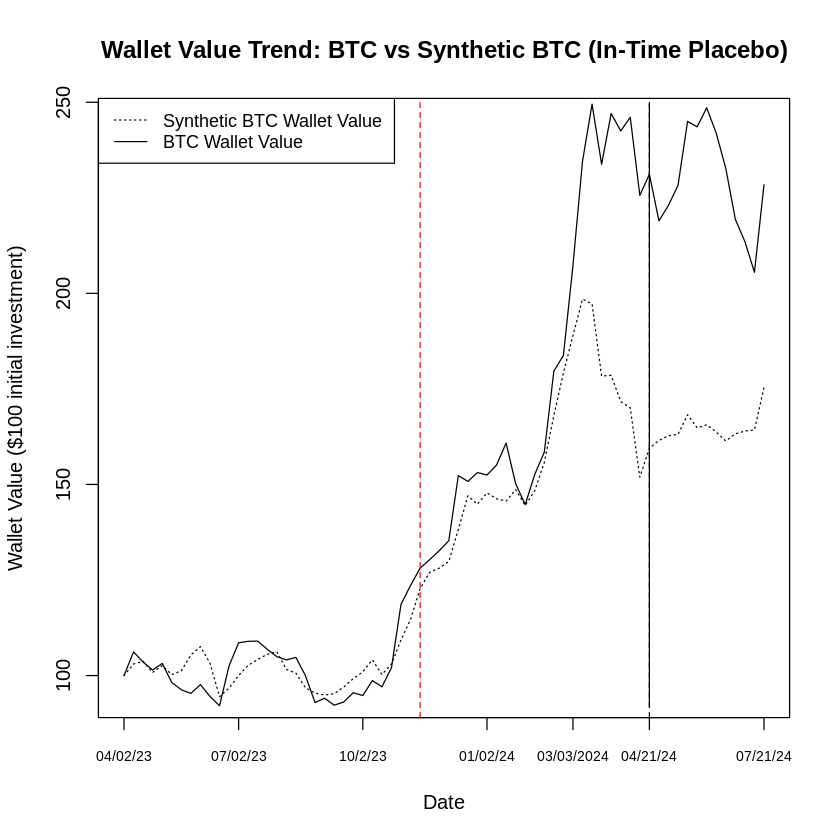

In [ ]:
# Extract the synthetic control and actual series
synth_2024_time_placebo_series <- dataprep.out$Y0plot %*% synth.out$solution.w
y1_2024_time_placebo_series <- dataprep.out$Y1plot

# Create a plot dataframe
halving_date <- 1:68
halving_plot <- data.frame(
  Date = halving_date,
  Synthetic = as.vector(synth_2024_time_placebo_series),
  Actual = as.vector(y1_2024_time_placebo_series)
)

# Plot results
plot(
  x = halving_date, y = halving_plot$Synthetic, type = "l", col = 'black', lty = 'dotted',
  ylab = "Wallet Value ($100 initial investment)", xlab = "Date", xaxt = 'n',ylim=c(95,245)
)
lines(x = halving_date, y = halving_plot$Actual, col = 'black')
title(main = "Wallet Value Trend: BTC vs Synthetic BTC (In-Time Placebo)")
#abline(v = c(56), col = c('black'))

# Use segments to draw vertical lines
y_limits <- range(c(halving_plot$Synthetic, halving_plot$Actual)) # Get y-axis limits
segments(x0 = 56, y0 = y_limits[1], x1 = 56, y1 = y_limits[2], col = 'black', lty = 1)

# Lines
abline(v   = 32,
       lty = 2, col="red")

abline(v   = 56,
       lty = 2)

# Legend
legend(
  'topleft',
  legend = c("Synthetic BTC Wallet Value", "BTC Wallet Value"),
  lty = c("dotted", "solid"),
  col = c("black", "black"),
  ncol = 1,
  cex = 0.9       # Reduce legend text size
)

axis(
  side = 1, at = c(1, 13, 26, 39, 48, 56, 68),
  labels = c("04/02/23", "07/02/23", "10/2/23", "01/02/24", "03/03/2024", "04/21/24","07/21/24"),
  cex.axis = 0.7, # Reduce font size of axis labels
  las = 1         # Rotate labels 90 degrees
)


## In-Space Placebo (Unit): ANKR


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 143.6922 

solution.v:
 0.08792979 0.1934168 0.3022613 0.01931676 0.0000931815 0.04077926 0.003612808 0.3501035 0.00248659 

solution.w:
 0.0000001471 0.09783241 0.03990525 0.0000038799 0.1783432 0.000010935 0.0000010582 0.4516515 0.00001157 0.0000102466 0.000032856 0.0000000194 0.0000085896 0.0000078734 0.000137749 0.0000023744 0.0000000072 0.0000977266 0.0000018377 0.0000000846 0.0000002602 0.2319108 0.0000295935 

$tab.pred
                                                         Treated Synthetic
mean_active_addresses_ratio_Active                         0.005     0.005
mean_addresses_by_holdings_in_usd_X_1_00____10_00_share   13.027    13.167
log_all_time_highers                                       7.204     7.292
log_all_time_lowers                                        7.656     7.217
mean_

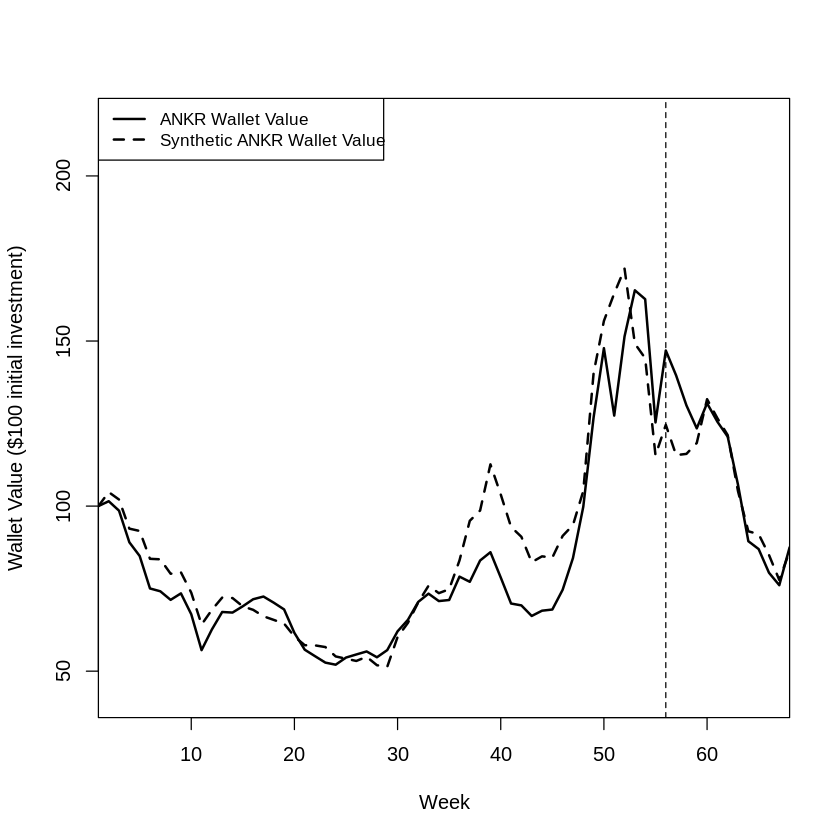

In [ ]:
# Define the time periods
time_predictors_prior <- c(1:56)
time_optimize_ssr <- time_predictors_prior
time_plot <- c(1:68)

all_controls <- c(1:26) # define the list of all control units
excluded_units <- c(6, 14, 4) # excluded due to NAs: DOGE, JET // For placebo: ANKR
controls_identifier <- setdiff(all_controls, excluded_units) # create the final list of control units by excluding the specified units

# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "wallet_value",  # Use the wallet value as the dependent variable
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 4,  # Treated unit identifier: 4 (ANKR)
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)
# Run synth
synth.out <- synth(dataprep.out)

# Get result tables and assess pre-treatment fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)

# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "Wallet Value ($100 initial investment)",
  Xlab = "Week",
  Legend = c("ANKR Wallet Value", "Synthetic ANKR Wallet Value"),
  Legend.position = "topleft"
)

abline(v   = 56,
       lty = 2)

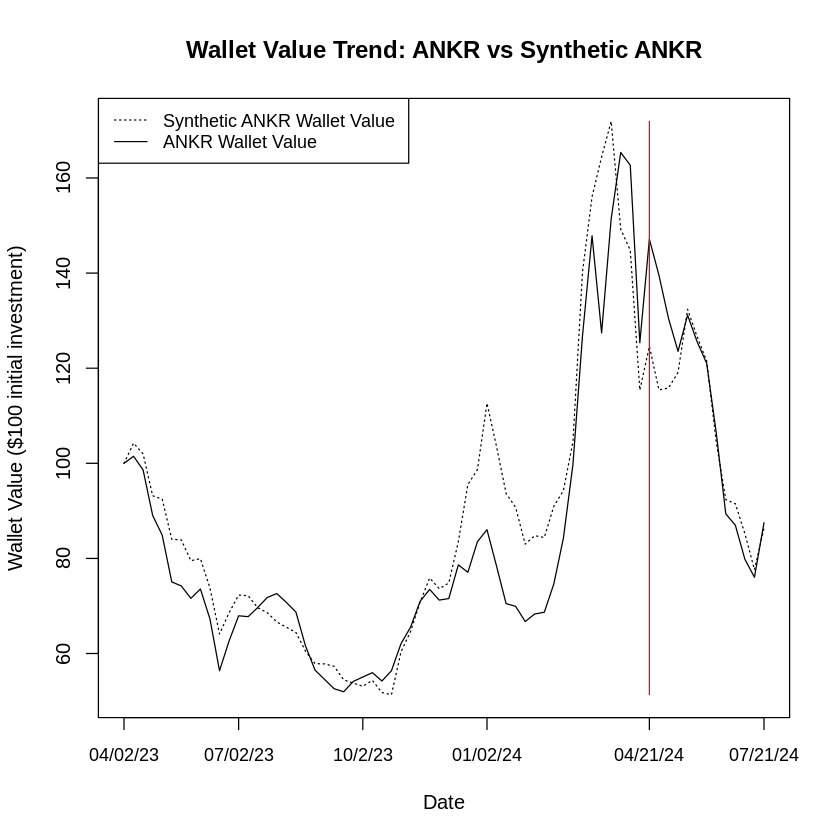

In [ ]:
# Extract the synthetic control and actual series
synth_2024_unit_placebo_series <- dataprep.out$Y0plot %*% synth.out$solution.w
y1_2024_unit_placebo_series <- dataprep.out$Y1plot

# Create a plot dataframe
halving_date <- 1:68
halving_plot <- data.frame(
  Date = halving_date,
  Synthetic = as.vector(synth_2024_unit_placebo_series),
  Actual = as.vector(y1_2024_unit_placebo_series)
)

# Plot results
plot(
  x = halving_date, y = halving_plot$Synthetic, type = "l", col = 'black', lty = 'dotted',
  ylab = "Wallet Value ($100 initial investment)", xlab = "Date", xaxt = 'n'
)
lines(x = halving_date, y = halving_plot$Actual, col = 'black')
title(main = "Wallet Value Trend: ANKR vs Synthetic ANKR")
#abline(v = c(56), col = c('black'))

# Use segments to draw vertical lines
y_limits <- range(c(halving_plot$Synthetic, halving_plot$Actual)) # Get y-axis limits
segments(x0 = 56, y0 = y_limits[1], x1 = 56, y1 = y_limits[2], col = 'red', lty = 1)

# Legend
legend(
  'topleft',
  legend = c("Synthetic ANKR Wallet Value", "ANKR Wallet Value"),
  lty = c("dotted", "solid"),
  col = c("black", "black"),
  ncol = 1,
  cex = 0.9       # Reduce legend text size
)

axis(
  side = 1, at = c(1, 13, 26, 39, 56, 68),
  labels = c("04/02/23", "07/02/23", "10/2/23", "01/02/24", "04/21/24","07/21/24"),
  cex.axis = 0.9, # Reduce font size of axis labels
  las = 1         # Rotate labels 90 degrees
)


## Spaghetti

> **NB!** Run the main model cell before



 

**************** 
**************** 
**************** 

MSPE (LOSS V): 126.0439 

solution.v:
 0.0000292911 0.1323939 0.2608735 0.04379749 0.08432292 0.07144399 0.003702381 0.06673153 0.3367051 

solution.w:
 0.0000145969 0.0004454252 0.0000617438 0.208948 0.1904318 0.000090123 0.0000882137 0.0002836645 0.0001465288 0.0000424224 0.0001482575 0.0002298425 0.2858164 0.0000330274 0.0001191524 0.3028897 0.003143262 0.006772662 0.0000787699 0.0000409025 0.0000902441 0.0000853251 


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 371.2695 

solution.v:
 0.1858537 0.05596787 0.001510661 0.02077335 0.08018696 0.1128241 0.09765976 0.4452227 0.0000008794 

solution.w:
 -0.0000000186 0.9674494 0.0007023014 0.0000673783 0.0005580369 0.0000059272 0.00000098 0.0002415471 0.0003773663 0.02099683 0.000164689 0.0002390725 0.0005917375 0.00637431 0.0001700551 0.00

New names:
• `w.weight` -> `w.weight...1`
• `w.weight` -> `w.weight...2`
• `w.weight` -> `w.weight...3`
• `w.weight` -> `w.weight...4`
• `w.weight` -> `w.weight...5`
• `w.weight` -> `w.weight...6`
• `w.weight` -> `w.weight...7`
• `w.weight` -> `w.weight...8`
• `w.weight` -> `w.weight...9`
• `w.weight` -> `w.weight...10`
• `w.weight` -> `w.weight...11`
• `w.weight` -> `w.weight...12`
• `w.weight` -> `w.weight...13`
• `w.weight` -> `w.weight...14`
• `w.weight` -> `w.weight...15`
• `w.weight` -> `w.weight...16`
• `w.weight` -> `w.weight...17`
• `w.weight` -> `w.weight...18`
• `w.weight` -> `w.weight...19`
• `w.weight` -> `w.weight...20`
• `w.weight` -> `w.weight...21`
• `w.weight` -> `w.weight...22`
• `w.weight` -> `w.weight...23`
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


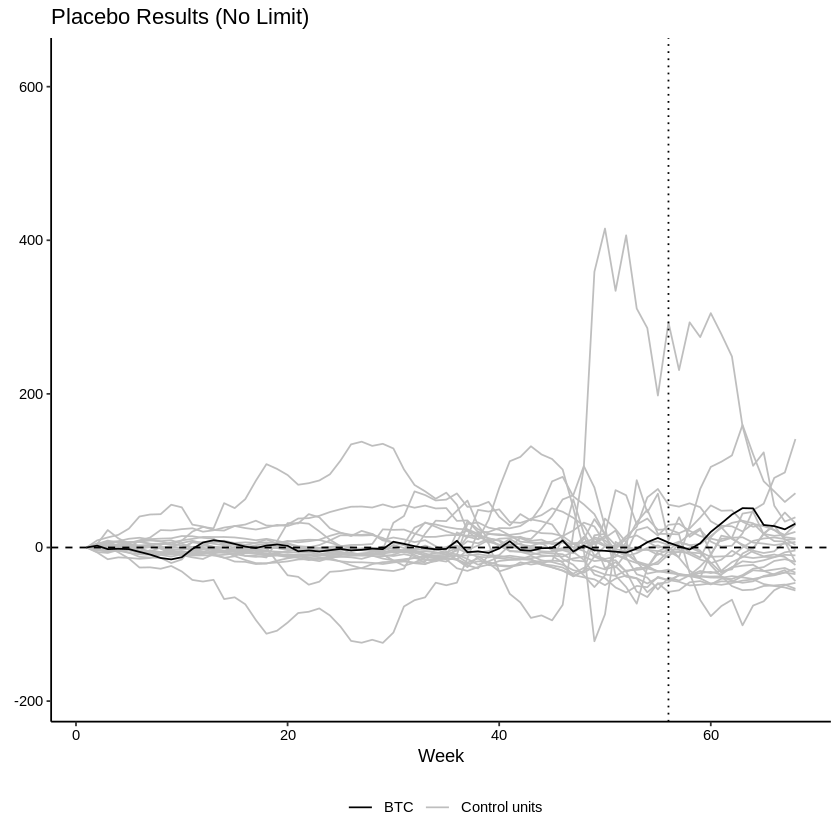

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


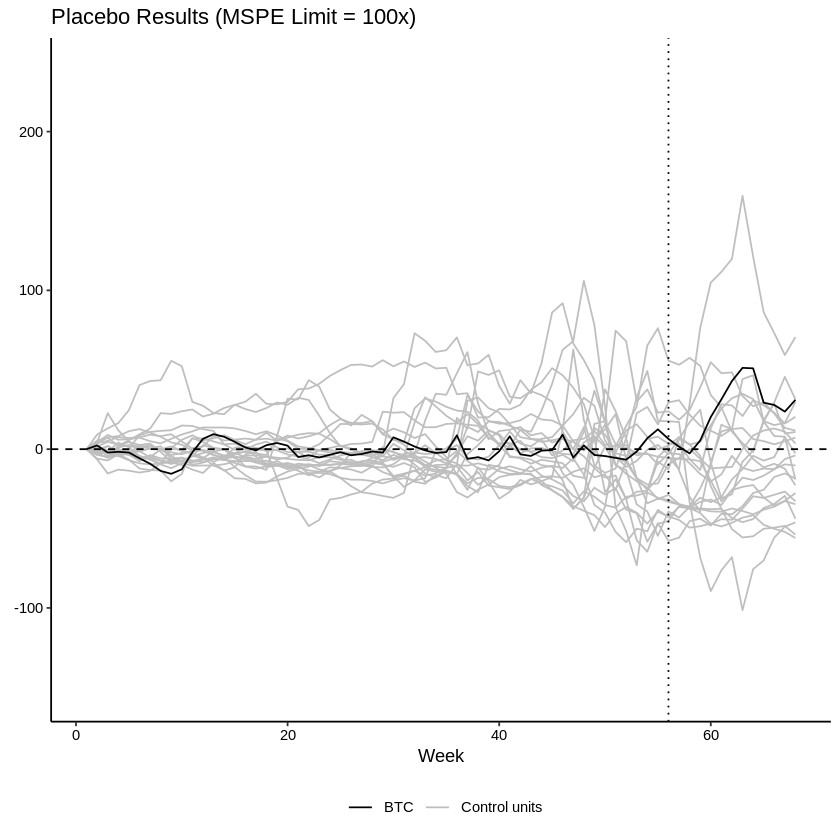

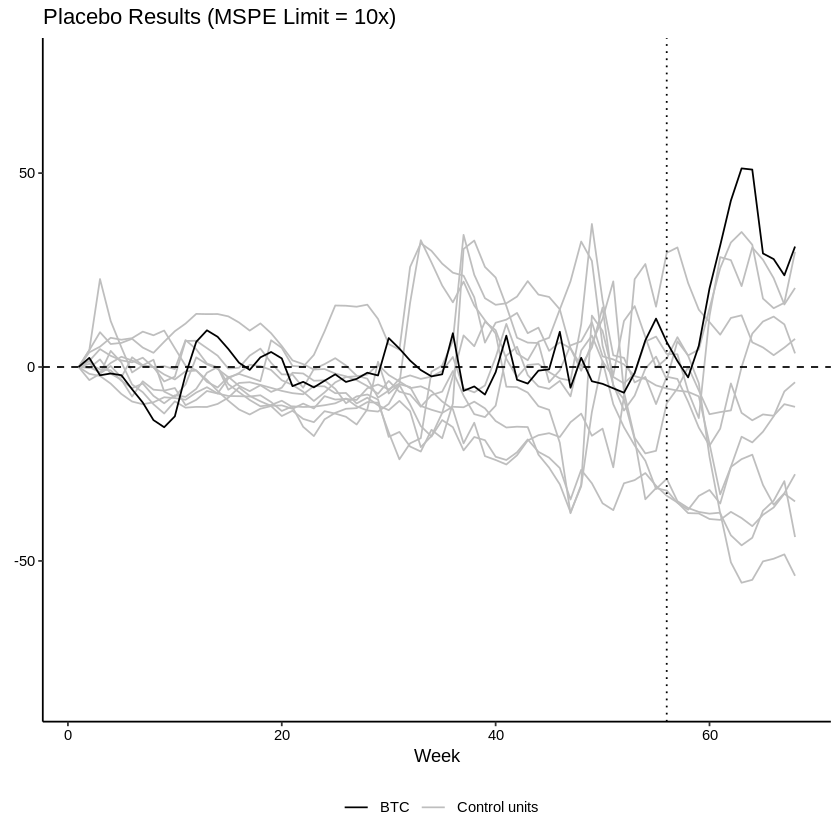

In [ ]:
# Generate and plot placebos using the multicore strategy
placebo <- generate.placebos(dataprep.out, synth.out, Sigf.ipop = 2, strategy = 'multicore')

p  <- plot_placebos(placebo, discard.extreme = FALSE, xlab = 'Week') +
  ggtitle("Placebo Results (No Limit)")
p1 <- plot_placebos(placebo, discard.extreme = TRUE, mspe.limit = 100, xlab = 'Week') +
  ggtitle("Placebo Results (MSPE Limit = 100x)")
p2 <- plot_placebos(placebo, discard.extreme = TRUE, mspe.limit = 10, xlab = 'Week') +
  ggtitle("Placebo Results (MSPE Limit = 10x)")

p  + scale_color_manual(name = "", values = c("black", "grey"),
                              labels = c("BTC", "Control units"))
p1 + scale_color_manual(name = "", values = c("black", "grey"),
                              labels = c("BTC", "Control units"))
p2 + scale_color_manual(name = "", values = c("black", "grey"),
                              labels = c("BTC", "Control units"))

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


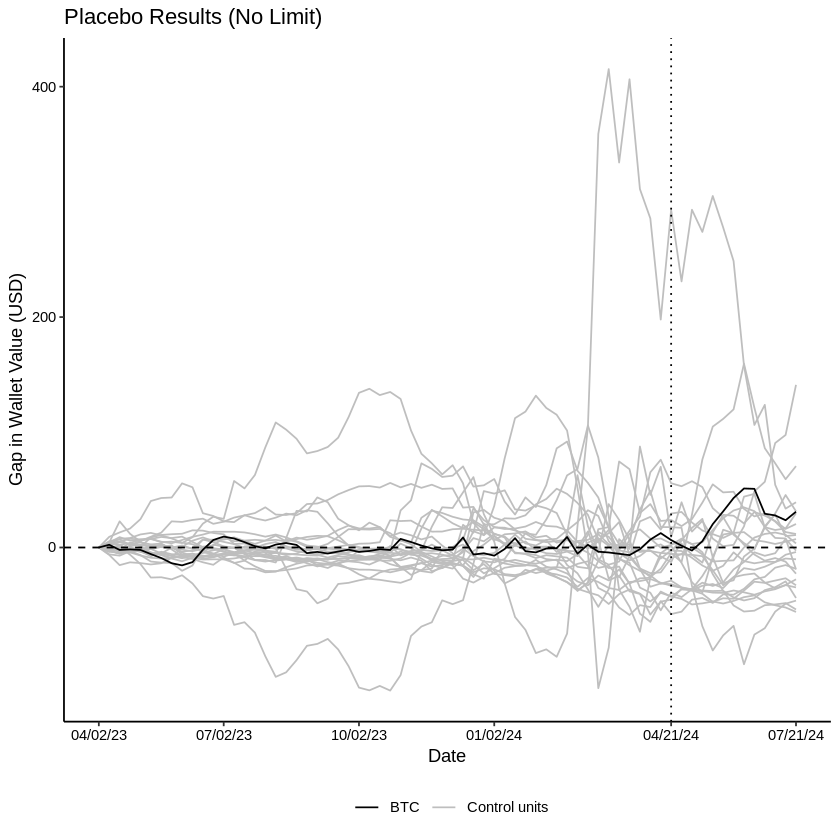

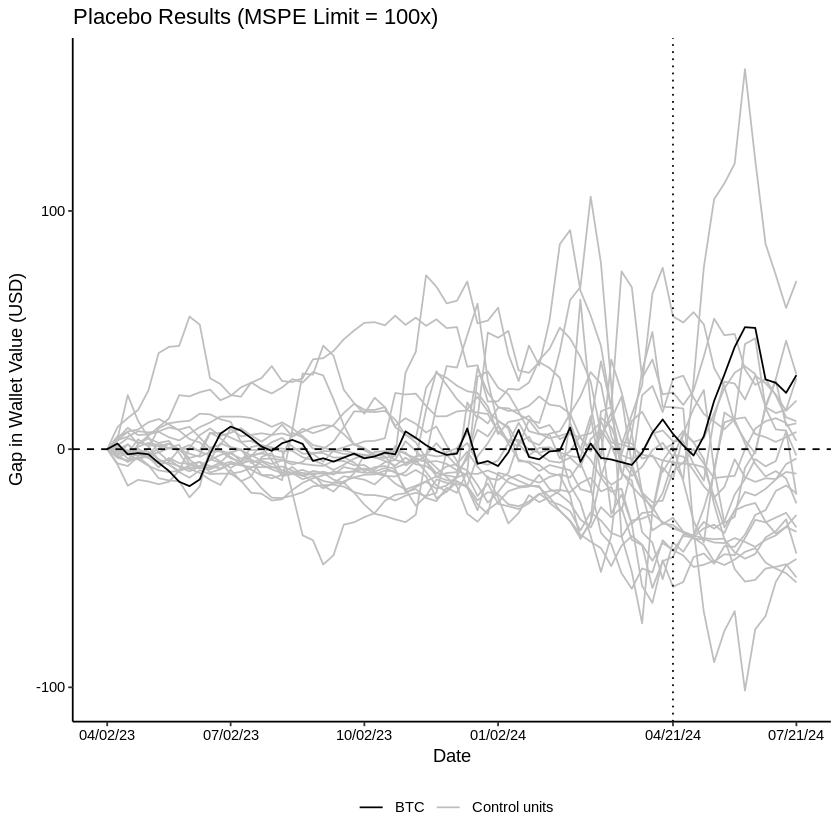

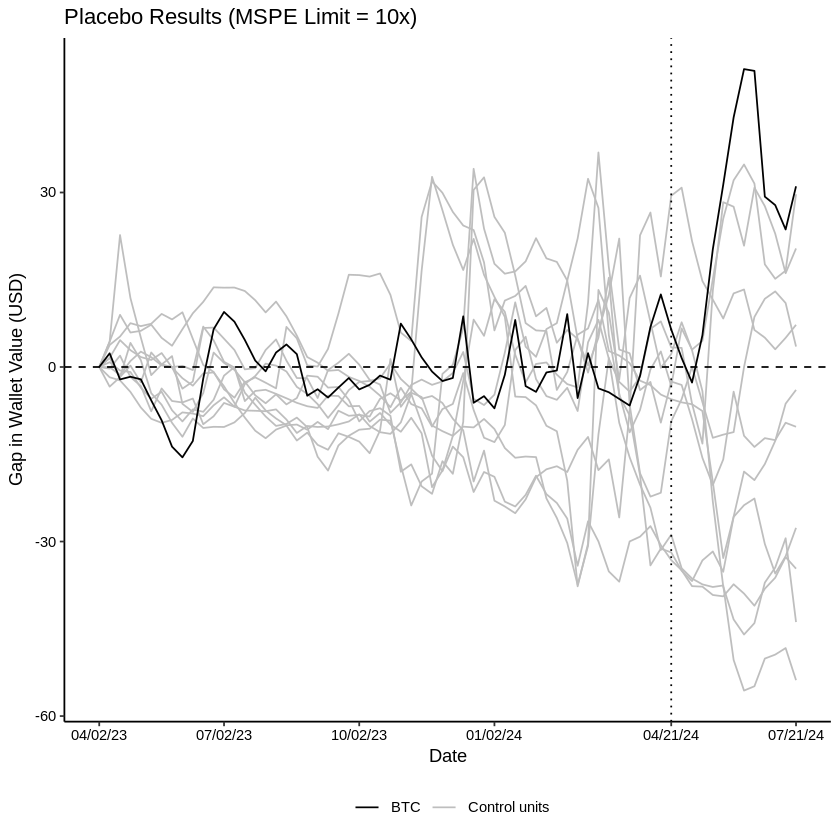

In [ ]:
# Define the custom x-axis breaks and labels (week indices to dates)
custom_breaks <- c(1, 13, 26, 39, 56, 68)
custom_labels <- c("04/02/23", "07/02/23", "10/02/23", "01/02/24", "04/21/24", "07/21/24")

# Update each plot by adding scale_x_continuous()
p_date  <- p +
  scale_color_manual(name = "", values = c("black", "grey"),
                     labels = c("BTC", "Control units")) +
  scale_x_continuous("Date", breaks = custom_breaks, labels = custom_labels)  +
  scale_y_continuous("Gap in Wallet Value (USD)")

p1_date <- p1 +
  scale_color_manual(name = "", values = c("black", "grey"),
                     labels = c("BTC", "Control units")) +
  scale_x_continuous("Date", breaks = custom_breaks, labels = custom_labels) +
  scale_y_continuous("Gap in Wallet Value (USD)")

p2_date <- p2 +
  scale_color_manual(name = "", values = c("black", "grey"),
                     labels = c("BTC", "Control units")) +
  scale_x_continuous("Date", breaks = custom_breaks, labels = custom_labels) +
  scale_y_continuous("Gap in Wallet Value (USD)")

# Print the plots
p_date
p1_date
p2_date

## MSPE

[1] "Placebo in-space p-value: 0.0416666666666667"
   MSPE.ratios  unit
1    2.2885530   ADA
2    3.6642735  ALGO
3    1.1717622  ANKR
4    6.5896362   CRO
5   10.6100530   ENJ
6    8.3621670   ETH
7    2.0736844   FET
8    2.8610958   FTM
9    0.6562403   GNO
10   1.7806268   HOT
11   7.7572959  IOTX
12   0.4659936   KCS
13   1.2351005   LEO
14   0.3092751  LINK
15  22.1119253   LPT
16   4.4300053  MANA
17   3.7614778 MATIC
18   0.6172121   MKR
19   1.2601888    MX
20   7.9097222  NEXO
21   4.6865685   OKB
22   5.6196485   QNT
23   0.4993348   TRX
24  28.1315080   BTC


Warning message:
“NAs introduced by coercion”
Warning message:
“Removed 24 rows containing non-finite outside the scale range (`stat_bin()`).”


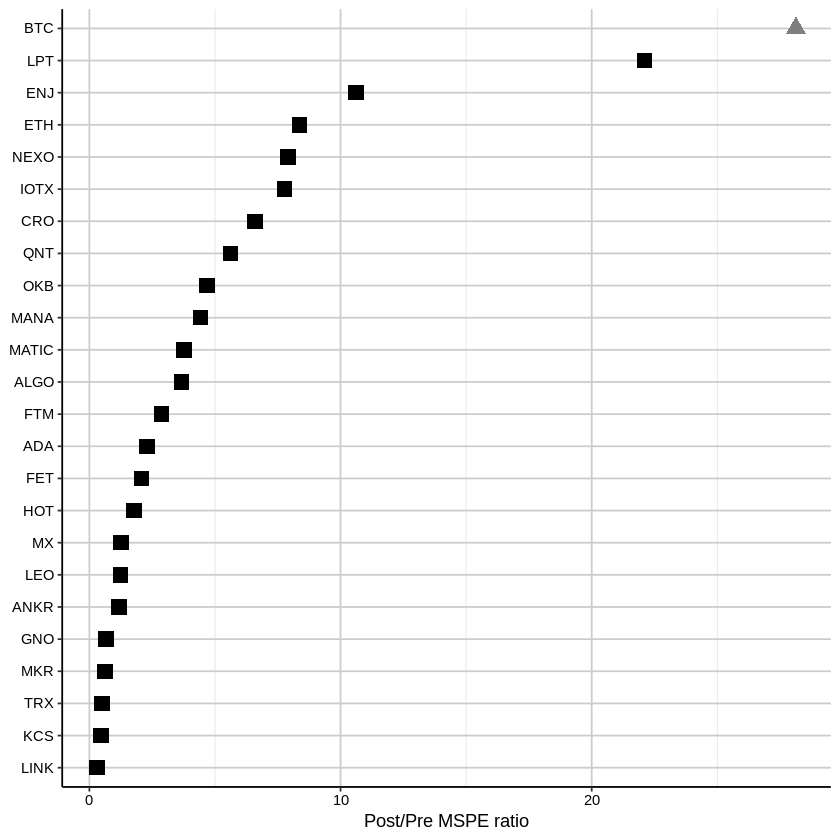

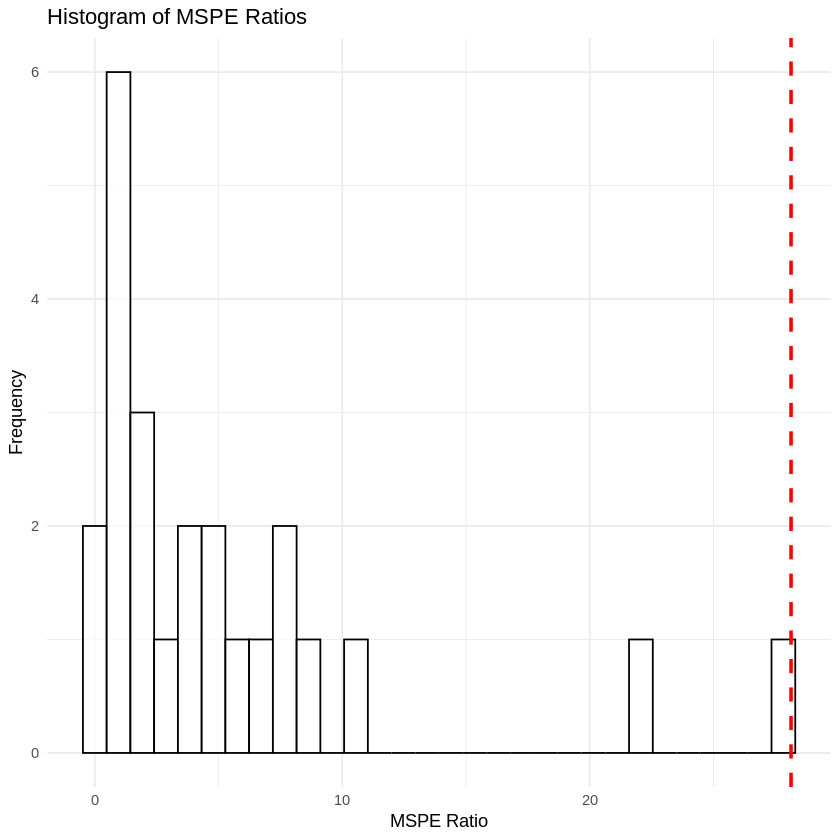

In [ ]:
# Compute and print MSPE ratio and p-value
ratio   <- mspe.test(placebo)
p_value <- ratio$p.val
print(paste("Placebo in-space p-value:", p_value))
print(ratio$test)

# Scatter Plot
mspe_plot(placebo)

# Extract and convert MSPE ratios to numeric
mspe_values <- as.numeric(as.character(unlist(ratio$test)))
mspe_data   <- data.frame(MSPE_Ratio = mspe_values)

# Assume BTC's MSPE is at index 24
btc_mspe <- mspe_values[24]

# Plot histogram with BTC's MSPE highlighted
ggplot(mspe_data, aes(x = MSPE_Ratio)) +
  geom_histogram(bins = 30, fill = "white", color = "black", alpha = 0.7) +
  geom_vline(xintercept = btc_mspe, color = "red", linetype = "dashed", size = 1) +
  annotate("text", x = btc_mspe, y = Inf, label = "BTC",
           vjust = -0.5, color = "red") +
  labs(title = "Histogram of MSPE Ratios",
       x = "MSPE Ratio", y = "Frequency") +
  theme_minimal()

## Pre-treatment MSPE Comparison

### MSPE limit = 10

Pre-Treatment MSPE for Bitcoin: 34.48346 

Comparison of donor MSPEs relative to Bitcoin:
                     Crypto Pre_Treatment_MSPE Relative_to_BTC
unlist(mspe.placs)1     ADA          126.04385        3.655198
unlist(mspe.placs)2    ALGO          371.26948       10.766597
unlist(mspe.placs)3    ANKR          165.78467        4.807658
unlist(mspe.placs)4     CRO          168.56232        4.888208
unlist(mspe.placs)5     ENJ          200.91422        5.826395
unlist(mspe.placs)6     ETH           52.89282        1.533861
unlist(mspe.placs)7     FET        20237.88102      586.886691
unlist(mspe.placs)8     FTM          397.01457       11.513190
unlist(mspe.placs)9     GNO         1000.52422       29.014616
unlist(mspe.placs)10    HOT           86.53883        2.509575
unlist(mspe.placs)11   IOTX          569.82871       16.524699
unlist(mspe.placs)12    KCS          176.95771        5.131670
unlist(mspe.placs)13    LEO          419.73607       12.172100
unlist(mspe.placs)14   LINK 

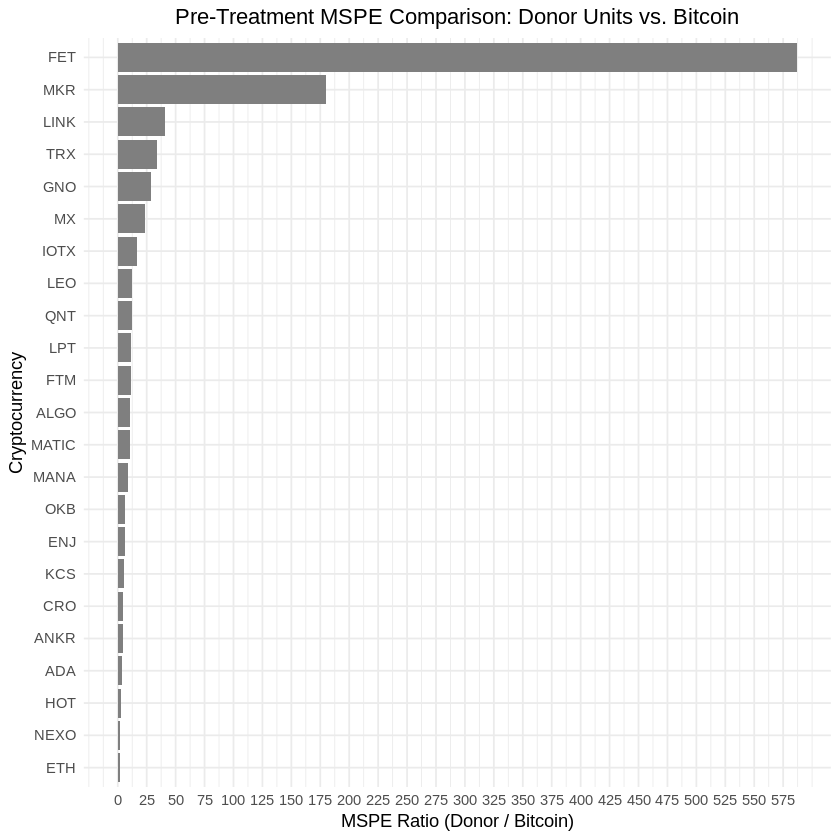

In [ ]:
# Extract Bitcoin's observed and synthetic values for the pre-treatment period
observed_btc <- dataprep.out$Y1plot[which(dataprep.out$tag$time.plot %in% time_predictors_prior)]
synthetic_btc <- (dataprep.out$Y0plot %*% synth.out$solution.w)[which(dataprep.out$tag$time.plot %in% time_predictors_prior)]

# Compute pre-treatment MSPE for Bitcoin
mspe_btc <- mean((observed_btc - synthetic_btc)^2, na.rm = TRUE)

# Extract donor MSPEs
donor_mspe <- unlist(placebo$mspe.placs)

# Extract donor cryptocurrency names
donor_cryptos <- dataprep.out$tag$controls.identifier  # Unit numbers of donor cryptocurrencies
donor_crypto_names <- dataprep.out$names.and.numbers$unit.names[
  match(donor_cryptos, dataprep.out$names.and.numbers$unit.numbers)
]

# Compute how much larger each donor unit's MSPE is relative to Bitcoin's
mspe_comparison <- data.frame(
  Crypto = donor_crypto_names,
  Pre_Treatment_MSPE = donor_mspe,
  Relative_to_BTC = donor_mspe / mspe_btc  # Compute ratio
)

# Print results
cat("Pre-Treatment MSPE for Bitcoin:", mspe_btc, "\n\n")
cat("Comparison of donor MSPEs relative to Bitcoin:\n")
print(mspe_comparison)

# Plot the comparison
ggplot(mspe_comparison, aes(x = reorder(Crypto, Relative_to_BTC), y = Relative_to_BTC)) +
  geom_bar(stat = "identity", fill = "grey50") +
  coord_flip() +
  labs(title = "Pre-Treatment MSPE Comparison: Donor Units vs. Bitcoin",
       x = "Cryptocurrency",
       y = "MSPE Ratio (Donor / Bitcoin)") +
  scale_y_continuous(breaks = seq(0, max(mspe_comparison$Relative_to_BTC), by = 25)) +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5))

# Print cryptocurrencies and count of cryptocurrencies above and below an MSPE limit
# Define threshold value
mspe_limit <- 10

# Filter cryptocurrencies based on the threshold
above_limit <- mspe_comparison %>% filter(Relative_to_BTC > mspe_limit)
below_limit <- mspe_comparison %>% filter(Relative_to_BTC <= mspe_limit)

# Count the number of cryptocurrencies in each category
count_above <- nrow(above_limit)
count_below <- nrow(below_limit)

# Print results
cat("\nCryptocurrencies with Relative_to_BTC ABOVE", mspe_limit, "(", count_above, "cryptocurrencies ):\n")
print(above_limit)

cat("\nCryptocurrencies with Relative_to_BTC BELOW or EQUAL to", mspe_limit, "(", count_below, "cryptocurrencies ):\n")
print(below_limit)

### MSPE limit = 100

Pre-Treatment MSPE for Bitcoin: 34.48346 

Comparison of donor MSPEs relative to Bitcoin:
                     Crypto Pre_Treatment_MSPE Relative_to_BTC
unlist(mspe.placs)1     ADA          126.04385        3.655198
unlist(mspe.placs)2    ALGO          371.26948       10.766597
unlist(mspe.placs)3    ANKR          165.78467        4.807658
unlist(mspe.placs)4     CRO          168.56232        4.888208
unlist(mspe.placs)5     ENJ          200.91422        5.826395
unlist(mspe.placs)6     ETH           52.89282        1.533861
unlist(mspe.placs)7     FET        20237.88102      586.886691
unlist(mspe.placs)8     FTM          397.01457       11.513190
unlist(mspe.placs)9     GNO         1000.52422       29.014616
unlist(mspe.placs)10    HOT           86.53883        2.509575
unlist(mspe.placs)11   IOTX          569.82871       16.524699
unlist(mspe.placs)12    KCS          176.95771        5.131670
unlist(mspe.placs)13    LEO          419.73607       12.172100
unlist(mspe.placs)14   LINK 

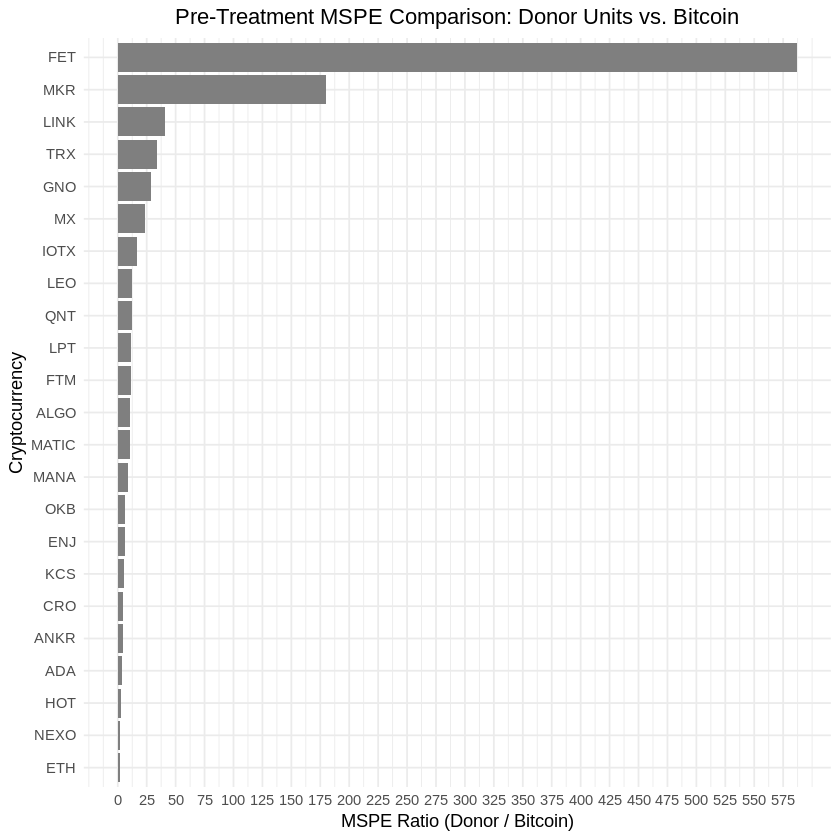

In [ ]:
# Extract Bitcoin's observed and synthetic values for the pre-treatment period
observed_btc <- dataprep.out$Y1plot[which(dataprep.out$tag$time.plot %in% time_predictors_prior)]
synthetic_btc <- (dataprep.out$Y0plot %*% synth.out$solution.w)[which(dataprep.out$tag$time.plot %in% time_predictors_prior)]

# Compute pre-treatment MSPE for Bitcoin
mspe_btc <- mean((observed_btc - synthetic_btc)^2, na.rm = TRUE)

# Extract donor MSPEs
donor_mspe <- unlist(placebo$mspe.placs)

# Extract donor cryptocurrency names
donor_cryptos <- dataprep.out$tag$controls.identifier  # Unit numbers of donor cryptocurrencies
donor_crypto_names <- dataprep.out$names.and.numbers$unit.names[
  match(donor_cryptos, dataprep.out$names.and.numbers$unit.numbers)
]

# Compute how much larger each donor unit's MSPE is relative to Bitcoin's
mspe_comparison <- data.frame(
  Crypto = donor_crypto_names,
  Pre_Treatment_MSPE = donor_mspe,
  Relative_to_BTC = donor_mspe / mspe_btc  # Compute ratio
)

# Print results
cat("Pre-Treatment MSPE for Bitcoin:", mspe_btc, "\n\n")
cat("Comparison of donor MSPEs relative to Bitcoin:\n")
print(mspe_comparison)

# Plot the comparison
ggplot(mspe_comparison, aes(x = reorder(Crypto, Relative_to_BTC), y = Relative_to_BTC)) +
  geom_bar(stat = "identity", fill = "grey50") +
  coord_flip() +
  labs(title = "Pre-Treatment MSPE Comparison: Donor Units vs. Bitcoin",
       x = "Cryptocurrency",
       y = "MSPE Ratio (Donor / Bitcoin)") +
  scale_y_continuous(breaks = seq(0, max(mspe_comparison$Relative_to_BTC), by = 25)) +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5))

# Print cryptocurrencies and count of cryptocurrencies above and below an MSPE limit
# Define threshold value
mspe_limit <- 100

# Filter cryptocurrencies based on the threshold
above_limit <- mspe_comparison %>% filter(Relative_to_BTC > mspe_limit)
below_limit <- mspe_comparison %>% filter(Relative_to_BTC <= mspe_limit)

# Count the number of cryptocurrencies in each category
count_above <- nrow(above_limit)
count_below <- nrow(below_limit)

# Print results
cat("\nCryptocurrencies with Relative_to_BTC ABOVE", mspe_limit, "(", count_above, "cryptocurrencies ):\n")
print(above_limit)

cat("\nCryptocurrencies with Relative_to_BTC BELOW or EQUAL to", mspe_limit, "(", count_below, "cryptocurrencies ):\n")
print(below_limit)

## Leave-One-Out

> **NB!** Run the main model cell before


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 554.6688 

solution.v:
 0.06444912 0.001993593 0.00665327 0.01965722 0.1507744 0.1867614 0.1925968 0.06690323 0.310211 

solution.w:
 0.4236338 0.0000000303 0.0000013088 0.5763648 

Excluded: TRX, Mean Gap (56-68): 53.8047

X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 32.91121 

solution.v:
 0.09868437 0.03768801 0.1736729 0.1249563 0.1508706 0.1433431 0.1274594 0.04275352 0.1005718 

solution.w:
 0.1136411 0.2592738 0.1414433 0.4856418 

Excluded: ADA, Mean Gap (56-68): 18.1991


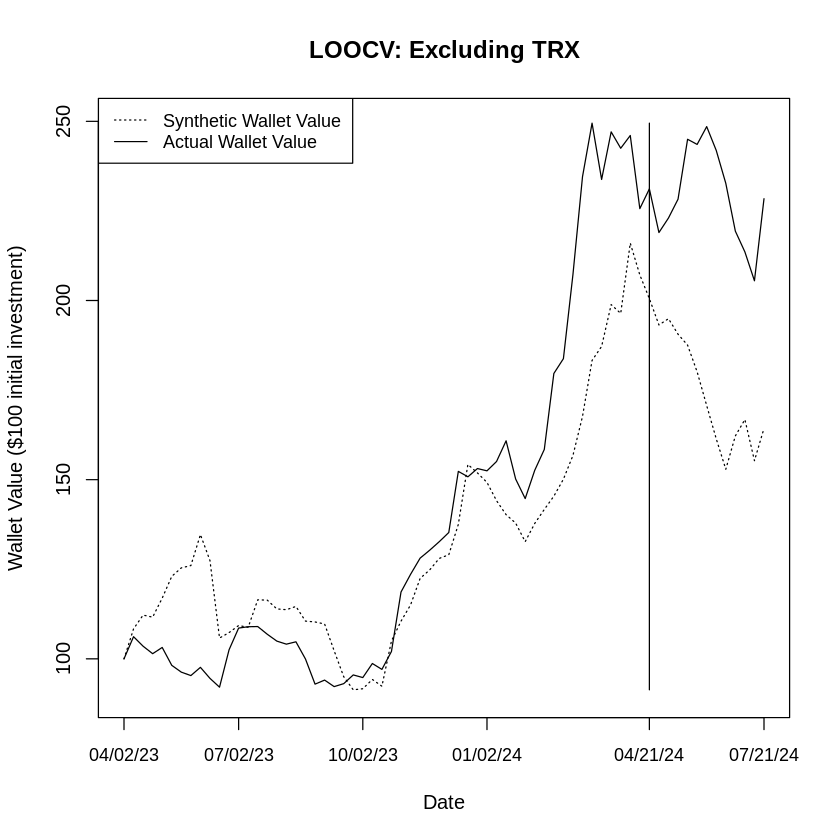


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 54.28128 

solution.v:
 0.3464148 0.0001698478 0.005246557 0.08491458 0.0001434291 0.3143424 0.1170422 0.1316866 0.000039582 

solution.w:
 0.01550044 0.1209416 0.2502115 0.6133464 

Excluded: MX, Mean Gap (56-68): 21.6026


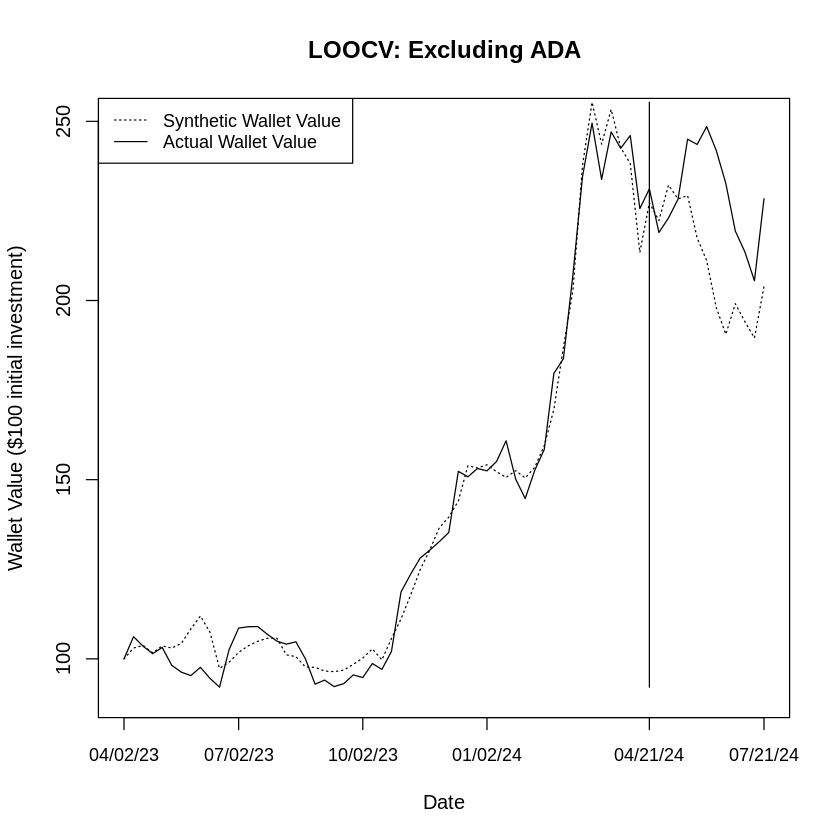


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 479.0389 

solution.v:
 0.3842318 0.000000971 0.00000033 0.0000008098 0.143169 0.2358894 0.1616132 0.05375833 0.02133613 

solution.w:
 0.2878971 0.0000002973 0.3728888 0.3392139 

Excluded: FET, Mean Gap (56-68): 51.8007


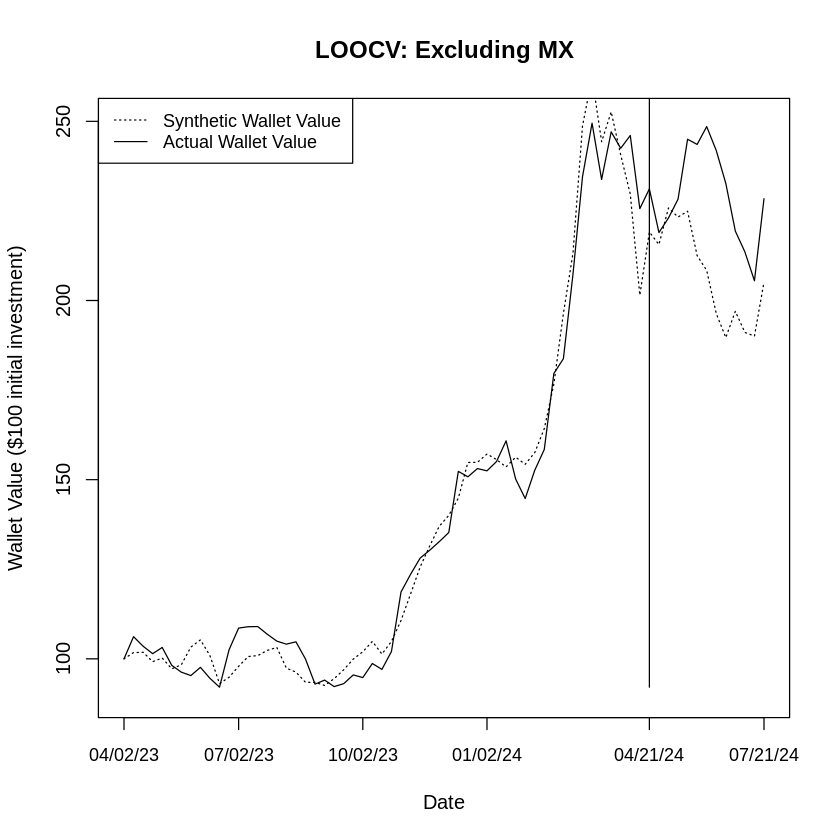


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 36.2718 

solution.v:
 0.1658539 0.1385076 0.07411008 0.001134798 0.05417868 0.2300635 0.2327858 0.1013195 0.002046166 

solution.w:
 0.3265766 0.107008 0.1699457 0.3964697 

Excluded: KCS, Mean Gap (56-68): 25.8690


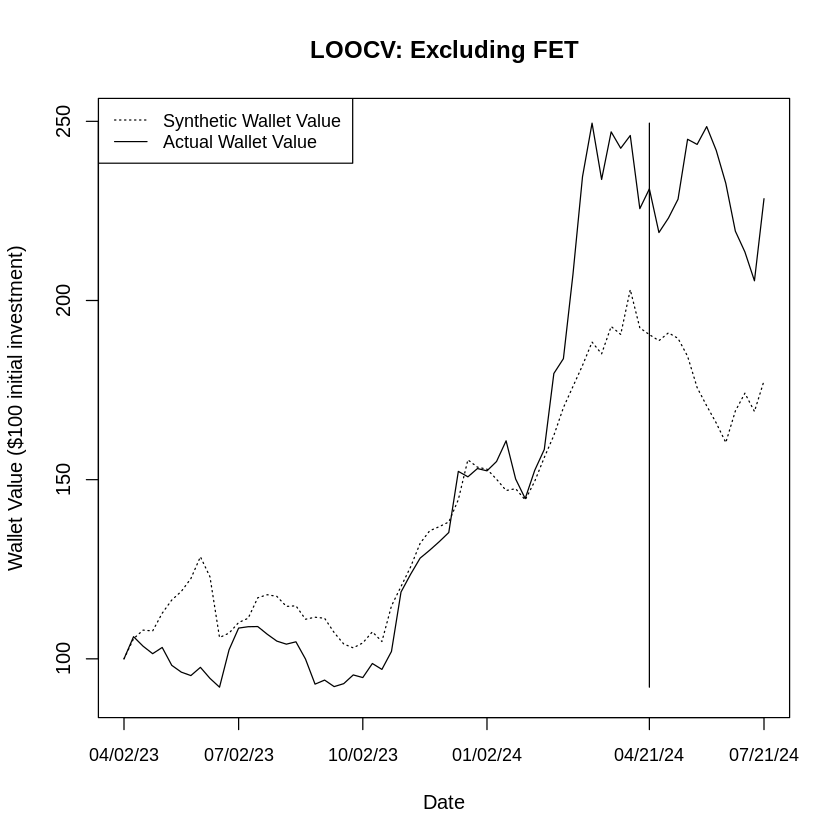

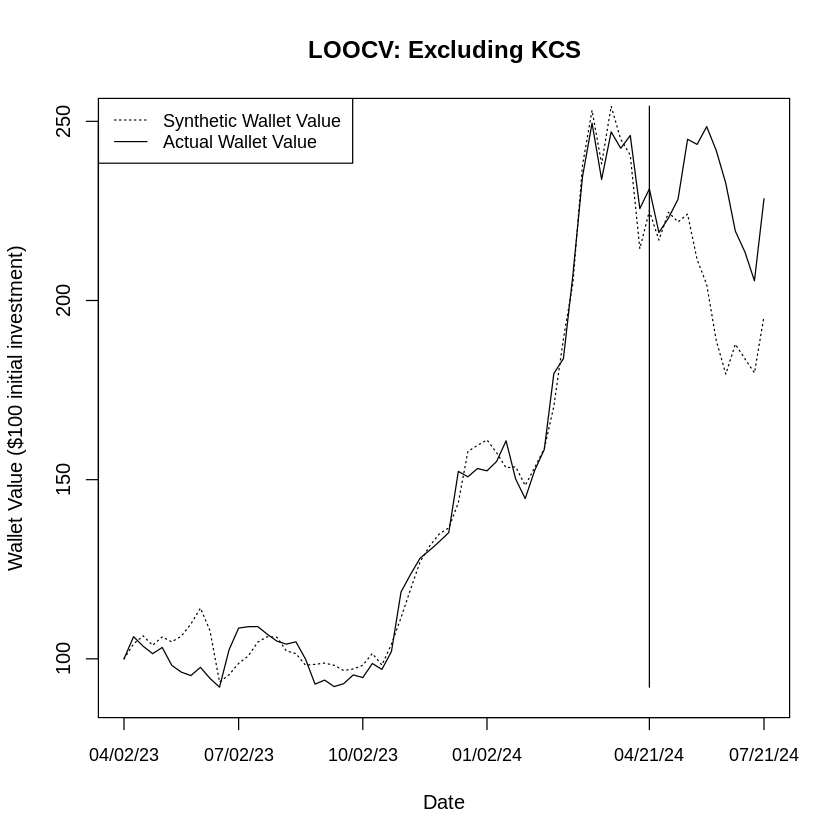

In [ ]:
# Define the selected cryptocurrencies' cryptono values
selected_cryptos <- c(26, 2, 22, 9, 15) # Only donors with weights

loocv_results <- list()

for (crypto_no in selected_cryptos) {
  # Exclude one donor cryptocurrency from the control pool
  loocv_controls <- setdiff(selected_cryptos, crypto_no)

  dp_loocv <- dataprep(
    foo = df,
    predictors         = predictors_list,
    predictors.op      = "mean",
    dependent          = "wallet_value",
    unit.variable      = "cryptono",
    time.variable      = "week_index",
    unit.names.variable = "crypto",
    treatment.identifier = 1,
    controls.identifier  = loocv_controls,
    time.predictors.prior = time_predictors_prior,
    time.optimize.ssr    = time_optimize_ssr,
    time.plot            = time_plot
  )

  synth_loocv <- synth(dp_loocv)
  # Compute the gaps (difference between actual and synthetic)
  gaps_loocv <- dp_loocv$Y1plot - (dp_loocv$Y0plot %*% synth_loocv$solution.w)
  # Compute the mean of the gaps over the period 56:68
  mean_gap <- mean(gaps_loocv[56:68])
  # Get the name of the excluded crypto
  excluded_name <- df$`crypto`[df$cryptono == crypto_no][1]
  loocv_results[[excluded_name]] <- list(dataprep = dp_loocv, synth = synth_loocv, mean_gap=mean_gap)

  # Print or log the mean gap for each iteration
  cat(sprintf("Excluded: %s, Mean Gap (56-68): %.4f\n", excluded_name, mean_gap))

  # Extract the synthetic control and actual series
  synth_2024_series <- dp_loocv$Y0plot %*% synth_loocv$solution.w
  y1_2024_series <- dp_loocv$Y1plot

  # Create a plot dataframe
  halving_date <- 1:68
  halving_plot <- data.frame(
    Date = halving_date,
    Synthetic = as.vector(synth_2024_series),
    Actual = as.vector(y1_2024_series)
  )

  # Plot LOOCV result with adjusted title
  plot(
    x = halving_date, y = halving_plot$Synthetic, type = "l", col = 'black', lty = 'dotted',
    ylab = "Wallet Value ($100 initial investment)", xlab = "Date", xaxt = 'n',ylim=c(90,250),
    main = paste("LOOCV: Excluding", excluded_name)
  )

  # Add actual values
  lines(x = halving_date, y = halving_plot$Actual, col = 'black')

  # Use segments to draw a vertical line at index 56
  y_limits <- range(c(halving_plot$Synthetic, halving_plot$Actual)) # Get y-axis limits
  segments(x0 = 56, y0 = y_limits[1], x1 = 56, y1 = y_limits[2], col = 'black', lty = 1)

  # Legend
  legend(
    'topleft',
    legend = c("Synthetic Wallet Value", "Actual Wallet Value"),
    lty = c("dotted", "solid"),
    col = c("black", "black"),
    ncol = 1,
    cex = 0.9  # Reduce legend text size
  )

  # Custom X-axis labels
  axis(
    side = 1, at = c(1, 13, 26, 39, 56, 68),
    labels = c("04/02/23", "07/02/23", "10/02/23", "01/02/24", "04/21/24", "07/21/24"),
    cex.axis = 0.9, # Reduce font size of axis labels
    las = 1         # Rotate labels 90 degrees
  )

}

# 2020

In [ ]:
# Loading the working file: 2020_recoded_smoothed
df <- read.csv("/content/sample_data/2020_recoded_smoothed.csv")

## Main Model: Y = Wallet Value (Transformed Predictors)


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 163.027 

solution.v:
 0.01308002 0.04163137 0.004462325 0.2230559 0.5278982 0.00136737 0.006144284 0.0000007563 0.07821859 0.002987572 0.1011535 

solution.w:
 0.211045 0.0000016652 0.0000007549 0.0006323952 0.0000136787 0.1143209 0.0002515192 0.0000005014 0.0000013969 0.5641247 0.1094905 0.0000009164 0.0000561783 0.0000406152 0.0000098383 0.0000022326 0.0000045221 0.0000019288 0.0000007207 

$tab.pred
                                                          Treated Synthetic
mean_active_addresses_ratio_Active                          0.029     0.011
mean_new_adoption_rate_New_Adoption_Rate                    0.508     0.358
log_number_of_transactions                                 12.672     5.460
total_addresses_normalized                                  0.588     0.001
trader_balance_normalize

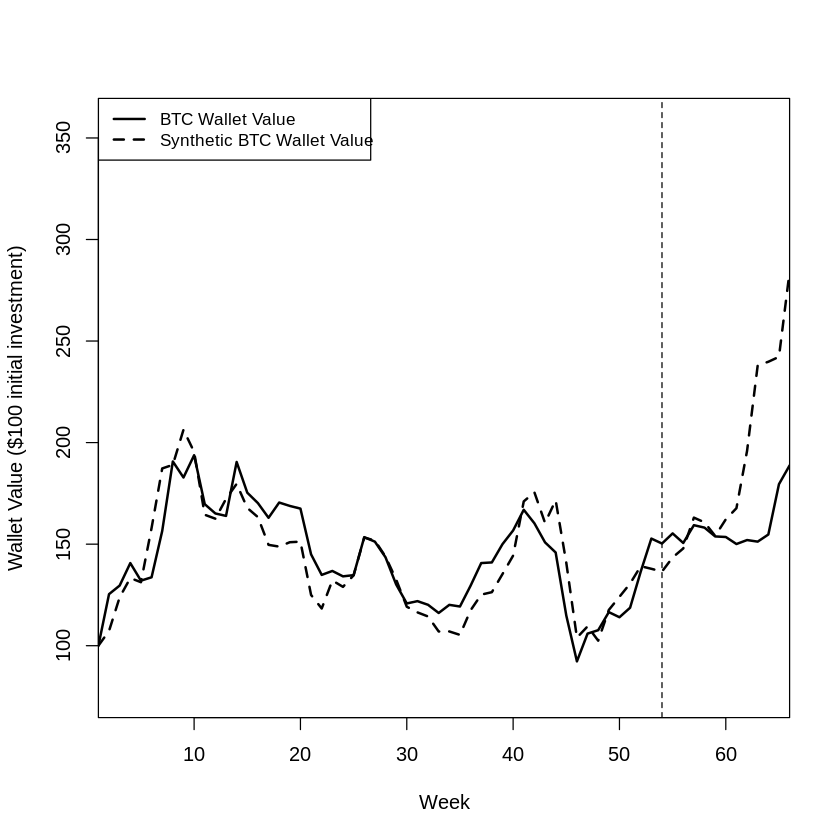

In [ ]:
# New list of predictors
predictors_list <- c(
  "mean_active_addresses_ratio_Active",
  "mean_new_adoption_rate_New_Adoption_Rate",
  "log_number_of_transactions",
  "total_addresses_normalized",
  "trader_balance_normalized",
  "mean_addresses_by_holdings_in_usd_X_0_00____1_00_share",
  "mean_addresses_by_holdings_in_usd_X_1_00____10_00_share",
  "mean_addresses_by_holdings_in_usd_X_10_00____100_00_share",
  "mean_addresses_by_holdings_in_usd_X_10k____100k_share",
  "time_between_transactions_by_addresses",
  "mean_total_addresses_Total_Zero_Balance_share"
)

# Define control units, excluding certain cryptos
all_controls <- c(2:26) # define the list of all control units
excluded_units <- c(3, 9, 14, 16, 22, 8) # specify the units to exclude due to low covariate data availability: ALGO, FET, JET, MX, LEO, ETH
controls_identifier <- setdiff(all_controls, excluded_units) # create the final list of control units by excluding the specified units

# Define the time periods
time_predictors_prior <- c(1:54)
time_optimize_ssr <- time_predictors_prior
time_plot <- c(1:66)

# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "wallet_value",  # Use the wallet value as the dependent variable
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 1,  # Set the treated unit identifier
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)

# Run the synthetic control model
synth.out <- synth(dataprep.out)

# Get results and check fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)

# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "Wallet Value ($100 initial investment)",
  Xlab = "Week",
  Legend = c("BTC Wallet Value", "Synthetic BTC Wallet Value"),
  Legend.position = "topleft"
)

abline(v   = 54,
       lty = 2)

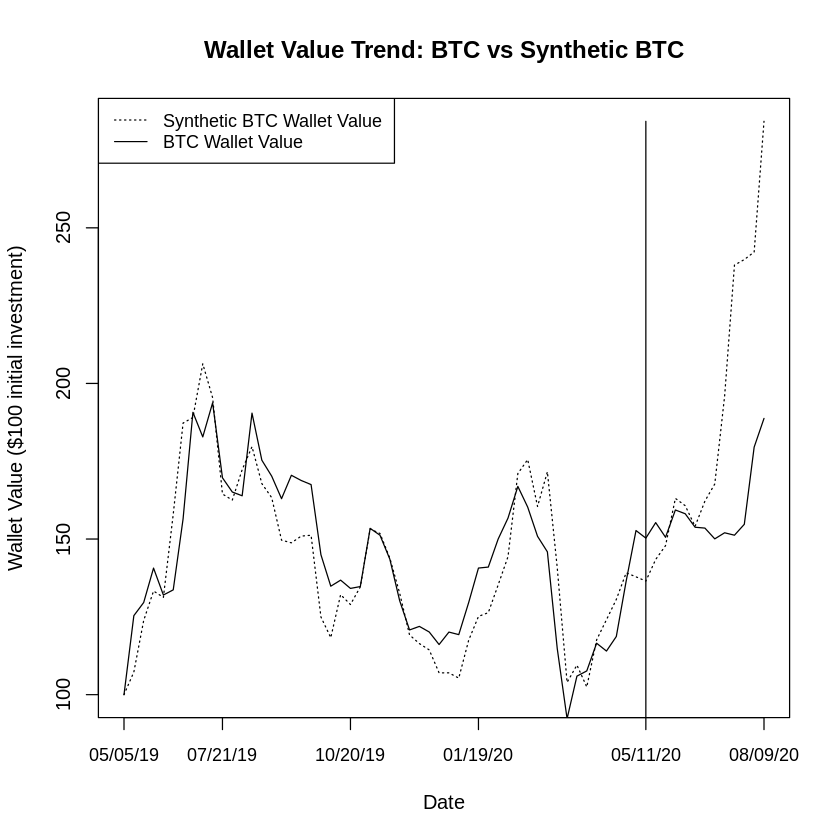

In [ ]:
# Extract the synthetic control and actual series
synth_2020_series <- dataprep.out$Y0plot %*% synth.out$solution.w
y1_2020_series <- dataprep.out$Y1plot

# Create a plot dataframe
halving_date <- 1:66
halving_plot <- data.frame(
  Date = halving_date,
  Synthetic = as.vector(synth_2020_series),
  Actual = as.vector(y1_2020_series)
)

# Plot results
plot(
  x = halving_date, y = halving_plot$Synthetic, type = "l", col = 'black', lty = 'dotted',
  ylab = "Wallet Value ($100 initial investment)", xlab = "Date", xaxt = 'n'
)
lines(x = halving_date, y = halving_plot$Actual, col = 'black')
title(main = "Wallet Value Trend: BTC vs Synthetic BTC")
#abline(v = c(54), col = c('black'))

# Use segments to draw vertical lines
y_limits <- range(c(halving_plot$Synthetic, halving_plot$Actual)) # Get y-axis limits
segments(x0 = 54, y0 = y_limits[1], x1 = 54, y1 = y_limits[2], col = 'black', lty = 1)

# Legend
legend(
  'topleft',
  legend = c("Synthetic BTC Wallet Value", "BTC Wallet Value"),
  lty = c("dotted", "solid"),
  col = c("black", "black"),
  ncol = 1,
  cex = 0.9       # Reduce legend text size
)

axis(
  side = 1, at = c(1, 11, 24, 37, 54, 66),
  labels = c("05/05/19", "07/21/19", "10/20/19", "01/19/20", "05/11/20", "08/09/20"),
  cex.axis = 0.9, # Reduce font size of axis labels
  las = 1         # Rotate labels 90 degrees
)

# 1 = May 5, 2019
# 11 = July 21, 2019
# 24 = October 20, 2019
# 37 = January 19, 2020
# 54 = May 17, 2020
# 66 = August 9, 2020

## Gaps

,1
1,-0.000000007910472
2,18.118328752322725
3,5.770403620472763
4,7.365486532670587
5,0.761752062422318
6,-24.287579277402386
7,-30.804926781356386
8,1.651402206918220
9,-23.490617324959203
10,-1.647798849336681


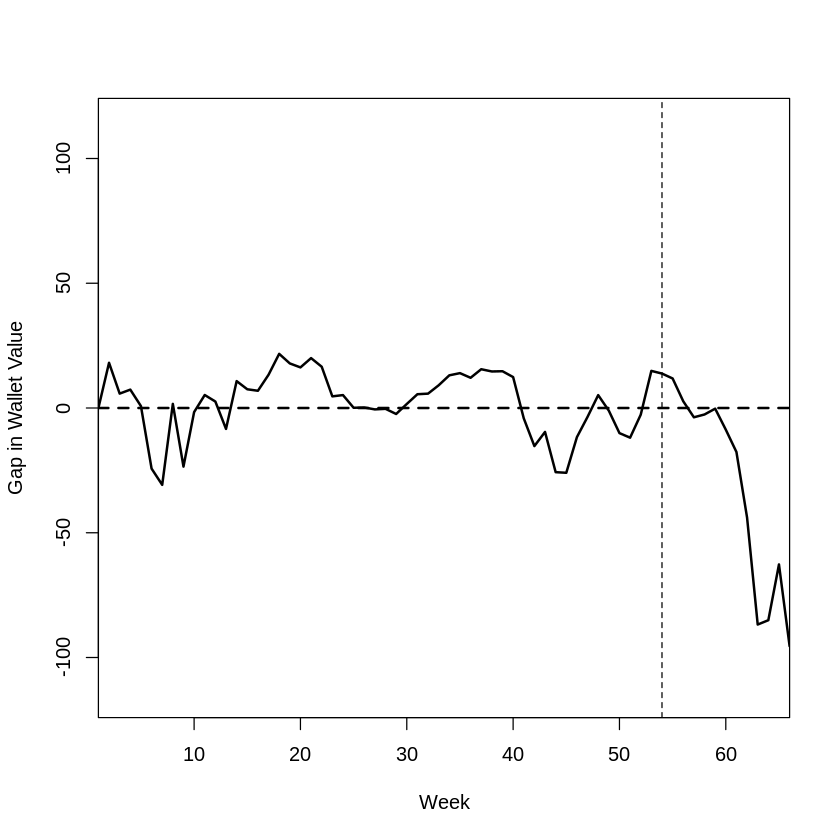

In [ ]:
# Main model: gaps plot
gaps.plot(synth.res    = synth.out,
          dataprep.res = dataprep.out,
          Ylab         = c("Gap in Wallet Value"),
          Xlab         = c("Week"),
          Main         = ""
)
abline(v   = 54,
       lty = 2)

gaps<- dataprep.out$Y1plot-(
        dataprep.out$Y0plot%*%synth.out$solution.w
        ) ; gaps

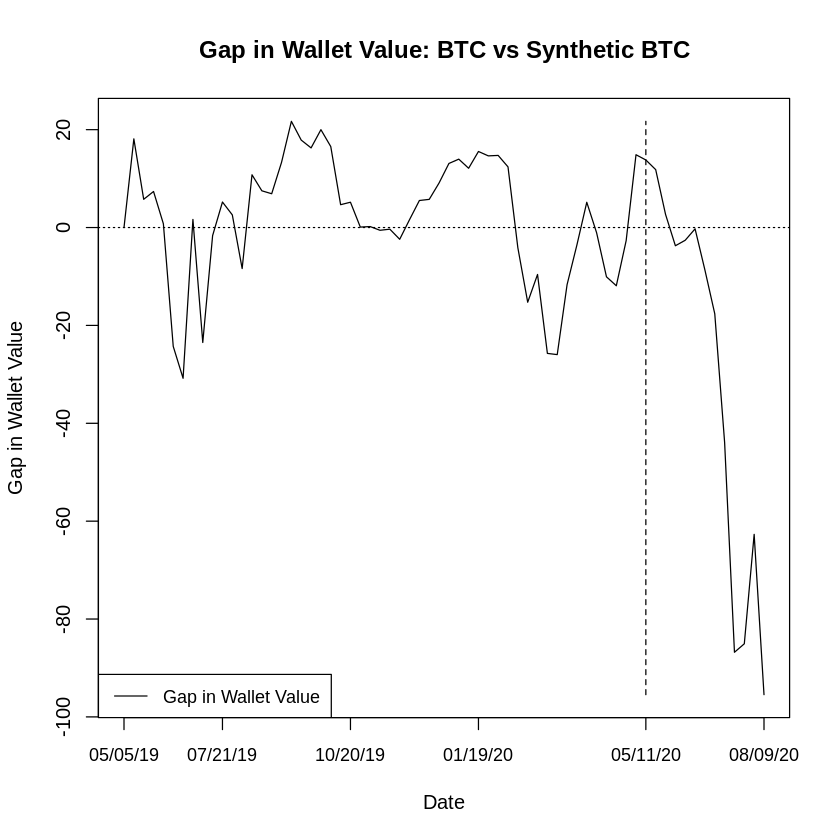

In [ ]:
# Create a plot dataframe
halving_date_2020 <- 1:66  # Week indices
halving_plot_2020 <- data.frame(
  Date = halving_date_2020,
  Gap = as.vector(gaps[1:66])  # Restrict gaps to the desired range
)

# Plot the gaps
plot(
  x = halving_date_2020, y = halving_plot_2020$Gap, type = "l", col = 'black',
  ylab = "Gap in Wallet Value", xlab = "Date", xaxt = 'n',
  main = "Gap in Wallet Value: BTC vs Synthetic BTC"
)

# Add a vertical line at the treatment date (week 56)
y_limits <- range(halving_plot_2020$Gap)  # Get y-axis limits
segments(x0 = 54, y0 = y_limits[1], x1 = 54, y1 = y_limits[2], col = 'black', lty = 2)

# Add a horizontal dotted line at y = 0
abline(h = 0, col = 'black', lty = 3)  # lty = 3 creates a dotted line

# Add a legend
legend(
  'bottomleft',
  legend = c("Gap in Wallet Value"),
  lty = "solid",
  col = "black",
  ncol = 1,
  cex = 0.9  # Reduce legend text size
)

axis(
  side = 1, at = c(1, 11, 24, 37, 54, 66),
  labels = c("05/05/19", "07/21/19", "10/20/19", "01/19/20", "05/11/20", "08/09/20"),
  cex.axis = 0.9, # Reduce font size of axis labels
  las = 1         # Rotate labels 90 degrees
)

## Placebo In Time: Mid-December 2019


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 244.4883 

solution.v:
 0.002287447 0.1303111 0.03469164 0.1333811 0.3376382 0.07233059 0.2109753 0.03396401 0.005929779 0.02898449 0.009506377 

solution.w:
 0.3885775 0.0000056724 0.0000023296 0.0000323795 0.000008909 0.000002401 0.0000203548 0.0000011268 0.0000044793 0.0000361461 0.1849284 0.1588205 0.0002547672 0.0000000361 0.0000105595 0.0000141451 0.267259 0.0000021568 0.0000191595 

$tab.pred
                                                          Treated Synthetic
mean_active_addresses_ratio_Active                          0.030     0.041
mean_new_adoption_rate_New_Adoption_Rate                    0.501     0.413
log_number_of_transactions                                 12.705     6.378
total_addresses_normalized                                  0.560     0.001
trader_balance_normalized   

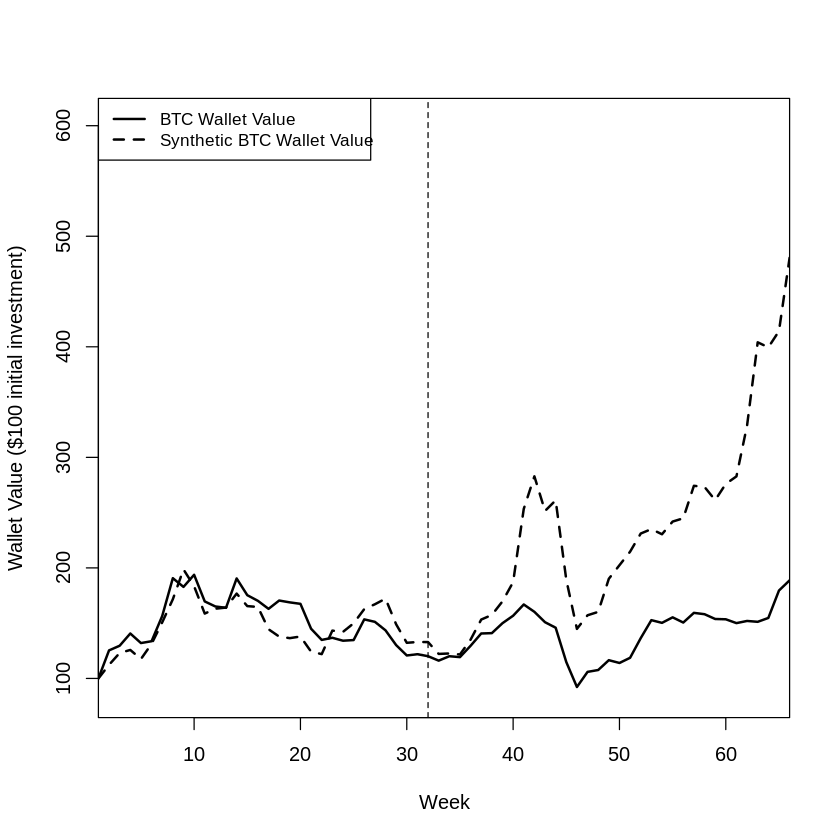

In [ ]:
# Define the time periods
time_predictors_prior <- c(1:33) # 21 weeks prior
time_optimize_ssr <- time_predictors_prior
time_plot <- c(1:66)

# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "wallet_value",  # Use the wallet value as the dependent variable
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 1,  # Set the treated unit identifier
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)

# Run the synthetic control model
synth.out <- synth(dataprep.out)

# Get results and check fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)

# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "Wallet Value ($100 initial investment)",
  Xlab = "Week",
  Legend = c("BTC Wallet Value", "Synthetic BTC Wallet Value"),
  Legend.position = "topleft"
)

abline(v   = 32,
       lty = 2)

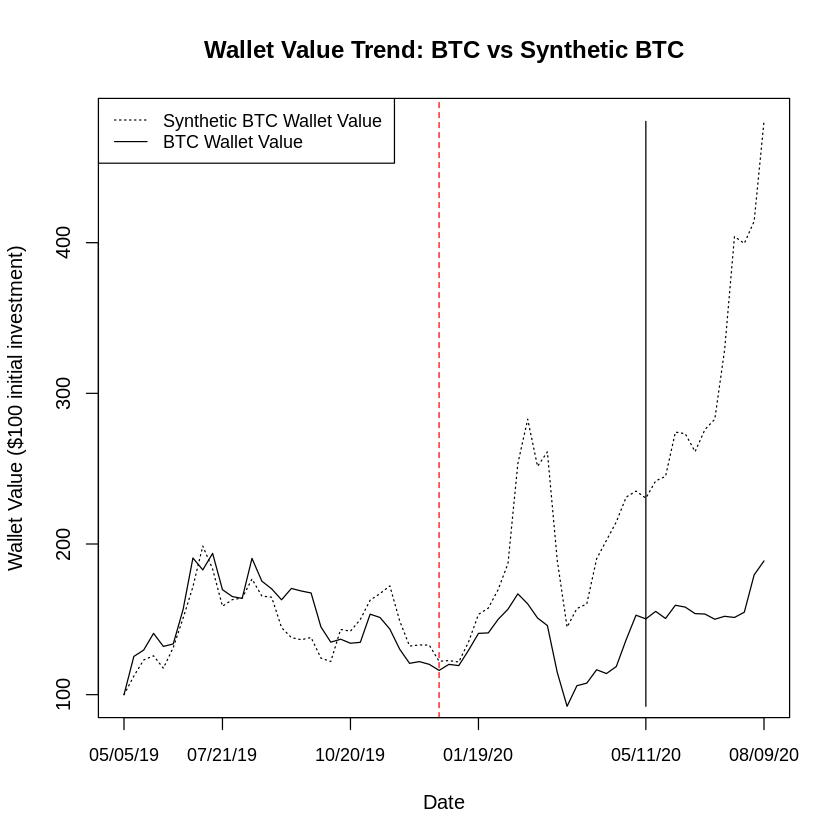

In [ ]:
# Extract the synthetic control and actual series
synth_2020_time_placebo_series <- dataprep.out$Y0plot %*% synth.out$solution.w
y1_2020_time_placebo_series <- dataprep.out$Y1plot

# Create a plot dataframe
halving_date <- 1:66
halving_plot <- data.frame(
  Date = halving_date,
  Synthetic = as.vector(synth_2020_time_placebo_series),
  Actual = as.vector(y1_2020_time_placebo_series)
)

# Plot results
plot(
  x = halving_date, y = halving_plot$Synthetic, type = "l", col = 'black', lty = 'dotted',
  ylab = "Wallet Value ($100 initial investment)", xlab = "Date", xaxt = 'n'
)
lines(x = halving_date, y = halving_plot$Actual, col = 'black')
title(main = "Wallet Value Trend: BTC vs Synthetic BTC")
#abline(v = c(54), col = c('black'))

# Lines
abline(v   = 33,
       lty = 2, col="red")

# Use segments to draw vertical lines
y_limits <- range(c(halving_plot$Synthetic, halving_plot$Actual)) # Get y-axis limits
segments(x0 = 54, y0 = y_limits[1], x1 = 54, y1 = y_limits[2], col = 'black', lty = 1)

# Legend
legend(
  'topleft',
  legend = c("Synthetic BTC Wallet Value", "BTC Wallet Value"),
  lty = c("dotted", "solid"),
  col = c("black", "black"),
  ncol = 1,
  cex = 0.9       # Reduce legend text size
)

axis(
  side = 1, at = c(1, 11, 24, 37, 54, 66),
  labels = c("05/05/19", "07/21/19", "10/20/19", "01/19/20", "05/11/20", "08/09/20"),
  cex.axis = 0.9, # Reduce font size of axis labels
  las = 1         # Rotate labels 90 degrees
)

# 1 = May 5, 2019
# 11 = July 21, 2019
# 24 = October 20, 2019
# 37 = January 19, 2020
# 54 = May 17, 2020
# 66 = August 9, 2020

## In-Space Placebo (Unit): ADA


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 54.31168 

solution.v:
 0.0007340005 0.0000559648 0.1127008 0.1963036 0.2841123 0.2471497 0.02397604 0.007915651 0.02069263 0.02665986 0.07969938 

solution.w:
 0.005228617 0.0000000045 0.0000000054 0.197755 0.5541794 0.0694906 0.0000000011 0.1730165 0.0000000085 0.0000000028 0.0002824469 0.000000005 0.0000000059 0.0000002655 0.0000020104 0.0000000061 0.0000406122 0.0000045463 0.0000000131 

$tab.pred
                                                          Treated Synthetic
mean_active_addresses_ratio_Active                          0.018     0.017
mean_new_adoption_rate_New_Adoption_Rate                    0.540     0.297
log_number_of_transactions                                  7.741     7.234
total_addresses_normalized                                  0.002     0.012
trader_balance_normalized 

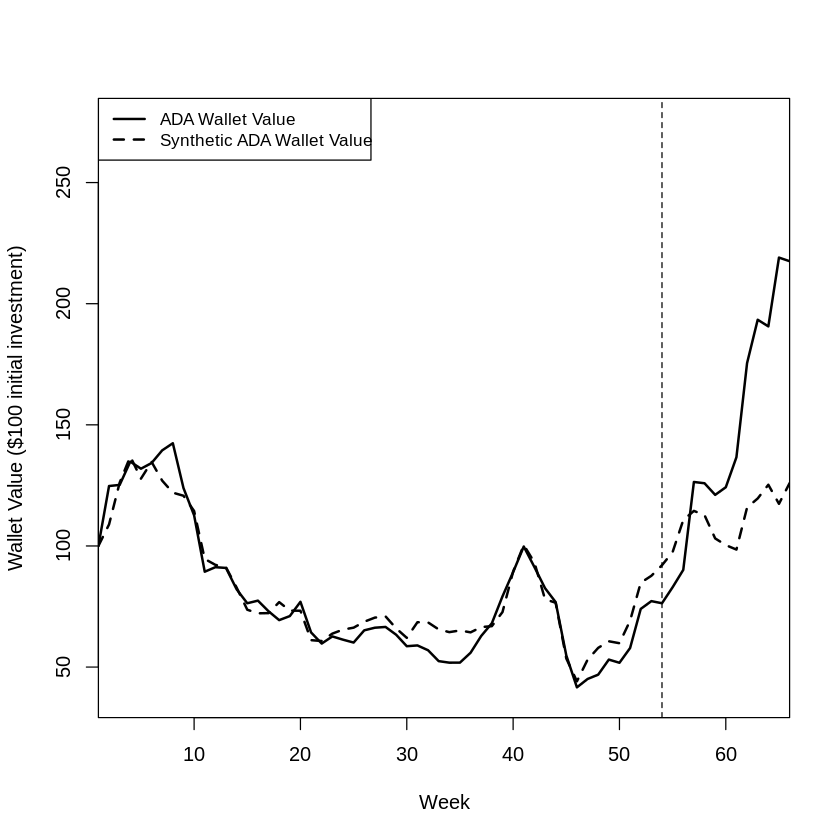

In [ ]:
# Define control units, excluding certain cryptos
all_controls <- c(1:26) # define the list of all control units
excluded_units <- c(3, 9, 14, 16, 22, 8, 2) # specify the units to exclude due to low covariate data availability: ALGO, FET, JET, MX, LEO, ETH + ADA (placebo)
controls_identifier <- setdiff(all_controls, excluded_units) # create the final list of control units by excluding the specified units

# Define the time periods
time_predictors_prior <- c(1:54)
time_optimize_ssr <- time_predictors_prior
time_plot <- c(1:66)

# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "wallet_value",  # Use the wallet value as the dependent variable
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 2,  # ADA
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)

# Run the synthetic control model
synth.out <- synth(dataprep.out)

# Get results and check fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)

# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "Wallet Value ($100 initial investment)",
  Xlab = "Week",
  Legend = c("ADA Wallet Value", "Synthetic ADA Wallet Value"),
  Legend.position = "topleft"
)

abline(v   = 54,
       lty = 2)

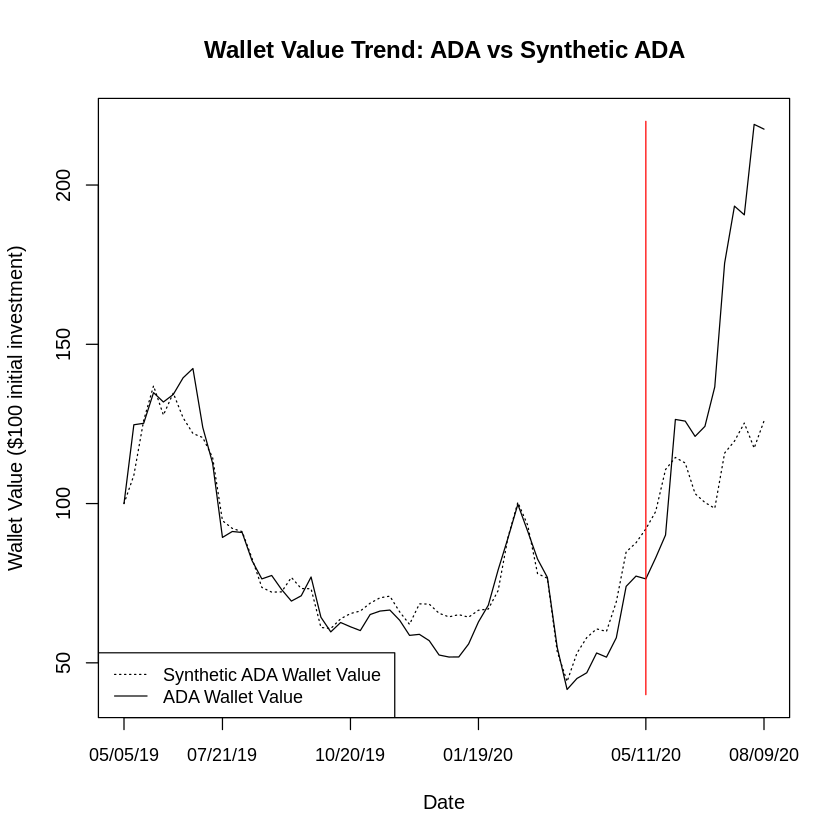

In [ ]:
# Extract the synthetic control and actual series
synth_2020_unit_placebo_series <- dataprep.out$Y0plot %*% synth.out$solution.w
y1_2020_unit_placebo_series <- dataprep.out$Y1plot

# Create a plot dataframe
halving_date <- 1:66
halving_plot <- data.frame(
  Date = halving_date,
  Synthetic = as.vector(synth_2020_unit_placebo_series),
  Actual = as.vector(y1_2020_unit_placebo_series)
)

# Plot results
plot(
  x = halving_date, y = halving_plot$Synthetic, type = "l", col = 'black', lty = 'dotted',
  ylab = "Wallet Value ($100 initial investment)", xlab = "Date", xaxt = 'n',
  ylim = c(40, 220)
)
lines(x = halving_date, y = halving_plot$Actual, col = 'black')
title(main = "Wallet Value Trend: ADA vs Synthetic ADA")
#abline(v = c(54), col = c('black'))

# Use segments to draw vertical lines
y_limits <- range(c(40,220)) # Get y-axis limits
segments(x0 = 54, y0 = y_limits[1], x1 = 54, y1 = y_limits[2], col = 'red', lty = 1)

# Legend
legend(
  'bottomleft',
  legend = c("Synthetic ADA Wallet Value", "ADA Wallet Value"),
  lty = c("dotted", "solid"),
  col = c("black", "black"),
  ncol = 1,
  cex = 0.9       # Reduce legend text size
)

axis(
  side = 1, at = c(1, 11, 24, 37, 54, 66),
  labels = c("05/05/19", "07/21/19", "10/20/19", "01/19/20", "05/11/20", "08/09/20"),
  cex.axis = 0.9, # Reduce font size of axis labels
  las = 1         # Rotate labels 90 degrees
)

# 1 = May 5, 2019
# 11 = July 21, 2019
# 24 = October 20, 2019
# 37 = January 19, 2020
# 54 = May 17, 2020
# 66 = August 9, 2020

## Spaghetti

> **NB!** Run the main model cell before

 

**************** 
**************** 
**************** 

MSPE (LOSS V): 256.7715 

solution.v:
 0.2211071 0.000005503 0.00829947 0.009365424 0.002757567 0.03706301 0.002827073 0.0332108 0.2173126 0.449485 0.01856641 

solution.w:
 0.007181999 0.001432994 0.08962434 0.103679 0.01369004 0.01035764 0.2710218 0.002253366 0.007302947 0.0000817333 0.001175773 0.007822465 0.00617316 0.4628366 0.004074356 0.005373655 0.0000416164 0.005876544 


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 4567.561 

solution.v:
 0.0000005712 0.1652423 0.09756851 0.1301034 0.2513768 0.002180232 0.000003528 0.000010202 0.3327638 0.0000055184 0.02074519 

solution.w:
 0.006555627 0.005948855 0.009373076 0.01052508 0.008716685 0.496479 0.0546659 0.303611 0.03868098 0.004451872 0.004283056 0.01097654 0.007782743 0.006592209 0.007668565 0.003566534 0.006742159 0.01338019 




New names:
• `w.weight` -> `w.weight...1`
• `w.weight` -> `w.weight...2`
• `w.weight` -> `w.weight...3`
• `w.weight` -> `w.weight...4`
• `w.weight` -> `w.weight...5`
• `w.weight` -> `w.weight...6`
• `w.weight` -> `w.weight...7`
• `w.weight` -> `w.weight...8`
• `w.weight` -> `w.weight...9`
• `w.weight` -> `w.weight...10`
• `w.weight` -> `w.weight...11`
• `w.weight` -> `w.weight...12`
• `w.weight` -> `w.weight...13`
• `w.weight` -> `w.weight...14`
• `w.weight` -> `w.weight...15`
• `w.weight` -> `w.weight...16`
• `w.weight` -> `w.weight...17`
• `w.weight` -> `w.weight...18`
• `w.weight` -> `w.weight...19`
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


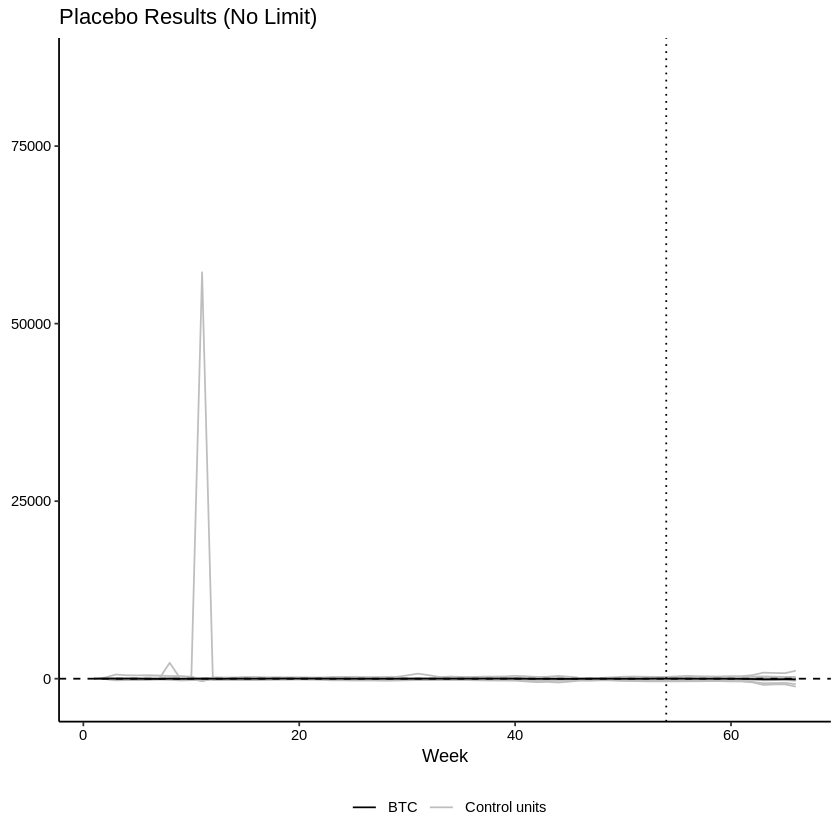

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


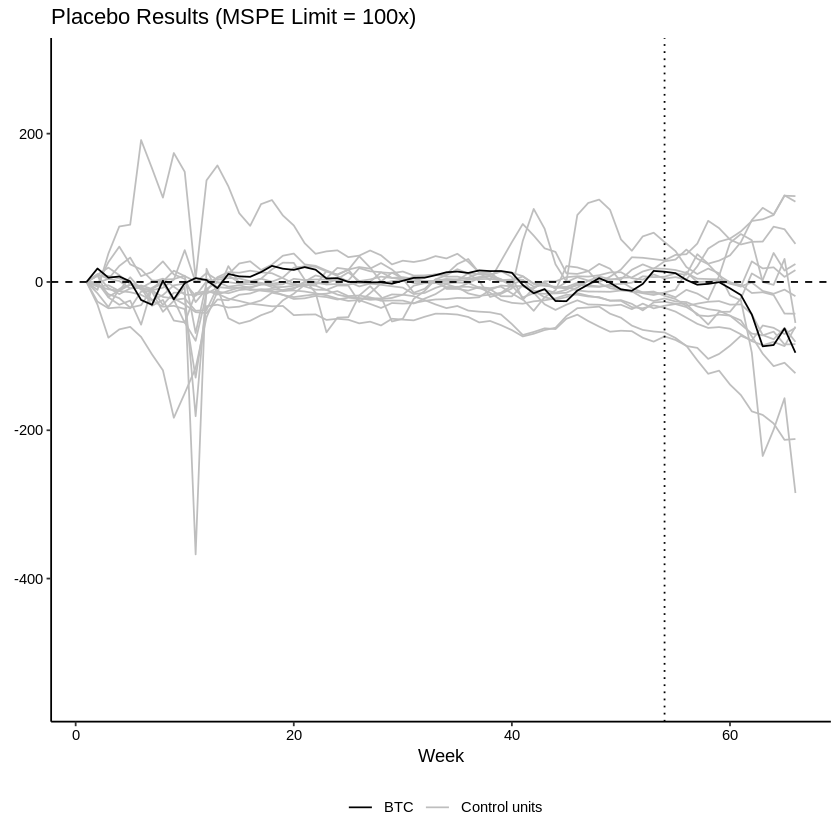

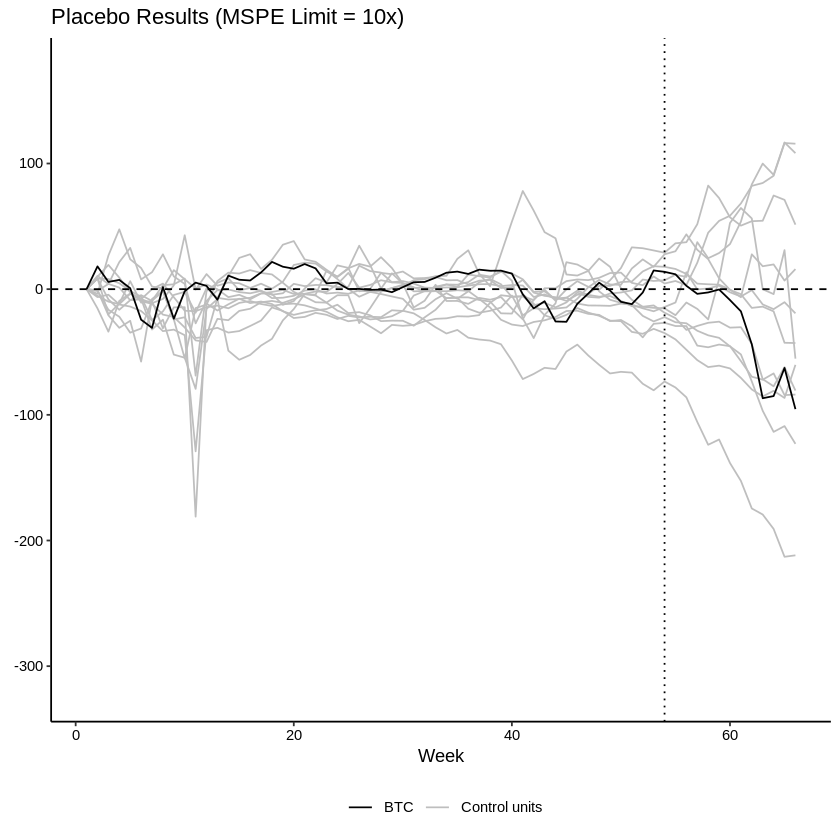

In [ ]:
# Generate and plot placebos using the multicore strategy
placebo <- generate.placebos(dataprep.out, synth.out, Sigf.ipop = 2, strategy = 'multicore')

p  <- plot_placebos(placebo, discard.extreme = FALSE, xlab = 'Week') +
  ggtitle("Placebo Results (No Limit)")
p1 <- plot_placebos(placebo, discard.extreme = TRUE, mspe.limit = 100, xlab = 'Week') +
  ggtitle("Placebo Results (MSPE Limit = 100x)")
p2 <- plot_placebos(placebo, discard.extreme = TRUE, mspe.limit = 10, xlab = 'Week') +
  ggtitle("Placebo Results (MSPE Limit = 10x)")

p  + scale_color_manual(name = "", values = c("black", "grey"),
                              labels = c("BTC", "Control units"))
p1 + scale_color_manual(name = "", values = c("black", "grey"),
                              labels = c("BTC", "Control units"))
p2 + scale_color_manual(name = "", values = c("black", "grey"),
                              labels = c("BTC", "Control units"))

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


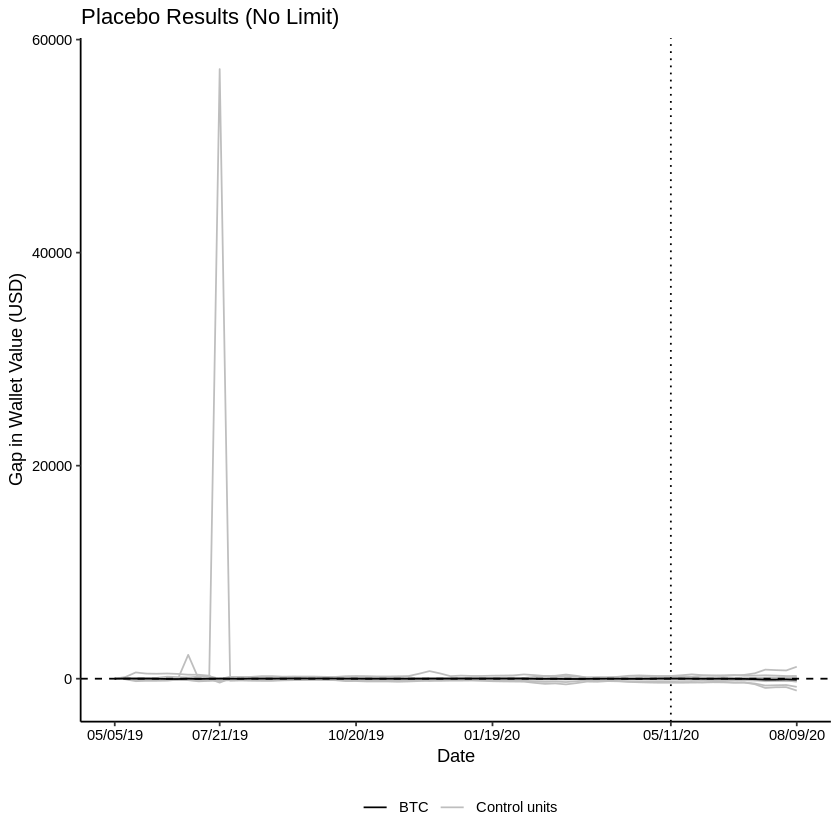

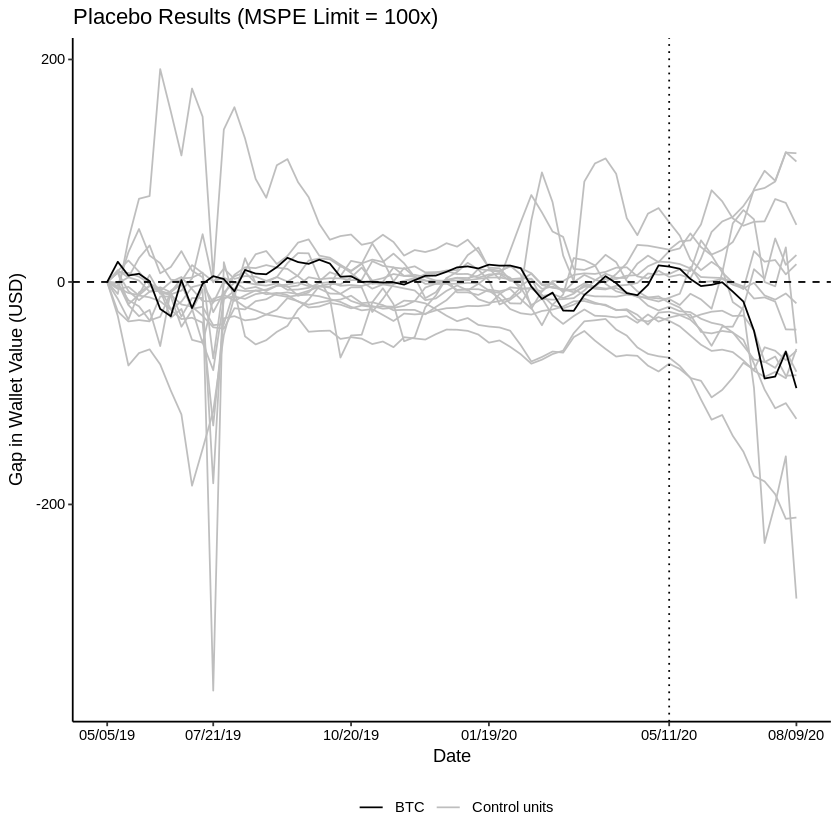

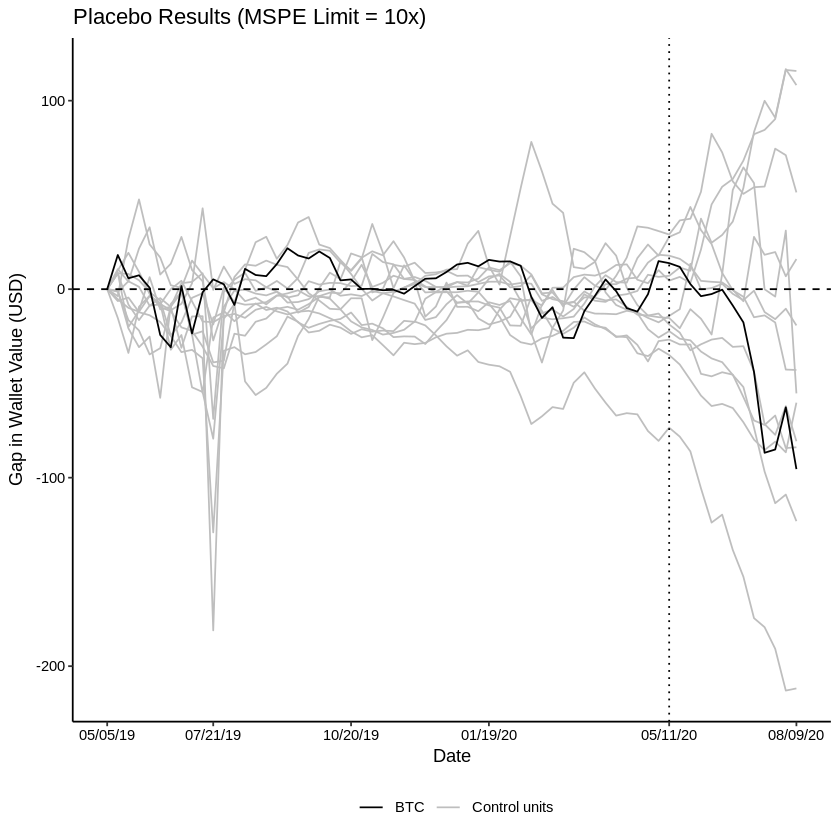

In [ ]:
# Define the custom x-axis breaks and labels (week indices to dates)
custom_breaks <- c(1, 11, 24, 37, 54, 66)
custom_labels <- c("05/05/19", "07/21/19", "10/20/19", "01/19/20", "05/11/20", "08/09/20")

# Update each plot by adding scale_x_continuous()
p_date  <- p +
  scale_color_manual(name = "", values = c("black", "grey"),
                     labels = c("BTC", "Control units")) +
  scale_x_continuous("Date", breaks = custom_breaks, labels = custom_labels)  +
  scale_y_continuous("Gap in Wallet Value (USD)")

p1_date <- p1 +
  scale_color_manual(name = "", values = c("black", "grey"),
                     labels = c("BTC", "Control units")) +
  scale_x_continuous("Date", breaks = custom_breaks, labels = custom_labels) +
  scale_y_continuous("Gap in Wallet Value (USD)")

p2_date <- p2 +
  scale_color_manual(name = "", values = c("black", "grey"),
                     labels = c("BTC", "Control units")) +
  scale_x_continuous("Date", breaks = custom_breaks, labels = custom_labels) +
  scale_y_continuous("Gap in Wallet Value (USD)")

# Print the plots
p_date
p1_date
p2_date

## MSPE

[1] "Placebo in-space p-value: 0.2"
    MSPE.ratios  unit
1  18.753641048   ADA
2   1.390007022  ANKR
3  62.989849602   CRO
4   2.101298286  DOGE
5   1.065786026   ENJ
6   0.212942387   FTM
7  12.386061442   GNO
8  12.209964887   HOT
9   0.527608082  IOTX
10 12.088933054   KCS
11 13.590956935  LINK
12 15.216470808   LPT
13  4.818489813  MANA
14  1.082883532 MATIC
15  7.399803787   MKR
16  1.378702124  NEXO
17  4.545676689   OKB
18  0.006076182   QNT
19 20.283656322   TRX
20 15.485275326   BTC


Warning message:
“NAs introduced by coercion”
Warning message:
“Removed 20 rows containing non-finite outside the scale range (`stat_bin()`).”


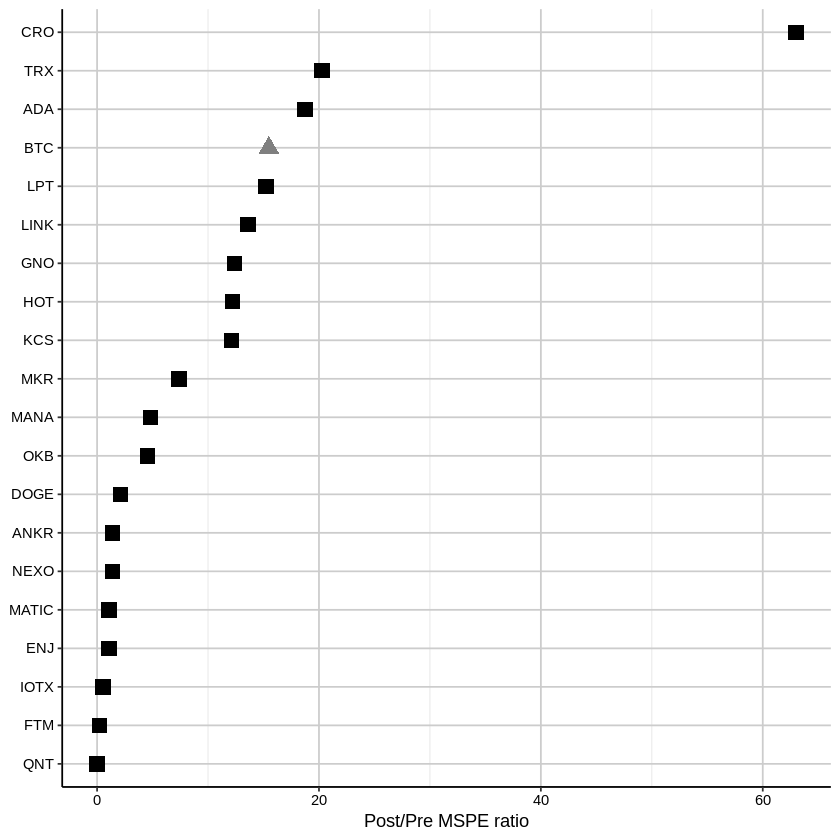

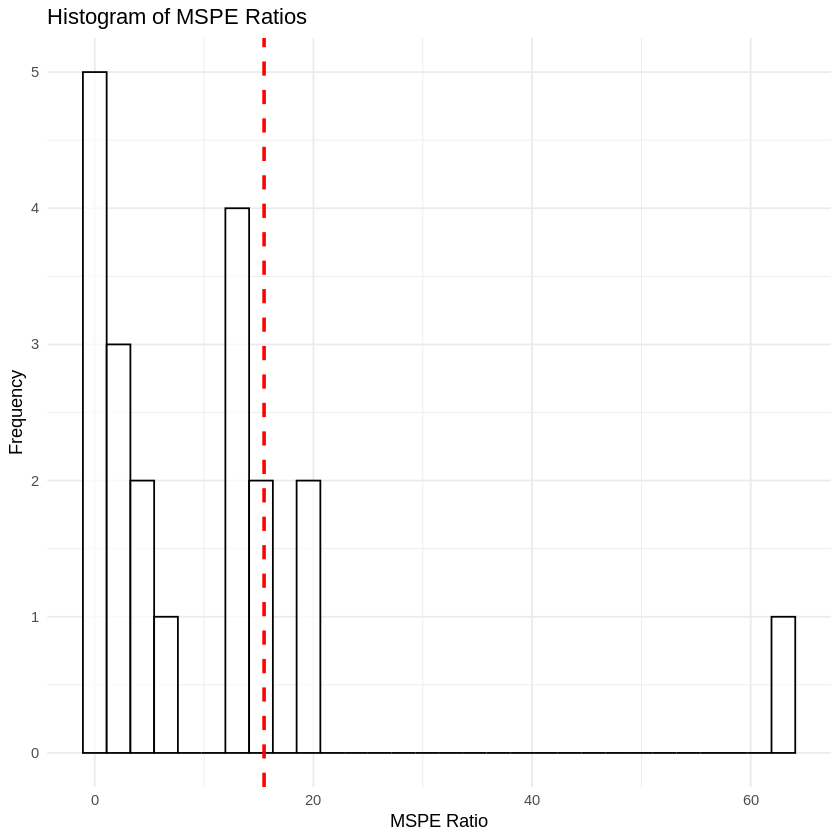

In [ ]:
# Compute and print MSPE ratio and p-value
ratio   <- mspe.test(placebo)
p_value <- ratio$p.val
print(paste("Placebo in-space p-value:", p_value))
print(ratio$test)

# Scatter Plot
mspe_plot(placebo)

# Extract and convert MSPE ratios to numeric
mspe_values <- as.numeric(as.character(unlist(ratio$test)))
mspe_data   <- data.frame(MSPE_Ratio = mspe_values)

# Assume BTC's MSPE is at index 20
btc_mspe <- mspe_values[20]

# Plot histogram with BTC's MSPE highlighted
ggplot(mspe_data, aes(x = MSPE_Ratio)) +
  geom_histogram(bins = 30, fill = "white", color = "black", alpha = 0.7) +
  geom_vline(xintercept = btc_mspe, color = "red", linetype = "dashed", size = 1) +
  annotate("text", x = btc_mspe, y = Inf, label = "BTC",
           vjust = -0.5, color = "red") +
  labs(title = "Histogram of MSPE Ratios",
       x = "MSPE Ratio", y = "Frequency") +
  theme_minimal()

## Pre-treatment MSPE Comparison

### MSPE limit = 10

Pre-Treatment MSPE for Bitcoin: 163.027 

Comparison of donor MSPEs relative to Bitcoin:
                     Crypto Pre_Treatment_MSPE Relative_to_BTC
unlist(mspe.placs)1     ADA          256.77146       1.5750245
unlist(mspe.placs)2    ANKR         4567.56091      28.0172115
unlist(mspe.placs)3     CRO           82.68665       0.5071961
unlist(mspe.placs)4    DOGE           90.62095       0.5558648
unlist(mspe.placs)5     ENJ          691.27126       4.2402266
unlist(mspe.placs)6     FTM         5244.21565      32.1677810
unlist(mspe.placs)7     GNO          285.27051       1.7498364
unlist(mspe.placs)8     HOT          285.48231       1.7511356
unlist(mspe.placs)9    IOTX          192.78101       1.1825100
unlist(mspe.placs)10    KCS          446.78500       2.7405589
unlist(mspe.placs)11   LINK        24797.19061     152.1048429
unlist(mspe.placs)12    LPT         1566.05070       9.6060840
unlist(mspe.placs)13   MANA          949.89270       5.8265987
unlist(mspe.placs)14  MATIC  

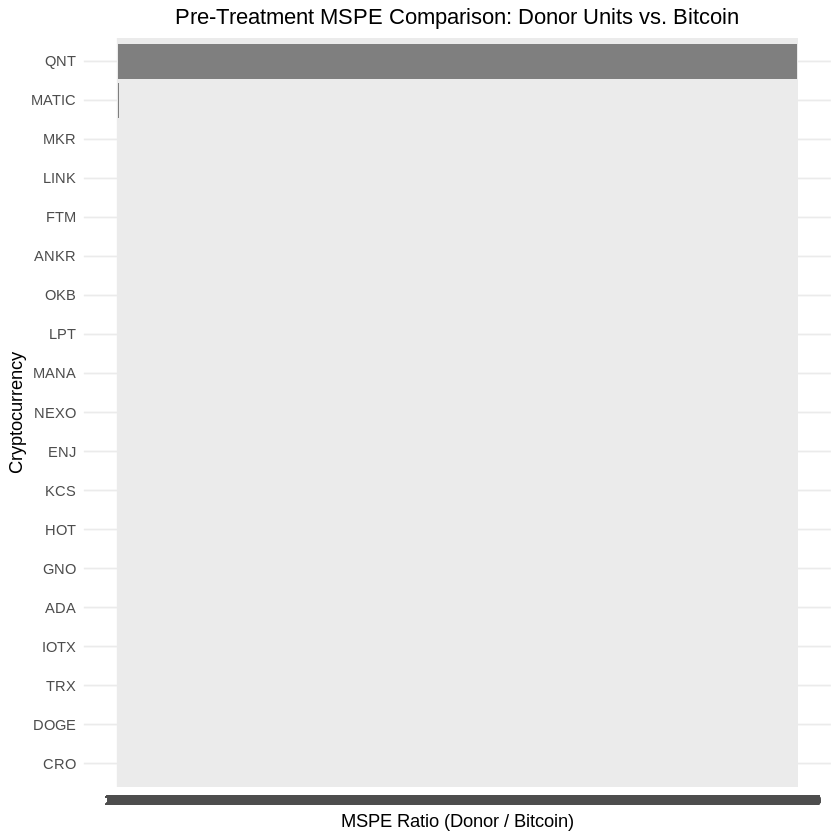

In [ ]:
# Extract Bitcoin's observed and synthetic values for the pre-treatment period
observed_btc <- dataprep.out$Y1plot[which(dataprep.out$tag$time.plot %in% time_predictors_prior)]
synthetic_btc <- (dataprep.out$Y0plot %*% synth.out$solution.w)[which(dataprep.out$tag$time.plot %in% time_predictors_prior)]

# Compute pre-treatment MSPE for Bitcoin
mspe_btc <- mean((observed_btc - synthetic_btc)^2, na.rm = TRUE)

# Extract donor MSPEs
donor_mspe <- unlist(placebo$mspe.placs)

# Extract donor cryptocurrency names
donor_cryptos <- dataprep.out$tag$controls.identifier  # Unit numbers of donor cryptocurrencies
donor_crypto_names <- dataprep.out$names.and.numbers$unit.names[
  match(donor_cryptos, dataprep.out$names.and.numbers$unit.numbers)
]

# Compute how much larger each donor unit's MSPE is relative to Bitcoin's
mspe_comparison <- data.frame(
  Crypto = donor_crypto_names,
  Pre_Treatment_MSPE = donor_mspe,
  Relative_to_BTC = donor_mspe / mspe_btc  # Compute ratio
)

# Print results
cat("Pre-Treatment MSPE for Bitcoin:", mspe_btc, "\n\n")
cat("Comparison of donor MSPEs relative to Bitcoin:\n")
print(mspe_comparison)

# Plot the comparison
ggplot(mspe_comparison, aes(x = reorder(Crypto, Relative_to_BTC), y = Relative_to_BTC)) +
  geom_bar(stat = "identity", fill = "grey50") +
  coord_flip() +
  labs(title = "Pre-Treatment MSPE Comparison: Donor Units vs. Bitcoin",
       x = "Cryptocurrency",
       y = "MSPE Ratio (Donor / Bitcoin)") +
  scale_y_continuous(breaks = seq(0, max(mspe_comparison$Relative_to_BTC), by = 25)) +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5))

# Print cryptocurrencies and count of cryptocurrencies above and below an MSPE limit
# Define threshold value
mspe_limit <- 10

# Filter cryptocurrencies based on the threshold
above_limit <- mspe_comparison %>% filter(Relative_to_BTC > mspe_limit)
below_limit <- mspe_comparison %>% filter(Relative_to_BTC <= mspe_limit)

# Count the number of cryptocurrencies in each category
count_above <- nrow(above_limit)
count_below <- nrow(below_limit)

# Print results
cat("\nCryptocurrencies with Relative_to_BTC ABOVE", mspe_limit, "(", count_above, "cryptocurrencies ):\n")
print(above_limit)

cat("\nCryptocurrencies with Relative_to_BTC BELOW or EQUAL to", mspe_limit, "(", count_below, "cryptocurrencies ):\n")
print(below_limit)

### MSPE limit = 100

Pre-Treatment MSPE for Bitcoin: 163.027 

Comparison of donor MSPEs relative to Bitcoin:
                     Crypto Pre_Treatment_MSPE Relative_to_BTC
unlist(mspe.placs)1     ADA          256.77146       1.5750245
unlist(mspe.placs)2    ANKR         4567.56091      28.0172115
unlist(mspe.placs)3     CRO           82.68665       0.5071961
unlist(mspe.placs)4    DOGE           90.62095       0.5558648
unlist(mspe.placs)5     ENJ          691.27126       4.2402266
unlist(mspe.placs)6     FTM         5244.21565      32.1677810
unlist(mspe.placs)7     GNO          285.27051       1.7498364
unlist(mspe.placs)8     HOT          285.48231       1.7511356
unlist(mspe.placs)9    IOTX          192.78101       1.1825100
unlist(mspe.placs)10    KCS          446.78500       2.7405589
unlist(mspe.placs)11   LINK        24797.19061     152.1048429
unlist(mspe.placs)12    LPT         1566.05070       9.6060840
unlist(mspe.placs)13   MANA          949.89270       5.8265987
unlist(mspe.placs)14  MATIC  

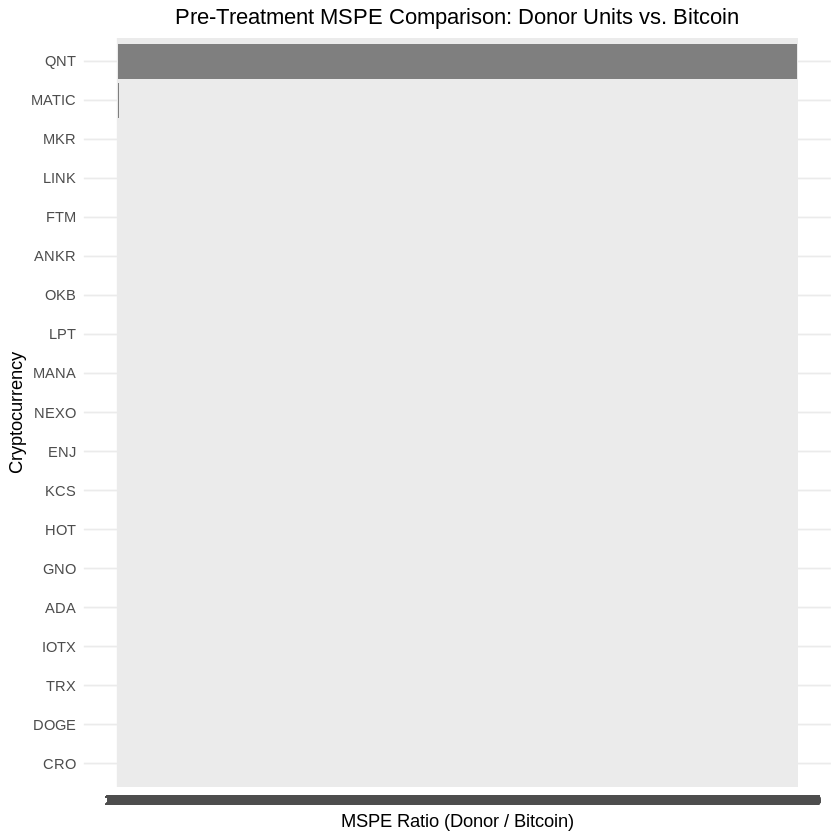

In [ ]:
# Extract Bitcoin's observed and synthetic values for the pre-treatment period
observed_btc <- dataprep.out$Y1plot[which(dataprep.out$tag$time.plot %in% time_predictors_prior)]
synthetic_btc <- (dataprep.out$Y0plot %*% synth.out$solution.w)[which(dataprep.out$tag$time.plot %in% time_predictors_prior)]

# Compute pre-treatment MSPE for Bitcoin
mspe_btc <- mean((observed_btc - synthetic_btc)^2, na.rm = TRUE)

# Extract donor MSPEs
donor_mspe <- unlist(placebo$mspe.placs)

# Extract donor cryptocurrency names
donor_cryptos <- dataprep.out$tag$controls.identifier  # Unit numbers of donor cryptocurrencies
donor_crypto_names <- dataprep.out$names.and.numbers$unit.names[
  match(donor_cryptos, dataprep.out$names.and.numbers$unit.numbers)
]

# Compute how much larger each donor unit's MSPE is relative to Bitcoin's
mspe_comparison <- data.frame(
  Crypto = donor_crypto_names,
  Pre_Treatment_MSPE = donor_mspe,
  Relative_to_BTC = donor_mspe / mspe_btc  # Compute ratio
)

# Print results
cat("Pre-Treatment MSPE for Bitcoin:", mspe_btc, "\n\n")
cat("Comparison of donor MSPEs relative to Bitcoin:\n")
print(mspe_comparison)

# Plot the comparison
ggplot(mspe_comparison, aes(x = reorder(Crypto, Relative_to_BTC), y = Relative_to_BTC)) +
  geom_bar(stat = "identity", fill = "grey50") +
  coord_flip() +
  labs(title = "Pre-Treatment MSPE Comparison: Donor Units vs. Bitcoin",
       x = "Cryptocurrency",
       y = "MSPE Ratio (Donor / Bitcoin)") +
  scale_y_continuous(breaks = seq(0, max(mspe_comparison$Relative_to_BTC), by = 25)) +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5))

# Print cryptocurrencies and count of cryptocurrencies above and below an MSPE limit
# Define threshold value
mspe_limit <- 100

# Filter cryptocurrencies based on the threshold
above_limit <- mspe_comparison %>% filter(Relative_to_BTC > mspe_limit)
below_limit <- mspe_comparison %>% filter(Relative_to_BTC <= mspe_limit)

# Count the number of cryptocurrencies in each category
count_above <- nrow(above_limit)
count_below <- nrow(below_limit)

# Print results
cat("\nCryptocurrencies with Relative_to_BTC ABOVE", mspe_limit, "(", count_above, "cryptocurrencies ):\n")
print(above_limit)

cat("\nCryptocurrencies with Relative_to_BTC BELOW or EQUAL to", mspe_limit, "(", count_below, "cryptocurrencies ):\n")
print(below_limit)

## Leave-One-Out

> **NB!** Run the main model cell before


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 393.3666 

solution.v:
 0.1373163 0.07744253 0.07492364 0.09930749 0.08895991 0.0000044297 0.1247115 0.0000022822 0.000391113 0.03975695 0.3571838 

solution.w:
 0.0000075065 0.8714296 0.0000000512 0.1285628 

Excluded: KCS, Mean Gap (56-68): -52.9696

X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 228.0122 

solution.v:
 0.004870544 0.01018714 0.1246165 0.05323115 0.1256488 0.05468843 0.1007908 0.05440957 0.09595415 0.0537897 0.3218132 

solution.w:
 0.7163282 0.171021 0.0000075316 0.1126433 

Excluded: ADA, Mean Gap (56-68): -39.0453


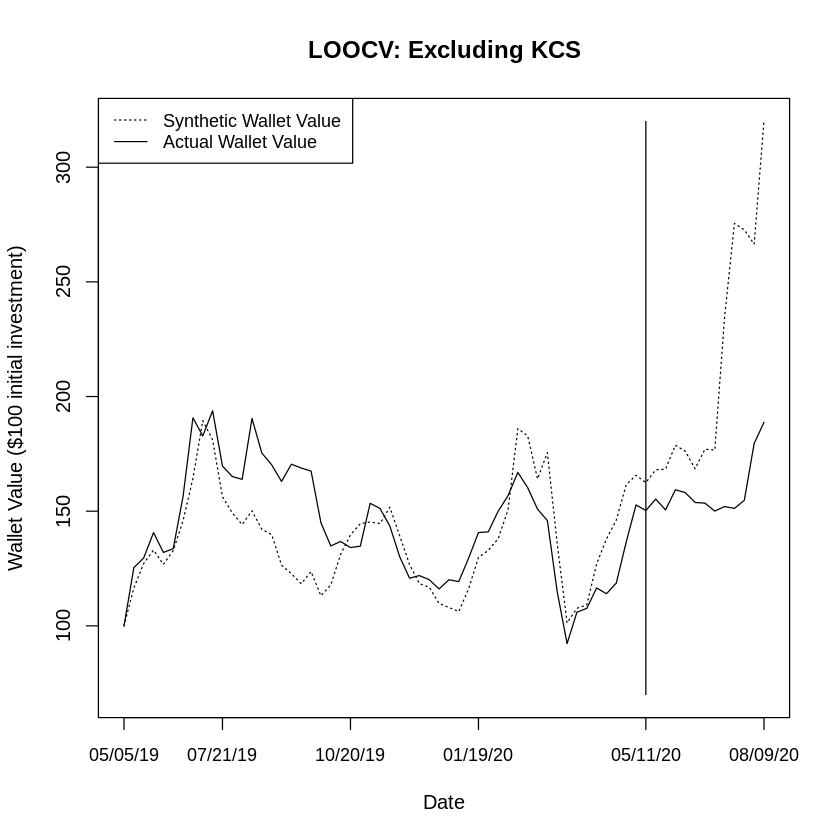


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 393.3654 

solution.v:
 0.2386311 0.002141351 0.2523961 0.07894882 0.03659403 0.03037477 0.1825108 0.05975253 0.07304299 0.0001225482 0.04548503 

solution.w:
 0.0000019491 0.8714292 0.0000000094 0.1285688 

Excluded: FTM, Mean Gap (56-68): -52.9742


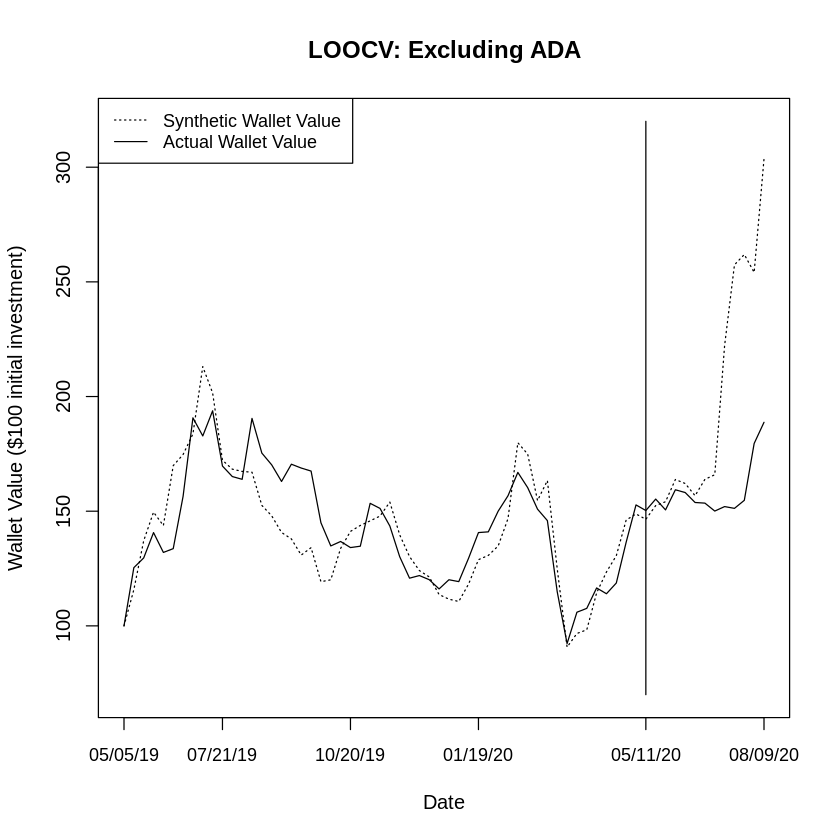


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 2277.854 

solution.v:
 0.170009 0.0000631175 0.240563 0.09957915 0.01047521 0.02450433 0.1684993 0.006474766 0.01071569 0.1109295 0.1581869 

solution.w:
 0.0001037272 0.9998313 0.000056529 0.0000084524 

Excluded: LINK, Mean Gap (56-68): 49.1011


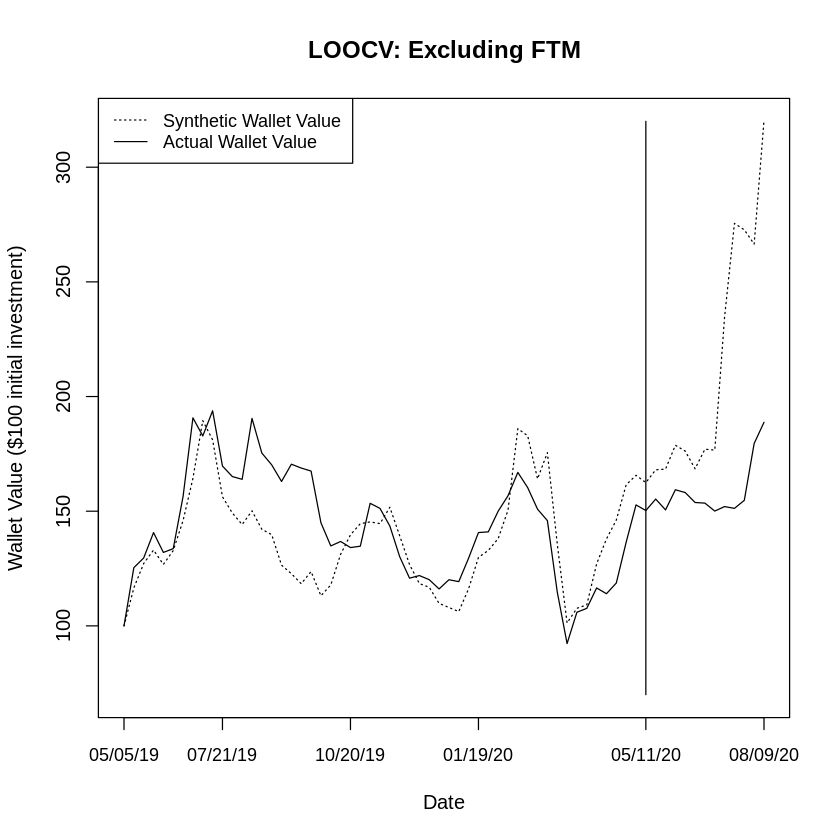


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 147.2319 

solution.v:
 0.0000013358 0.0006823252 0.01668514 0.04888925 0.6586911 0.0001532958 0.0005396414 0.0000243344 0.1324276 0.03398073 0.1079252 

solution.w:
 0.07847003 0.1097475 0.7146327 0.09714969 

Excluded: DOGE, Mean Gap (56-68): -10.5205


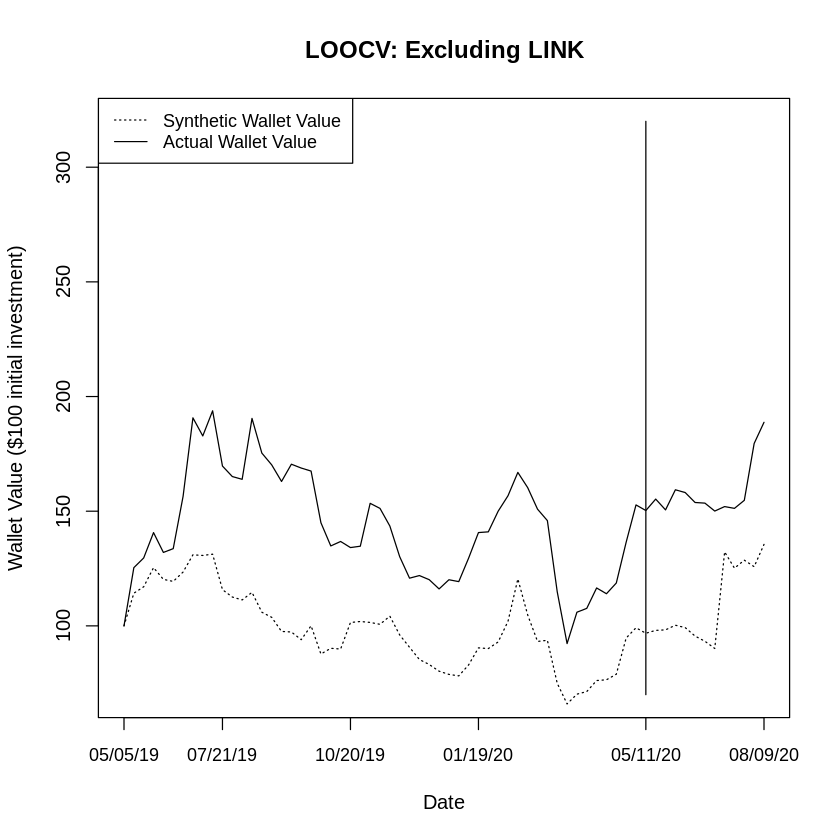

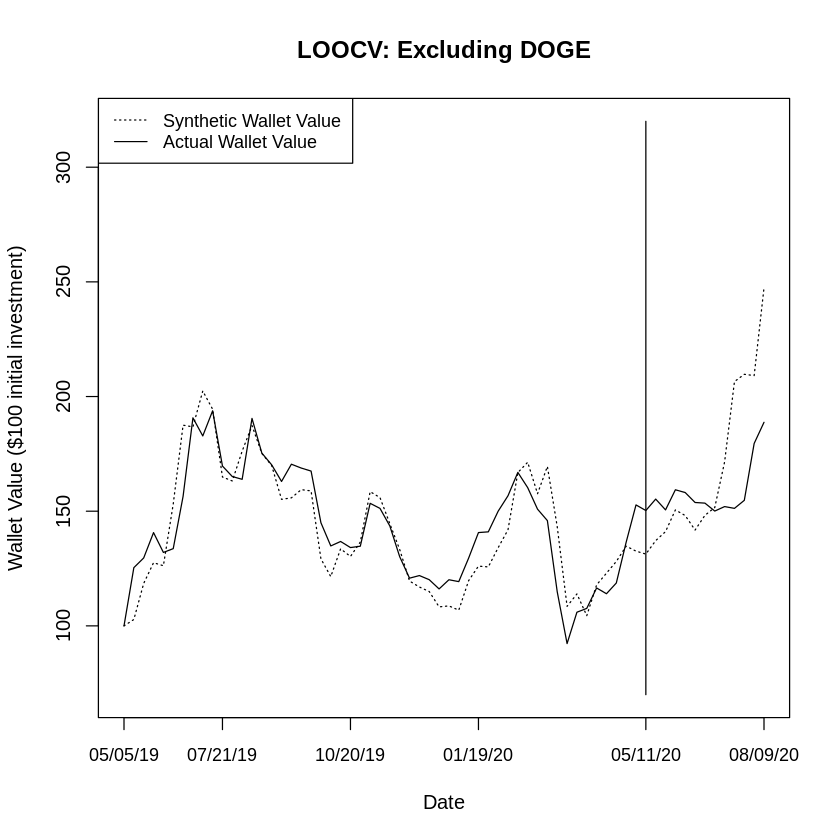

In [ ]:
# Define the selected cryptocurrencies' cryptono values
selected_cryptos <- c(15, 2, 10, 17, 6) # Only donors with weights

loocv_results <- list()

for (crypto_no in selected_cryptos) {
  # Exclude one donor cryptocurrency from the control pool
  loocv_controls <- setdiff(selected_cryptos, crypto_no)

  dp_loocv <- dataprep(
    foo = df,
    predictors         = predictors_list,
    predictors.op      = "mean",
    dependent          = "wallet_value",
    unit.variable      = "cryptono",
    time.variable      = "week_index",
    unit.names.variable = "crypto",
    treatment.identifier = 1,
    controls.identifier  = loocv_controls,
    time.predictors.prior = time_predictors_prior,
    time.optimize.ssr    = time_optimize_ssr,
    time.plot            = time_plot
  )

  synth_loocv <- synth(dp_loocv)
  # Compute the gaps (difference between actual and synthetic)
  gaps_loocv <- dp_loocv$Y1plot - (dp_loocv$Y0plot %*% synth_loocv$solution.w)
  # Compute the mean of the gaps over the period 54:66
  mean_gap <- mean(gaps_loocv[54:66])
  # Get the name of the excluded crypto
  excluded_name <- df$`crypto`[df$cryptono == crypto_no][1]
  loocv_results[[excluded_name]] <- list(dataprep = dp_loocv, synth = synth_loocv, mean_gap=mean_gap)

  # Print or log the mean gap for each iteration
  cat(sprintf("Excluded: %s, Mean Gap (54-66): %.4f\n", excluded_name, mean_gap))

  # Extract the synthetic control and actual series
  synth_2020_series <- dp_loocv$Y0plot %*% synth_loocv$solution.w
  y1_2020_series <- dp_loocv$Y1plot

  # Create a plot dataframe
  halving_date <- 1:66
  halving_plot <- data.frame(
    Date = halving_date,
    Synthetic = as.vector(synth_2020_series),
    Actual = as.vector(y1_2020_series)
  )

  # Plot LOOCV result with adjusted title
  plot(
    x = halving_date, y = halving_plot$Synthetic, type = "l", col = 'black', lty = 'dotted',
    ylab = "Wallet Value ($100 initial investment)", xlab = "Date", xaxt = 'n',ylim=c(70,320),
    main = paste("LOOCV: Excluding", excluded_name)
  )

  # Add actual values
  lines(x = halving_date, y = halving_plot$Actual, col = 'black')

  # Use segments to draw a vertical line at index 54
  y_limits <- range(c(halving_plot$Synthetic, halving_plot$Actual)) # Get y-axis limits
  segments(x0 = 54, y0 = 70, x1 = 54, y1 = 320, col = 'black', lty = 1)

  # Legend
  legend(
    'topleft',
    legend = c("Synthetic Wallet Value", "Actual Wallet Value"),
    lty = c("dotted", "solid"),
    col = c("black", "black"),
    ncol = 1,
    cex = 0.9  # Reduce legend text size
  )

  # Custom X-axis labels
  axis(
    side = 1, at = c(1, 11, 24, 37, 54, 66),
    labels = c("05/05/19", "07/21/19", "10/20/19", "01/19/20", "05/11/20", "08/09/20"),
    cex.axis = 0.9, # Reduce font size of axis labels
    las = 1         # Rotate labels 90 degrees
  )

}

# All Placebo Trials

## 2024 Unit Placebo: ADA


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 219.3683 

solution.v:
 0.1870434 0.02930637 0.09268313 0.3245338 0.006262799 0.2881959 0.005271375 0.06657682 0.0001263788 

solution.w:
 0.1778326 0.3063674 0.09151171 0.0000000494 0.0000042396 0.0000001205 0.0000001803 0.000008823 0.0000000644 0.0000001598 0.0000000508 0.0000000732 0.0000000497 0.000000092 0.007273191 0.0000001361 0.189742 0.05377363 0.0000000609 0.0000000766 0.0000000374 0.0000000961 0.1734851 

$tab.pred
                                                         Treated Synthetic
mean_active_addresses_ratio_Active                         0.010     0.009
mean_addresses_by_holdings_in_usd_X_1_00____10_00_share   21.800    14.802
log_all_time_highers                                      11.140    12.594
log_all_time_lowers                                        9.708     9.151
mean_d

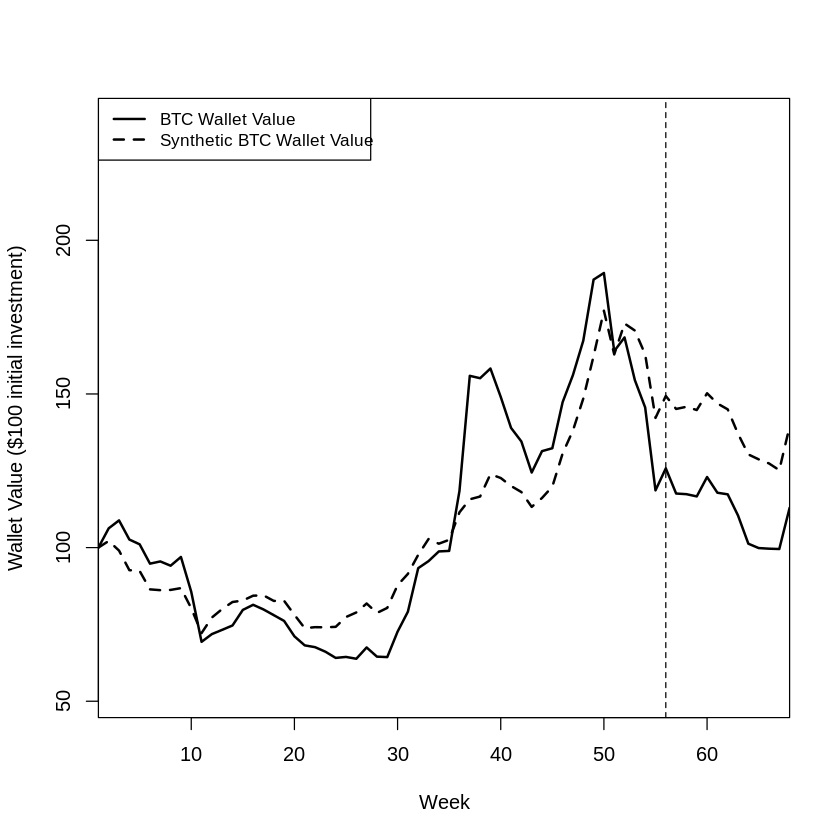

In [ ]:
# Define the time periods
time_predictors_prior <- c(1:56)
time_optimize_ssr <- time_predictors_prior
time_plot <- c(1:68)

all_controls <- c(1:26) # define the list of all control units
excluded_units <- c(6, 14, 2) # excluded due to NAs: DOGE, JET // For placebo: ADA
controls_identifier <- setdiff(all_controls, excluded_units) # create the final list of control units by excluding the specified units

# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "wallet_value",  # Use the wallet value as the dependent variable
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 2,  # Treated unit identifier: 2 (ADA)
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)
# Run synth
synth.out <- synth(dataprep.out)

# Get result tables and assess pre-treatment fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)

# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "Wallet Value ($100 initial investment)",
  Xlab = "Week",
  Legend = c("ADA Wallet Value", "Synthetic ADA Wallet Value"),
  Legend.position = "topleft"
)

abline(v   = 56,
       lty = 2)

## 2024 Unit Placebo: TRX


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 684.4575 

solution.v:
 0.4352691 0.2640816 0.1884378 0.08468828 0.0002880014 0.00639693 0.02040541 0.0000660173 0.0003668965 

solution.w:
 0.8916943 0.000000004 0.000000069 0.0000000043 0.0000000024 0.000000002 0.0000000022 0.0000000353 0.0000000041 0.0000000019 0.0000000012 0.0001374747 0.0000000015 0.0000000021 0.000000013 0.0000000011 0.0000000028 0.0000000027 0.0000000019 0.0000000078 0.0000000057 0.0000000428 0.108168 

$tab.pred
                                                         Treated Synthetic
mean_active_addresses_ratio_Active                         0.020     0.018
mean_addresses_by_holdings_in_usd_X_1_00____10_00_share   17.043    21.250
log_all_time_highers                                      12.476    12.367
log_all_time_lowers                                        9.131     9

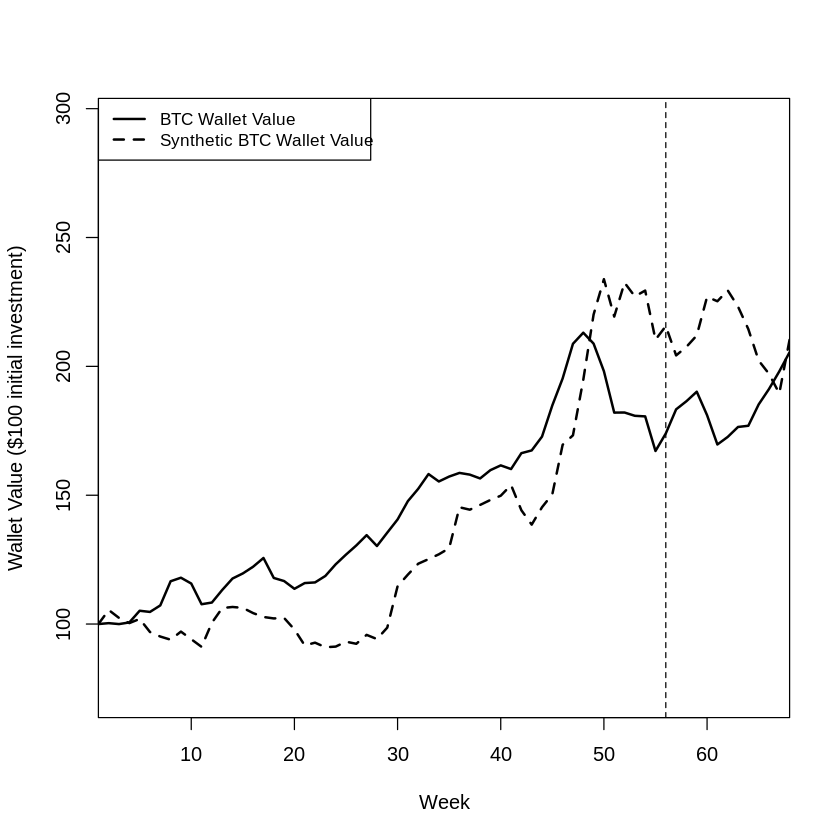

In [ ]:
# Define the time periods
time_predictors_prior <- c(1:56)
time_optimize_ssr <- time_predictors_prior
time_plot <- c(1:68)

all_controls <- c(1:25) # define the list of all control units
excluded_units <- c(6, 14) # excluded due to NAs: DOGE, JET // For placebo: TRX
controls_identifier <- setdiff(all_controls, excluded_units) # create the final list of control units by excluding the specified units

# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "wallet_value",  # Use the wallet value as the dependent variable
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 26,  # Treated unit identifier: 26 (TRX)
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)
# Run synth
synth.out <- synth(dataprep.out)

# Get result tables and assess pre-treatment fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)

# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "Wallet Value ($100 initial investment)",
  Xlab = "Week",
  Legend = c("TRX Wallet Value", "Synthetic TRX Wallet Value"),
  Legend.position = "topleft"
)

abline(v   = 56,
       lty = 2)

## 2024 Unit Placebo: MX


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 832.4865 

solution.v:
 0.2543907 0.0000173793 0.2204915 0.1219648 0.05190607 0.003867587 0.03221777 0.01158675 0.3035574 

solution.w:
 0.1731165 0.0000001251 0.0000000416 0.0000001357 0.0000000611 0.000000055 0.0000000475 0.0000009241 0.000000073 0.1726891 0.0000000929 0.0000001302 0.0000003179 0.6541431 0.000000062 0.0000000685 0.0000000572 0.0000000567 0.0000001213 0.000000036 0.0000000916 0.0000484148 0.0000004409 

$tab.pred
                                                         Treated Synthetic
mean_active_addresses_ratio_Active                         0.009     0.007
mean_addresses_by_holdings_in_usd_X_1_00____10_00_share   10.320    14.918
log_all_time_highers                                       2.819     5.103
log_all_time_lowers                                        5.097     5.270
m

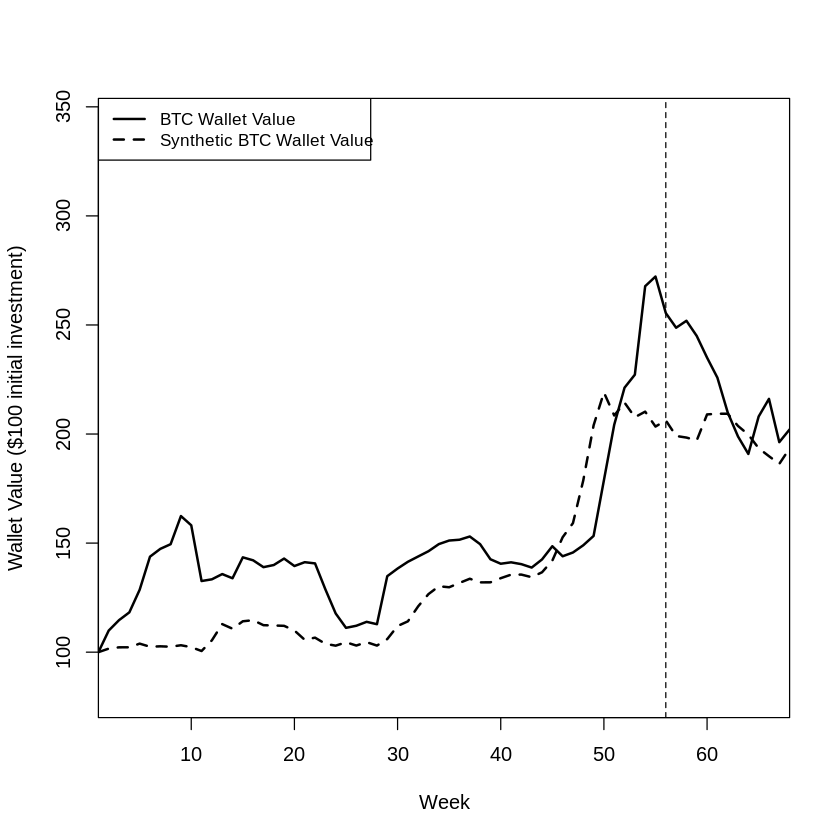

In [ ]:
# Define the time periods
time_predictors_prior <- c(1:56)
time_optimize_ssr <- time_predictors_prior
time_plot <- c(1:68)

all_controls <- c(1:26) # define the list of all control units
excluded_units <- c(6, 14, 22) # excluded due to NAs: DOGE, JET // For placebo: MX
controls_identifier <- setdiff(all_controls, excluded_units) # create the final list of control units by excluding the specified units

# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "wallet_value",  # Use the wallet value as the dependent variable
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 22,  # Treated unit identifier: 22 (MX)
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)
# Run synth
synth.out <- synth(dataprep.out)

# Get result tables and assess pre-treatment fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)

# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "Wallet Value ($100 initial investment)",
  Xlab = "Week",
  Legend = c("MX Wallet Value", "Synthetic MX Wallet Value"),
  Legend.position = "topleft"
)

abline(v   = 56,
       lty = 2)

## 2024 Unit Placebo: FET


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 21797.58 

solution.v:
 0.004378317 0.0001273429 0.01431234 0.198249 0.200588 0.2015264 0.3325795 0.0001632547 0.04807585 

solution.w:
 0.0000001878 0.0000000002 0.0000001226 0.0000001952 0.0000002849 0.0000001295 0.0000003003 0.0000001274 0.0000042316 0.0000003518 0.03382273 0.0000003672 0.0000009378 0.0000003336 0.0000000847 0.0000001993 0.0000000969 0.7363211 0.0000006944 0.0000001855 0.2298458 0.0000010418 0.0000005543 

$tab.pred
                                                         Treated Synthetic
mean_active_addresses_ratio_Active                         0.012     0.004
mean_addresses_by_holdings_in_usd_X_1_00____10_00_share   15.501    18.406
log_all_time_highers                                       6.627     7.165
log_all_time_lowers                                        3.392     4.

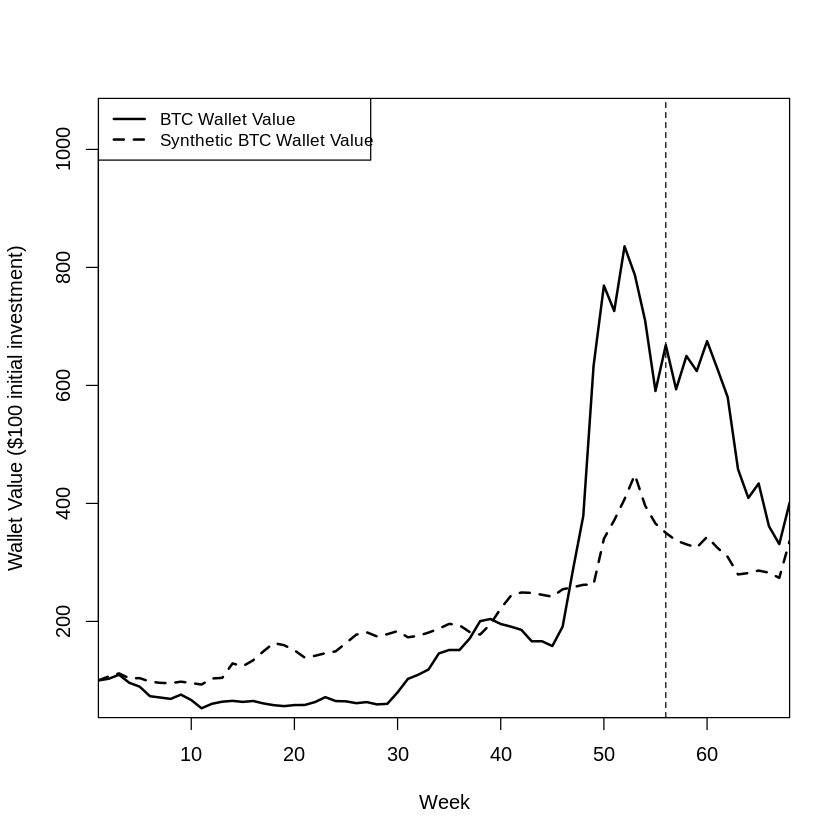

In [ ]:
# Define the time periods
time_predictors_prior <- c(1:56)
time_optimize_ssr <- time_predictors_prior
time_plot <- c(1:68)

all_controls <- c(1:26) # define the list of all control units
excluded_units <- c(6, 14, 9) # excluded due to NAs: DOGE, JET // For placebo: FET
controls_identifier <- setdiff(all_controls, excluded_units) # create the final list of control units by excluding the specified units

# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "wallet_value",  # Use the wallet value as the dependent variable
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 9,  # Treated unit identifier: 9 (FET)
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)
# Run synth
synth.out <- synth(dataprep.out)

# Get result tables and assess pre-treatment fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)

# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "Wallet Value ($100 initial investment)",
  Xlab = "Week",
  Legend = c("FET Wallet Value", "Synthetic FET Wallet Value"),
  Legend.position = "topleft"
)

abline(v   = 56,
       lty = 2)

## 2024 Unit Placebo: KCS


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 282.2106 

solution.v:
 0.2624562 0.1731259 0.01989281 0.1855125 0.06709124 0.0000000346 0.0000000738 0.189971 0.1019502 

solution.w:
 0.2046837 0.0000001986 0.0000065995 0.0000009142 0.02359057 0.0000000872 0.0000001566 0.0003779601 0.0000005913 0.000000376 0.0000003635 0.0000001879 0.0000002329 0.0000004407 0.0000000693 0.4292377 0.0000000066 0.0000001956 0.0000015224 0.1665568 0.1755403 0.0000009388 0.0000001426 

$tab.pred
                                                         Treated Synthetic
mean_active_addresses_ratio_Active                         0.005     0.006
mean_addresses_by_holdings_in_usd_X_1_00____10_00_share   14.480    14.426
log_all_time_highers                                       4.434     8.784
log_all_time_lowers                                        7.225     7.154
mean

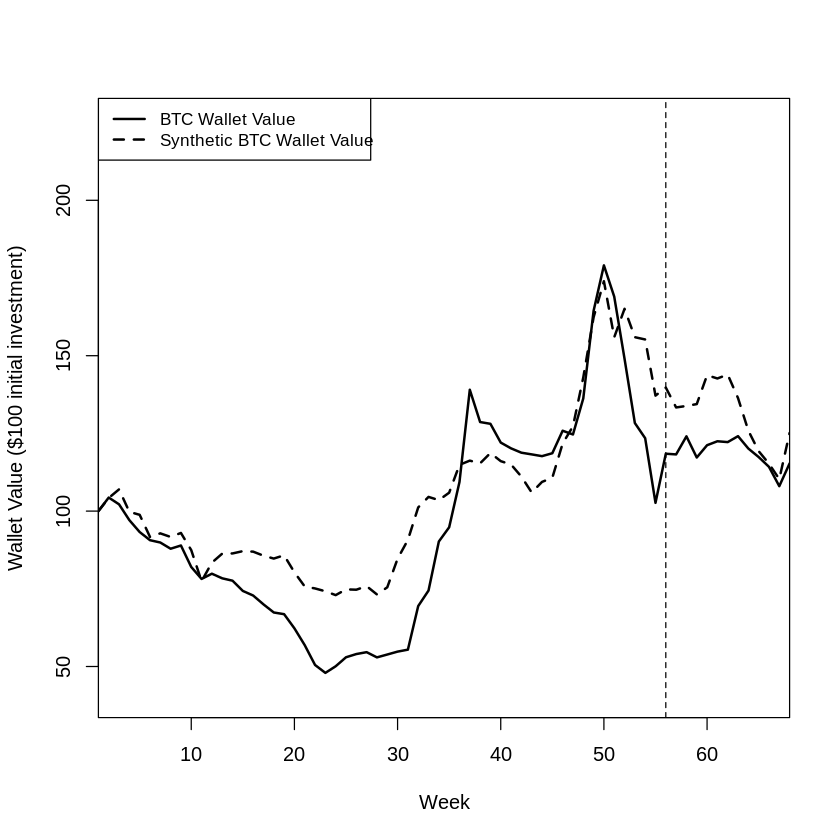

In [ ]:
# Define the time periods
time_predictors_prior <- c(1:56)
time_optimize_ssr <- time_predictors_prior
time_plot <- c(1:68)

all_controls <- c(1:26) # define the list of all control units
excluded_units <- c(6, 14, 15) # excluded due to NAs: DOGE, JET // For placebo: KCS
controls_identifier <- setdiff(all_controls, excluded_units) # create the final list of control units by excluding the specified units

# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "wallet_value",  # Use the wallet value as the dependent variable
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 15,  # Treated unit identifier: 15 (KCS)
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)
# Run synth
synth.out <- synth(dataprep.out)

# Get result tables and assess pre-treatment fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)

# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "Wallet Value ($100 initial investment)",
  Xlab = "Week",
  Legend = c("KCS Wallet Value", "Synthetic KCS Wallet Value"),
  Legend.position = "topleft"
)

abline(v   = 56,
       lty = 2)

## 2024 Unit Placebo: ALGO


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 267.8176 

solution.v:
 0.01300886 0.2532639 0.001580492 0.09009032 0.1133479 0.0940725 0.04972181 0.3849075 0.0000066984 

solution.w:
 0.0000000002 0.0000000022 0.6053709 0.0000000004 0.0000000005 0.0000000013 0.0000000001 0 0.0000000002 0.0000000004 0.0000229938 0.0000000001 0.0000000003 0.0000000004 0.000034603 0.0000000002 0.0000000001 0.0000000003 0.0000000002 0.0000000003 0.0000000001 0.3945715 0.0000000031 

$tab.pred
                                                         Treated Synthetic
mean_active_addresses_ratio_Active                         0.003     0.007
mean_addresses_by_holdings_in_usd_X_1_00____10_00_share    1.168     9.210
log_all_time_highers                                      16.680     5.130
log_all_time_lowers                                       13.346     6.978
mean_d

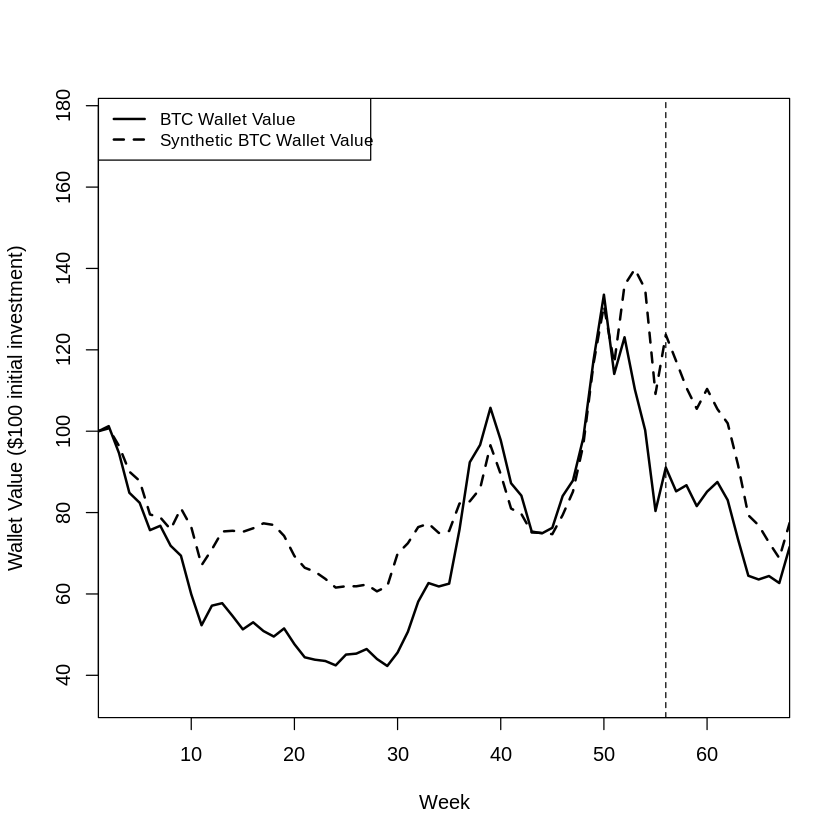

In [ ]:
# Define the time periods
time_predictors_prior <- c(1:56)
time_optimize_ssr <- time_predictors_prior
time_plot <- c(1:68)

all_controls <- c(1:26) # define the list of all control units
excluded_units <- c(6, 14, 3) # excluded due to NAs: DOGE, JET // For placebo: ALGO
controls_identifier <- setdiff(all_controls, excluded_units) # create the final list of control units by excluding the specified units

# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "wallet_value",  # Use the wallet value as the dependent variable
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 3,  # Treated unit identifier: 3 (ALGO)
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)
# Run synth
synth.out <- synth(dataprep.out)

# Get result tables and assess pre-treatment fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)

# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "Wallet Value ($100 initial investment)",
  Xlab = "Week",
  Legend = c("ALGO Wallet Value", "Synthetic ALGO Wallet Value"),
  Legend.position = "topleft"
)

abline(v   = 56,
       lty = 2)

## 2020 Unit Placebo: KCS



X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 541.2744 

solution.v:
 0.03974508 0.3969603 0.1051769 0.001117802 0.3678729 0.0000017454 0.05126535 0.000000095 0.03725978 0.0005972738 0.0000027346 

solution.w:
 0.000000066 0.0000000193 0.346769 0.0000010259 0.0000000097 0.0000004995 0.2061111 0.0000644114 0.0000000116 0.0000003569 0.0000001092 0.0000008509 0.0000008116 0.0000003765 0.0000003182 0.4470465 0.0000003652 0.0000041749 0.000000025 

$tab.pred
                                                          Treated Synthetic
mean_active_addresses_ratio_Active                          0.004     0.016
mean_new_adoption_rate_New_Adoption_Rate                    0.285     0.286
log_number_of_transactions                                  4.279     5.153
total_addresses_normalized                                  0.000     0.000
trader_balance_norm

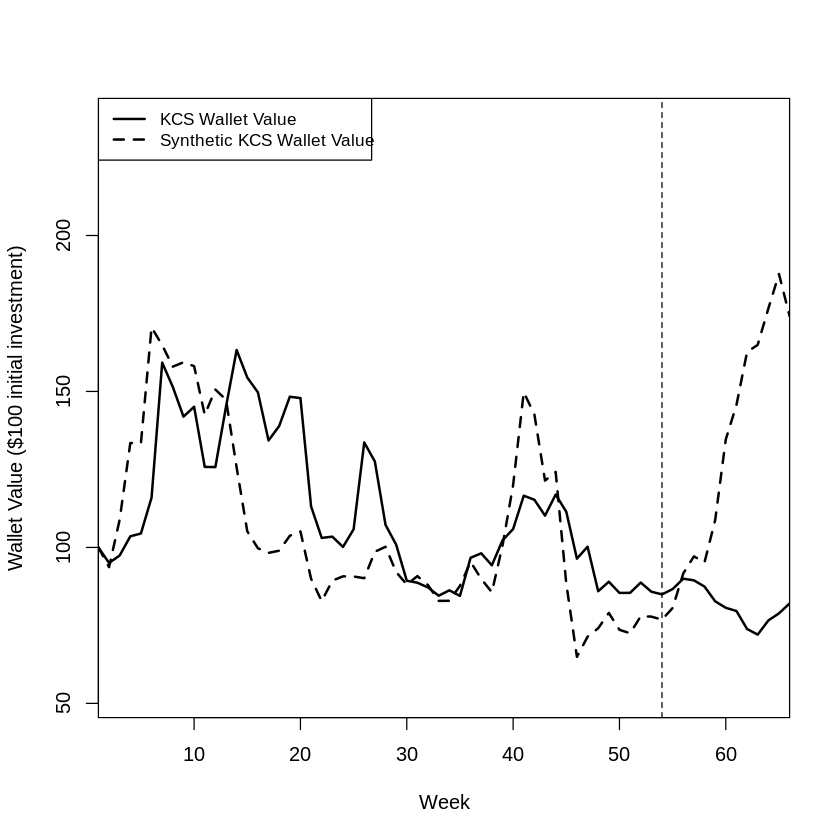

In [ ]:
# Define control units, excluding certain cryptos
all_controls <- c(1:26) # define the list of all control units
excluded_units <- c(3, 9, 14, 16, 22, 8, 15) # specify the units to exclude due to low covariate data availability: ALGO, FET, JET, MX, LEO, ETH + KCS (placebo)
controls_identifier <- setdiff(all_controls, excluded_units) # create the final list of control units by excluding the specified units

# Define the time periods
time_predictors_prior <- c(1:54)
time_optimize_ssr <- time_predictors_prior
time_plot <- c(1:66)

# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "wallet_value",  # Use the wallet value as the dependent variable
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 15,  # KCS
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)

# Run the synthetic control model
synth.out <- synth(dataprep.out)

# Get results and check fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)

# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "Wallet Value ($100 initial investment)",
  Xlab = "Week",
  Legend = c("KCS Wallet Value", "Synthetic KCS Wallet Value"),
  Legend.position = "topleft"
)

abline(v   = 54,
       lty = 2)

## 2024 Leave-One-Out: TRX


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 139.1507 

solution.v:
 0.2166715 0.0261888 0.05430007 0.1406659 0.0001456796 0.164902 0.2683145 0.02226312 0.1065484 

solution.w:
 0.4845796 0.0000000221 0.0000000086 0.0000000249 0.0000000055 0.0000012389 0.1034198 0.0000000109 0.0000000048 0.0000000055 0.0000000668 0.0000000482 0.0000000068 0.0000000119 0.000000007 0.0000000097 0.0000000074 0.0000000027 0.4119991 0.0000000089 0.0000000078 0.0000000278 

$tab.pred
                                                         Treated Synthetic
mean_active_addresses_ratio_Active                         0.019     0.010
mean_addresses_by_holdings_in_usd_X_1_00____10_00_share   23.424    16.419
log_all_time_highers                                      13.631     7.245
log_all_time_lowers                                       10.321     7.155
mean_daily_acti

$tab.pred
                                                         Treated Synthetic
mean_active_addresses_ratio_Active                         0.019     0.010
mean_addresses_by_holdings_in_usd_X_1_00____10_00_share   23.424    16.419
log_all_time_highers                                      13.631     7.245
log_all_time_lowers                                       10.321     7.155
mean_daily_active_addresses_Zero_Balance_Addresses_share   0.486     0.326
mean_balance_by_time_held_undefined_Hodlers__1Y___share    0.688     0.594
mean_balance_by_time_held_undefined_Traders___1M__share    0.078     0.103
mean_new_adoption_rate_New_Adoption_Rate                   0.484     0.333
mean_total_addresses_Total_Zero_Balance_share              0.960     0.863
                                                         Sample Mean
mean_active_addresses_ratio_Active                             0.005
mean_addresses_by_holdings_in_usd_X_1_00____10_00_share       14.247
log_all_time_highers                                           7.532
log_all_time_lowers                                            6.976
mean_daily_active_addresses_Zero_Balance_Addresses_share       0.277
mean_balance_by_time_held_undefined_Hodlers__1Y___share        0.609
mean_balance_by_time_held_undefined_Traders___1M__share        0.064
mean_new_adoption_rate_New_Adoption_Rate                       0.312
mean_total_addresses_Total_Zero_Balance_share                  0.621

$tab.v
                                                         v.weights
mean_active_addresses_ratio_Active                       0.217    
mean_addresses_by_holdings_in_usd_X_1_00____10_00_share  0.026    
log_all_time_highers                                     0.054    
log_all_time_lowers                                      0.141    
mean_daily_active_addresses_Zero_Balance_Addresses_share 0        
mean_balance_by_time_held_undefined_Hodlers__1Y___share  0.165    
mean_balance_by_time_held_undefined_Traders___1M__share  0.268    
mean_new_adoption_rate_New_Adoption_Rate                 0.022    
mean_total_addresses_Total_Zero_Balance_share            0.107    

$tab.w
   w.weights unit.names unit.numbers
2      0.485        ADA            2
3      0.000       ALGO            3
4      0.000       ANKR            4
5      0.000        CRO            5
7      0.000        ENJ            7
8      0.000        ETH            8
9      0.103        FET            9
10     0.000        FTM           10
11     0.000        GNO           11
12     0.000        HOT           12
13     0.000       IOTX           13
15     0.000        KCS           15
16     0.000        LEO           16
17     0.000       LINK           17
18     0.000        LPT           18
19     0.000       MANA           19
20     0.000      MATIC           20
21     0.000        MKR           21
22     0.412         MX           22
23     0.000       NEXO           23
24     0.000        OKB           24
25     0.000        QNT           25

[1] 29.22516

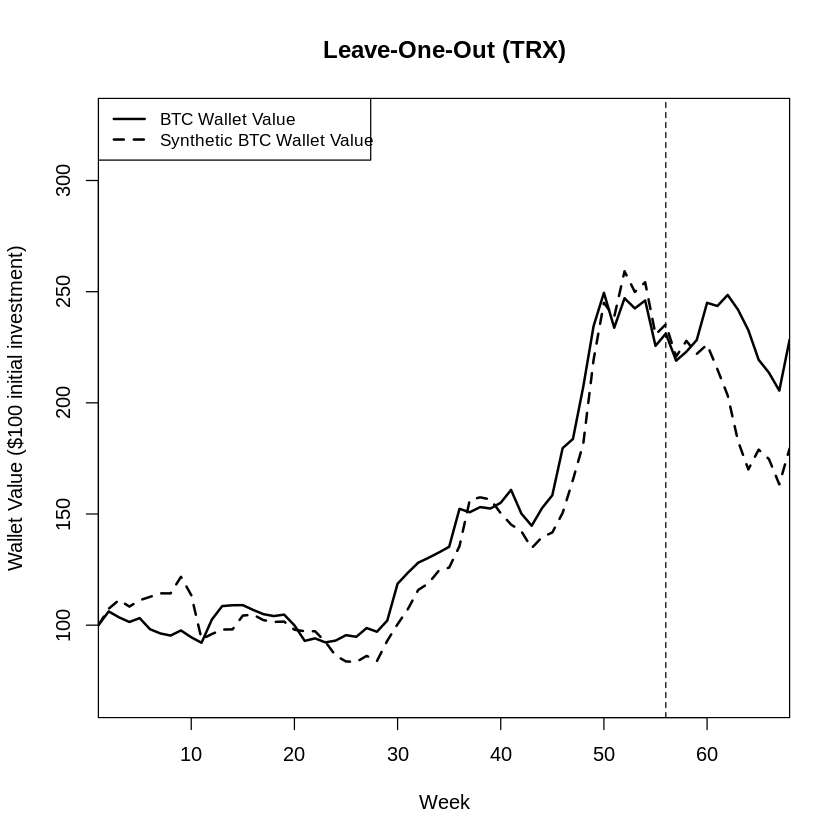

In [ ]:
all_controls <- c(2:25) # define the list of all control units, exclude TRX
excluded_units <- c(6, 14) # excluded due to NAs: DOGE, JET
controls_identifier <- setdiff(all_controls, excluded_units) # create the final list of control units by excluding the specified units

# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "wallet_value",  # Use the wallet value as the dependent variable
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 1,  # Set the treated unit identifier
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)

# Run synth
synth.out <- synth(dataprep.out)

# Get result tables and assess pre-treatment fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)

# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "Wallet Value ($100 initial investment)",
  Xlab = "Week",
  Legend = c("BTC Wallet Value", "Synthetic BTC Wallet Value"),
  Main = "Leave-One-Out (TRX)",
  Legend.position = "topleft"
)

abline(v   = 56,
       lty = 2)

# Calculate the gaps
gaps <- dataprep.out$Y1plot - (dataprep.out$Y0plot %*% synth.out$solution.w)


# Generate synthetic control tables
synth_tables <- synth.tab(dataprep.res = dataprep.out, synth.res = synth.out)
synth_tables[1:3]

# Calculate the mean of the gaps for a specific period
mean(gaps[56:68])

## 2024 Y-Variable Placebo: mean_active_addresses_ratio_Active


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 0.00001925201 

solution.v:
 0.6844617 0.009689417 0.04149069 0.06087683 0.03349255 0.09562515 0.01695704 0.003808217 0.05359839 

solution.w:
 0.2003298 0.0000006859 0.0000015095 0.0000015074 0.0000017334 0.0000024106 0.0000035745 0.0000012038 0.0000017865 0.000001483 0.0000007508 0.0000043735 0.0000029352 0.0000022443 0.0000011425 0.0000018298 0.0000013637 0.0000010285 0.04154074 0.0000020511 0.0000021384 0.000002091 0.7580916 

$tab.pred
                                                         Treated Synthetic
mean_active_addresses_ratio_Active                         0.019     0.018
mean_addresses_by_holdings_in_usd_X_1_00____10_00_share   23.424    17.717
log_all_time_highers                                      13.631    11.807
log_all_time_lowers                                       10.321  

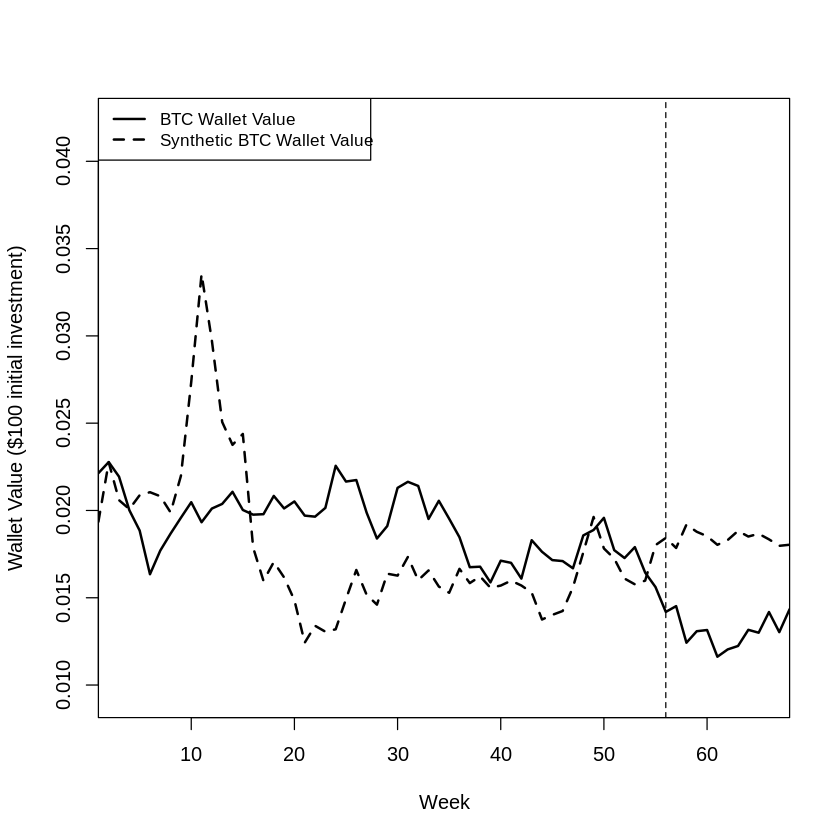

In [ ]:
# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "mean_active_addresses_ratio_Active",  # Use the wallet value as the dependent variable
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 1,  # Set the treated unit identifier
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)

# Run synth
synth.out <- synth(dataprep.out)

# Get result tables and assess pre-treatment fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)

# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "Wallet Value ($100 initial investment)",
  Xlab = "Week",
  Legend = c("BTC Wallet Value", "Synthetic BTC Wallet Value"),
  Legend.position = "topleft"
)

abline(v   = 56,
       lty = 2)

## 2024 Y-Variable Placebo: mean_new_adoption_rate_New_Adoption_Rate


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 0.004655245 

solution.v:
 0.01081051 0.007249487 0.0001479684 0.0004176128 0.1514565 0.07491724 0.0000932422 0.7431625 0.01174491 

solution.w:
 0.0000041239 0.0000000229 0.0000001049 0.0000000372 0.0000247705 0.0000000254 0.0000001441 0.0000001479 0.00000004 0.0000001334 0.0000000062 0.7866863 0.0000000618 0.0000000867 0.0000003876 0.0000004706 0.0235201 0.0000000667 0.0000001862 0.0000004358 0.1897623 0.0000000345 0.0000000188 

$tab.pred
                                                         Treated Synthetic
mean_active_addresses_ratio_Active                         0.019     0.005
mean_addresses_by_holdings_in_usd_X_1_00____10_00_share   23.424    12.285
log_all_time_highers                                      13.631     4.854
log_all_time_lowers                                       10.321 

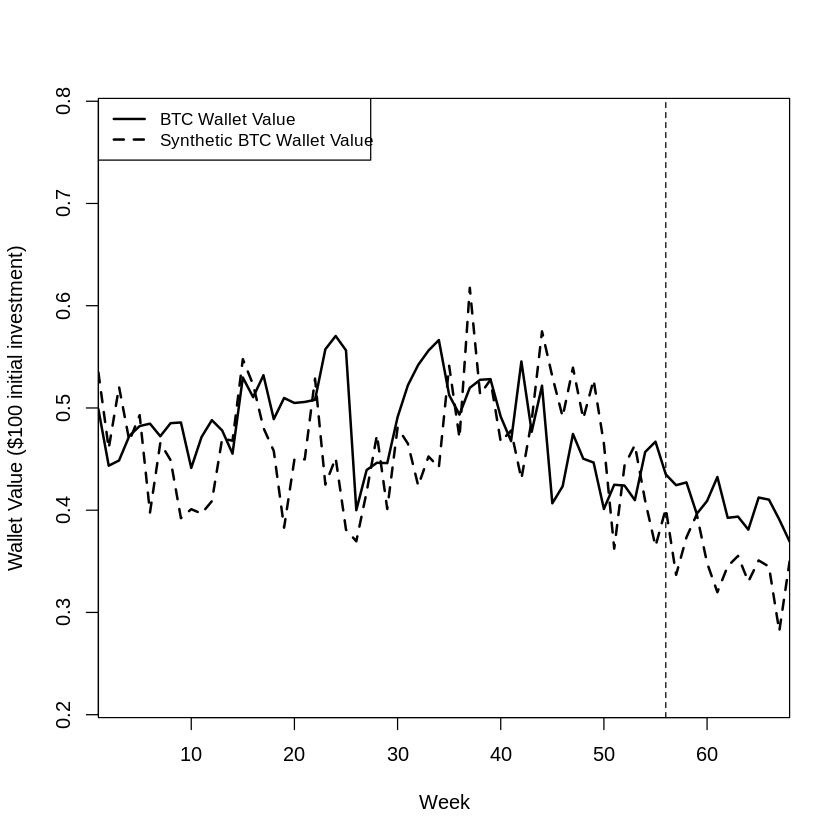

In [ ]:
# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "mean_new_adoption_rate_New_Adoption_Rate",  # Use the wallet value as the dependent variable
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 1,  # Set the treated unit identifier
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)

# Run synth
synth.out <- synth(dataprep.out)

# Get result tables and assess pre-treatment fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)

# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "Wallet Value ($100 initial investment)",
  Xlab = "Week",
  Legend = c("BTC Wallet Value", "Synthetic BTC Wallet Value"),
  Legend.position = "topleft"
)

abline(v   = 56,
       lty = 2)

## 2024 Y-Variable Placebo: mean_balance_by_time_held_undefined_Traders___1M__share


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 0.000105272 

solution.v:
 0.004974944 0.1136056 0.07708056 0.0004429537 0.1165652 0.05257186 0.602523 0.02659406 0.005641841 

solution.w:
 0.2029308 0.0000000026 0.0000000045 0.0000000684 0.000000018 0.0000000453 0.0000000048 0.0000000064 0.0000000061 0.0000000112 0.0000000026 0.0000000143 0.0000000125 0.0000000083 0.01012575 0.5214585 0.1994054 0.0000000028 0.0000000153 0.0000000183 0.06607931 0.0000000038 0.0000000057 

$tab.pred
                                                         Treated Synthetic
mean_active_addresses_ratio_Active                         0.019     0.005
mean_addresses_by_holdings_in_usd_X_1_00____10_00_share   23.424    19.021
log_all_time_highers                                      13.631     8.992
log_all_time_lowers                                       10.321     6.42

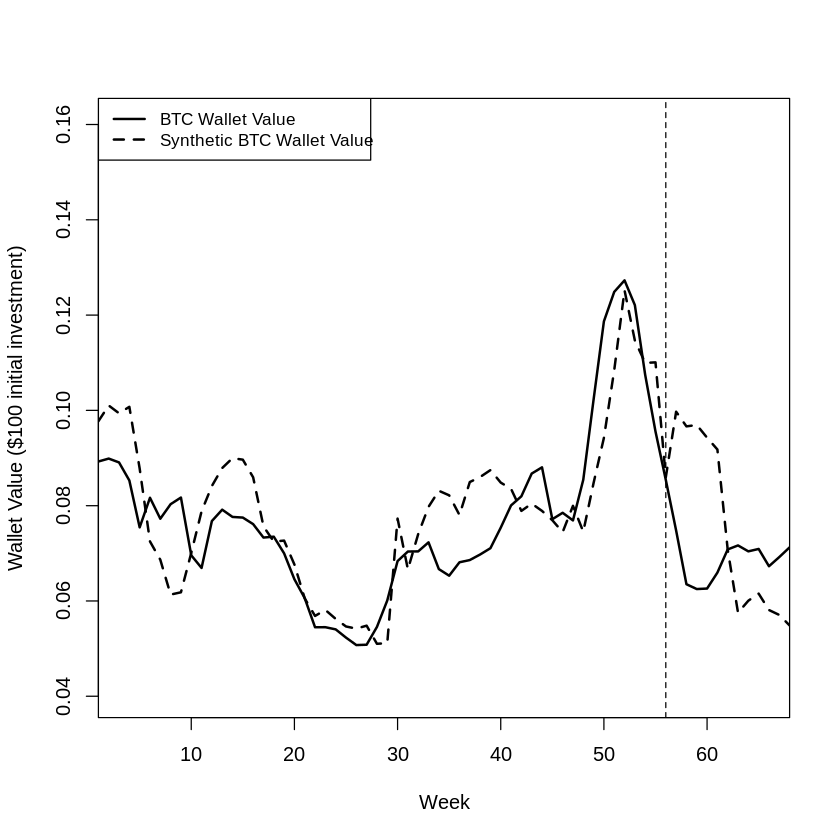

In [ ]:
# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "mean_balance_by_time_held_undefined_Traders___1M__share",  # Use the wallet value as the dependent variable
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 1,  # Set the treated unit identifier
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)

# Run synth
synth.out <- synth(dataprep.out)

# Get result tables and assess pre-treatment fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)

# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "Wallet Value ($100 initial investment)",
  Xlab = "Week",
  Legend = c("BTC Wallet Value", "Synthetic BTC Wallet Value"),
  Legend.position = "topleft"
)

abline(v   = 56,
       lty = 2)

## 2024 Y-Variable Placebo: mean_balance_by_time_held_undefined_Hodlers__1Y___share


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 0.000532689 

solution.v:
 0.09487416 0.0000014958 0.0000010507 0.0000017307 0.08148911 0.6495125 0.01752229 0.1287057 0.0278919 

solution.w:
 0.0266461 0.0000006574 0.0000017009 0.0000004652 0.0000056065 0.0000004152 0.5589497 0.0000021048 0.0000004885 0.0000013257 0.0000002395 0.1310271 0.0000003787 0.0000013394 0.0000013242 0.0000035866 0.0000068356 0.0000010175 0.2833462 0.0000030193 0.0000000039 0.0000003718 -0.0000000003 

$tab.pred
                                                         Treated Synthetic
mean_active_addresses_ratio_Active                         0.019     0.010
mean_addresses_by_holdings_in_usd_X_1_00____10_00_share   23.424    14.067
log_all_time_highers                                      13.631     5.381
log_all_time_lowers                                       10.321   

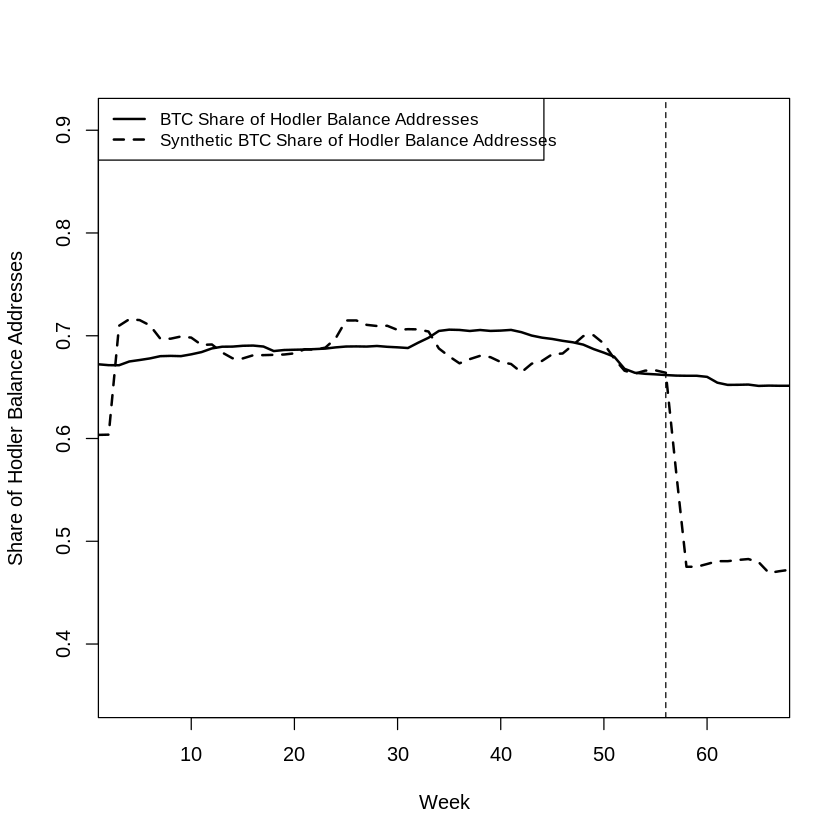

In [ ]:
# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "mean_balance_by_time_held_undefined_Hodlers__1Y___share",  # Use the wallet value as the dependent variable
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 1,  # Set the treated unit identifier
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)

# Run synth
synth.out <- synth(dataprep.out)

# Get result tables and assess pre-treatment fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)

# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "Share of Hodler Balance Addresses",
  Xlab = "Week",
  Legend = c("BTC Share of Hodler Balance Addresses", "Synthetic BTC Share of Hodler Balance Addresses"),
  Legend.position = "topleft"
)

abline(v   = 56,
       lty = 2)

## 2024 Y-Variable Placebo: mean_daily_active_addresses_Zero_Balance_Addresses_share


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 0.01856569 

solution.v:
 0.004834954 0.07009656 0.08916816 0.07942645 0.5869023 0.04423936 0.04209464 0.03219687 0.05104066 

solution.w:
 0.3328641 0.0000000007 0.0000000017 0.0000000033 0.1697272 0.0000000019 0.0000000015 0.0000000022 0.0000000015 0.0000000036 0.0000000003 0.0000000061 0.0000000037 0.0000000024 0.3357685 0.0000000076 0.000000001 0.0000000014 0.0000000101 0.0000000399 0.1616402 0.000000001 0.000000001 

$tab.pred
                                                         Treated Synthetic
mean_active_addresses_ratio_Active                         0.019     0.004
mean_addresses_by_holdings_in_usd_X_1_00____10_00_share   23.424    15.555
log_all_time_highers                                      13.631     8.062
log_all_time_lowers                                       10.321    10.185


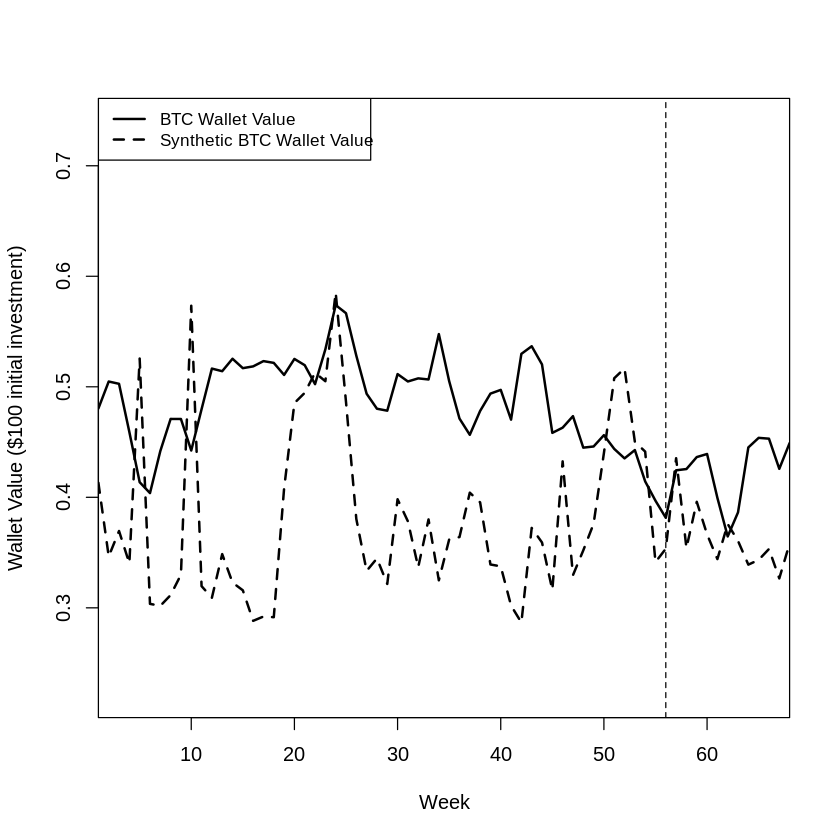

In [ ]:
# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "mean_daily_active_addresses_Zero_Balance_Addresses_share",  # Use the wallet value as the dependent variable
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 1,  # Set the treated unit identifier
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)

# Run synth
synth.out <- synth(dataprep.out)

# Get result tables and assess pre-treatment fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)

# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "Wallet Value ($100 initial investment)",
  Xlab = "Week",
  Legend = c("BTC Wallet Value", "Synthetic BTC Wallet Value"),
  Legend.position = "topleft"
)

abline(v   = 56,
       lty = 2)

## 2024 Y-Variable Placebo: log_all_time_lowers



X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 0.00003847585 

solution.v:
 0.004049838 0.03078366 0.01411316 0.8761673 0.05274684 0.001722604 0.002113802 0.005510267 0.01279249 

solution.w:
 0.8725985 0.0000000001 0.0000000236 0.0000000374 0.0001183632 0 0.0000001962 0.0000000808 0.0000000789 0.0000002819 0.0000000029 0.0000019869 0.0000007911 0.000000104 0.1264009 0.0000046403 0.0000137113 0.0000000291 0.0000278143 0.0000108736 0.0008215614 0.0000000228 0.0000000008 

$tab.pred
                                                         Treated Synthetic
mean_active_addresses_ratio_Active                         0.019     0.009
mean_addresses_by_holdings_in_usd_X_1_00____10_00_share   23.424    20.909
log_all_time_highers                                      13.631    10.545
log_all_time_lowers                                       10.321    10.3

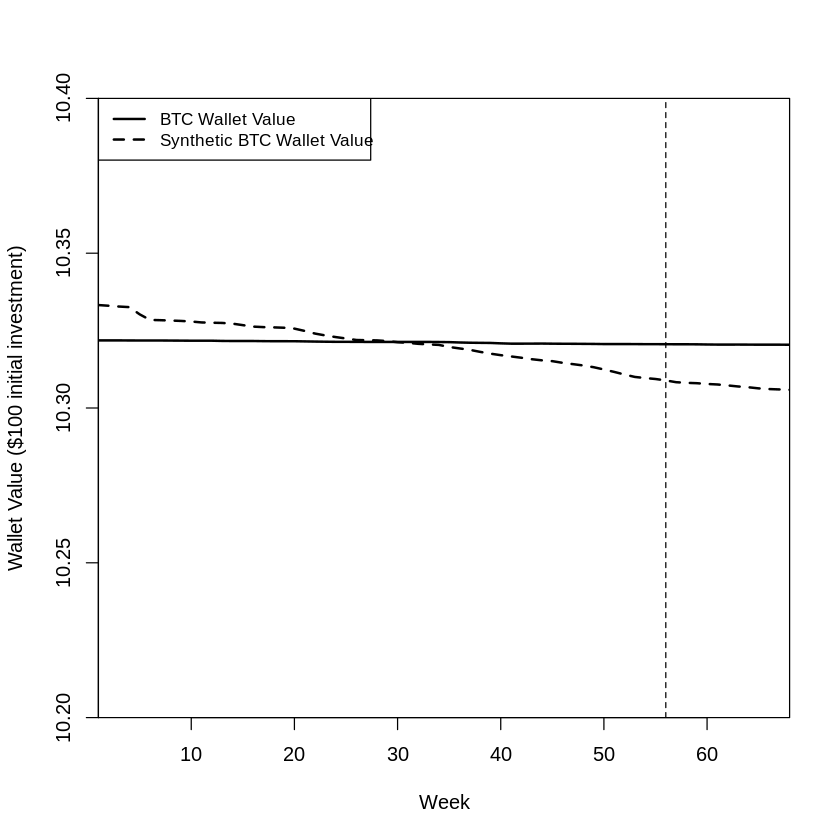

In [ ]:
# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "log_all_time_lowers",  # Use the wallet value as the dependent variable
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 1,  # Set the treated unit identifier
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)

# Run synth
synth.out <- synth(dataprep.out)

# Get result tables and assess pre-treatment fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)

# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "Wallet Value ($100 initial investment)",
  Xlab = "Week",
  Legend = c("BTC Wallet Value", "Synthetic BTC Wallet Value"),
  Legend.position = "topleft",
  Ylim=c(10.2,10.4)
)

abline(v   = 56,
       lty = 2)

## 2024 Y-Variable Placebo: log_all_time_highers



X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 0.1504763 

solution.v:
 0.001172481 0.02191466 0.9533539 0.01131469 0.0002332533 0.009143381 0.0003015683 0.002564482 0.0000016061 

solution.w:
 0.000136659 0.1223704 0.0000010953 0.0000083614 0.000001351 0.7011849 0.1762598 0.0000012443 0.0000004579 0.0000009403 0.0000003845 0.0000220959 0.0000005187 0.0000010746 0.0000010059 0.000003979 0.0000015754 0.0000006518 0.0000007827 0.0000015781 0.0000006599 0.0000004468 0.0000000043 

$tab.pred
                                                         Treated Synthetic
mean_active_addresses_ratio_Active                         0.019     0.006
mean_addresses_by_holdings_in_usd_X_1_00____10_00_share   23.424    23.117
log_all_time_highers                                      13.631    13.598
log_all_time_lowers                                       10.321 

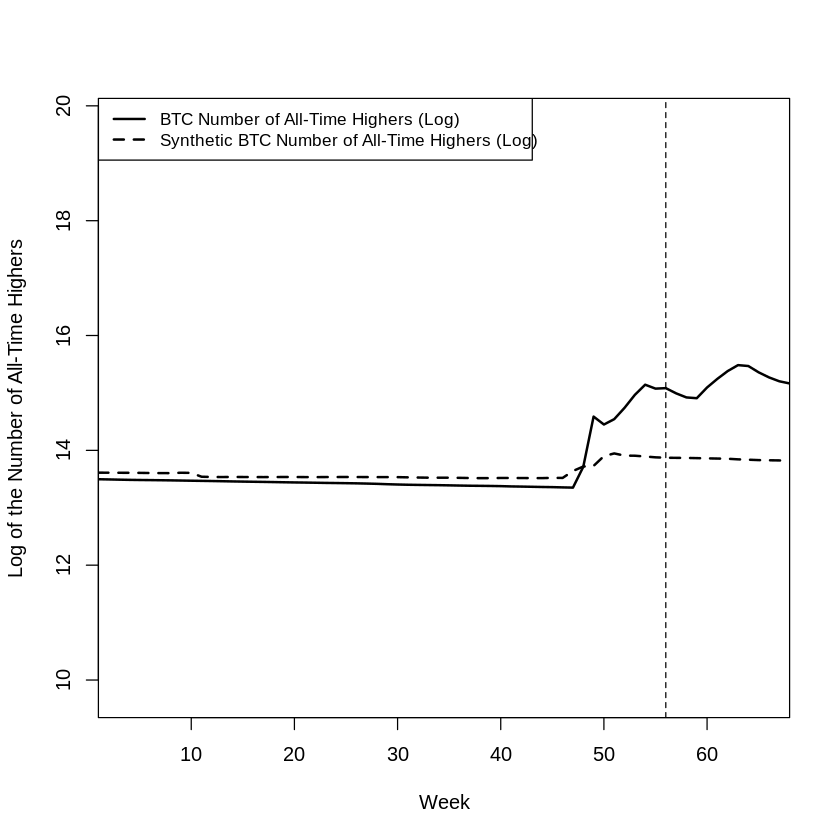

In [ ]:
# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "log_all_time_highers",  # Use the wallet value as the dependent variable
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 1,  # Set the treated unit identifier
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)

# Run synth
synth.out <- synth(dataprep.out)

# Get result tables and assess pre-treatment fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)

# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "Log of the Number of All-Time Highers",
  Xlab = "Week",
  Legend = c("BTC Number of All-Time Highers (Log)", "Synthetic BTC Number of All-Time Highers (Log)"),
  Legend.position = "topleft"
)

abline(v   = 56,
       lty = 2)

In [ ]:
# Extract the synthetic control and actual series
synth_2024_var_placebo_series <- dataprep.out$Y0plot %*% synth.out$solution.w
y1_2024_var_placebo_series <- dataprep.out$Y1plot

# Create a plot dataframe
halving_date <- 1:68
halving_plot <- data.frame(
  Date = halving_date,
  Synthetic = as.vector(synth_2024_series),
  Actual = as.vector(y1_2024_series)
)

# Plot results
plot(
  x = halving_date, y = halving_plot$Synthetic, type = "l", col = 'black', lty = 'dotted',
  ylab = "Log of the Number of All-Time Highers ($100 initial investment)", xlab = "Date", xaxt = 'n'
)
lines(x = halving_date, y = halving_plot$Actual, col = 'black')
title(main = "Log of the Number of All-Time Highers: BTC vs Synthetic BTC")
#abline(v = c(56), col = c('black'))

# Use segments to draw vertical lines
y_limits <- range(c(halving_plot$Synthetic, halving_plot$Actual)) # Get y-axis limits
segments(x0 = 56, y0 = y_limits[1], x1 = 56, y1 = y_limits[2], col = 'black', lty = 1)

# Legend
legend(
  'topleft',
  legend = c("Synthetic BTC Wallet Value", "BTC Wallet Value"),
  lty = c("dotted", "solid"),
  col = c("black", "black"),
  ncol = 1,
  cex = 0.9       # Reduce legend text size
)

axis(
  side = 1, at = c(1, 13, 26, 39, 56, 68),
  labels = c("04/02/23", "07/02/23", "10/2/23", "01/02/24", "04/21/24","07/21/24"),
  cex.axis = 0.9, # Reduce font size of axis labels
  las = 1         # Rotate labels 90 degrees
)


## 2024 Y-Variable Placebo: mean_addresses_by_holdings_in_usd_X_1_00____10_00_share



X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 1.75501 

solution.v:
 0.02470388 0.08705869 0.2293847 0.05141837 0.02179822 0.1812188 0.2813428 0.0407895 0.08228504 

solution.w:
 0.2846046 0.0000000767 0.0000013431 0.0000053387 0.0000009961 0.4712975 0.0000005406 0.0000061009 0.0000011346 0.0000001349 0.0000006033 0.2266792 0.0000016237 0.0001193026 0.0000000187 0.0000180803 0.0000512997 0.0000002012 0.01706311 0.0000447686 0.0000015496 0.0000005177 0.0001019701 

$tab.pred
                                                         Treated Synthetic
mean_active_addresses_ratio_Active                         0.019     0.007
mean_addresses_by_holdings_in_usd_X_1_00____10_00_share   23.424    23.271
log_all_time_highers                                      13.631    11.209
log_all_time_lowers                                       10.321    10.319
mea

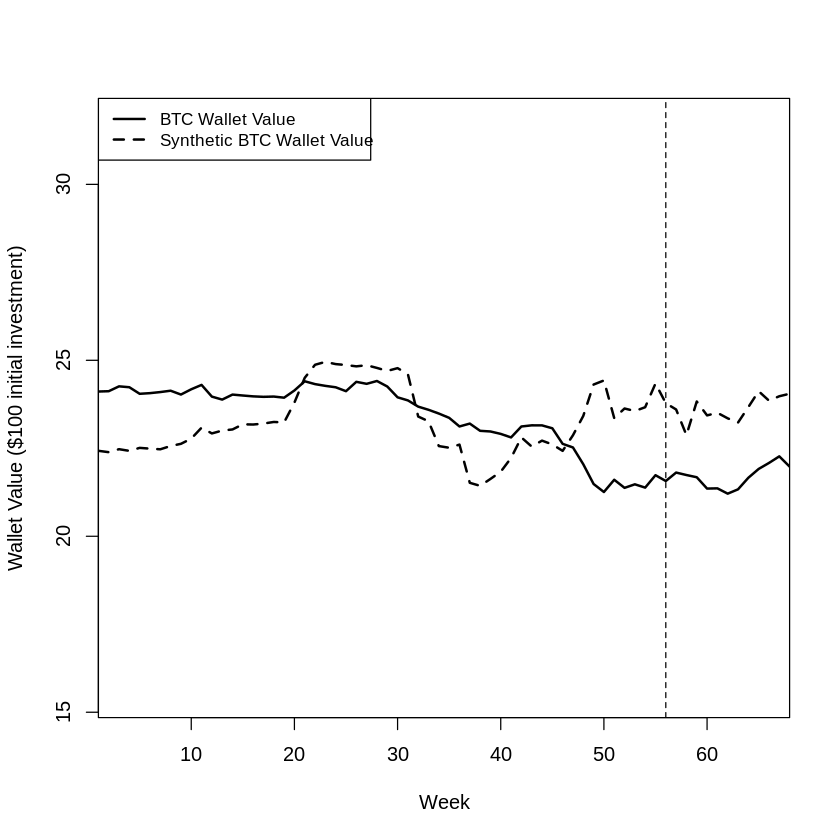

In [ ]:
# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "mean_addresses_by_holdings_in_usd_X_1_00____10_00_share",  # Use the wallet value as the dependent variable
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 1,  # Set the treated unit identifier
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)

# Run synth
synth.out <- synth(dataprep.out)

# Get result tables and assess pre-treatment fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)

# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "Wallet Value ($100 initial investment)",
  Xlab = "Week",
  Legend = c("BTC Wallet Value", "Synthetic BTC Wallet Value"),
  Legend.position = "topleft"
)

abline(v   = 56,
       lty = 2)

## 2020 Y-Variable Placebo: mean_active_addresses_ratio_Active



X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 0.00001758258 

solution.v:
 0.4657115 0.0000017521 0.001447587 0.00455559 0.04565287 0.1332471 0.01884416 0.0005533009 0.07193505 0.258037 0.0000140612 

solution.w:
 0.0000000013 0.0000009427 0.0000000244 0.0000000023 0.3689062 0.0000000494 0.0000003814 0.0000000005 0.01790439 0.0000071257 0.2039108 0.2333476 0.0001282722 0.0000000457 0.0000019073 0.0000019729 0.0000000616 0.0000000937 0.1757902 

$tab.pred
                                                          Treated Synthetic
mean_active_addresses_ratio_Active                          0.029     0.027
mean_new_adoption_rate_New_Adoption_Rate                    0.508     0.232
log_number_of_transactions                                 12.672     7.937
total_addresses_normalized                                  0.588     0.001
trader_balance_nor

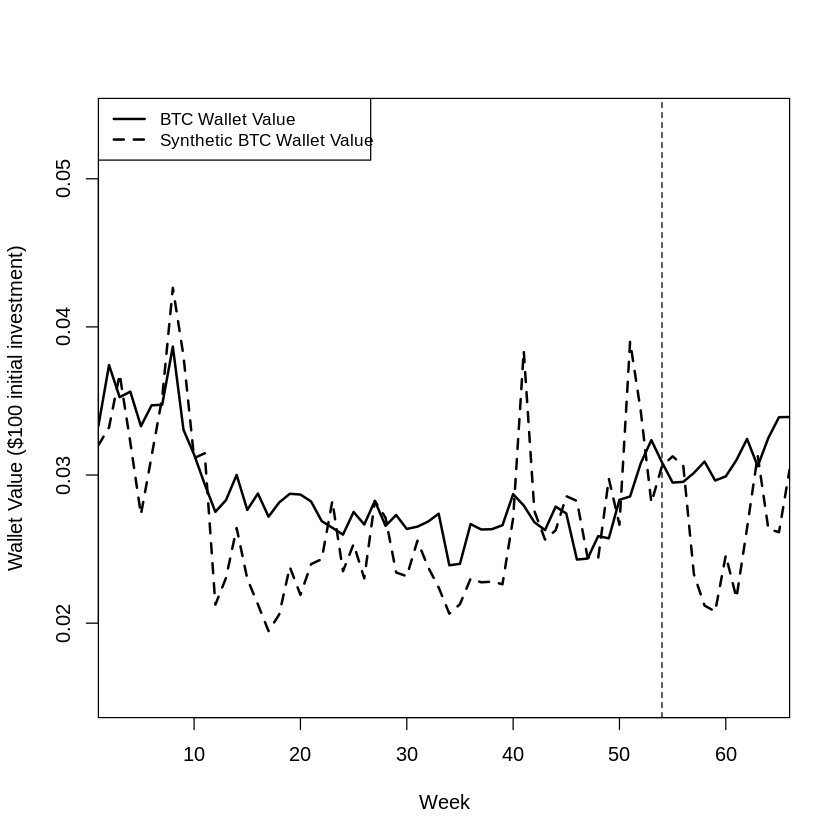

In [ ]:
# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "mean_active_addresses_ratio_Active",  # Use the wallet value as the dependent variable
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 1,  # Set the treated unit identifier
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)

# Run the synthetic control model
synth.out <- synth(dataprep.out)

# Get results and check fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)

# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "Wallet Value ($100 initial investment)",
  Xlab = "Week",
  Legend = c("BTC Wallet Value", "Synthetic BTC Wallet Value"),
  Legend.position = "topleft"
)

abline(v   = 54,
       lty = 2)

## 2020 Y-Variable Placebo: mean_new_adoption_rate_New_Adoption_Rate


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 0.0005363924 

solution.v:
 0.1107328 0.4266888 0.02048538 0.0005523397 0.007511916 0.1139698 0.0227329 0.03614411 0.04573356 0.1777077 0.03774057 

solution.w:
 0.8706021 0.0000002578 0.0000002282 0.07285304 0.000091471 0.0000003095 0.0000043471 0.0000002097 0.000952523 0.0000000983 0.000000211 0.01906816 0.0000038385 0.0000079304 0.0000004599 0.0000002224 0.0000002453 0.0000002066 0.03641415 

$tab.pred
                                                          Treated Synthetic
mean_active_addresses_ratio_Active                          0.029     0.020
mean_new_adoption_rate_New_Adoption_Rate                    0.508     0.507
log_number_of_transactions                                 12.672     8.123
total_addresses_normalized                                  0.588     0.005
trader_balance_normali

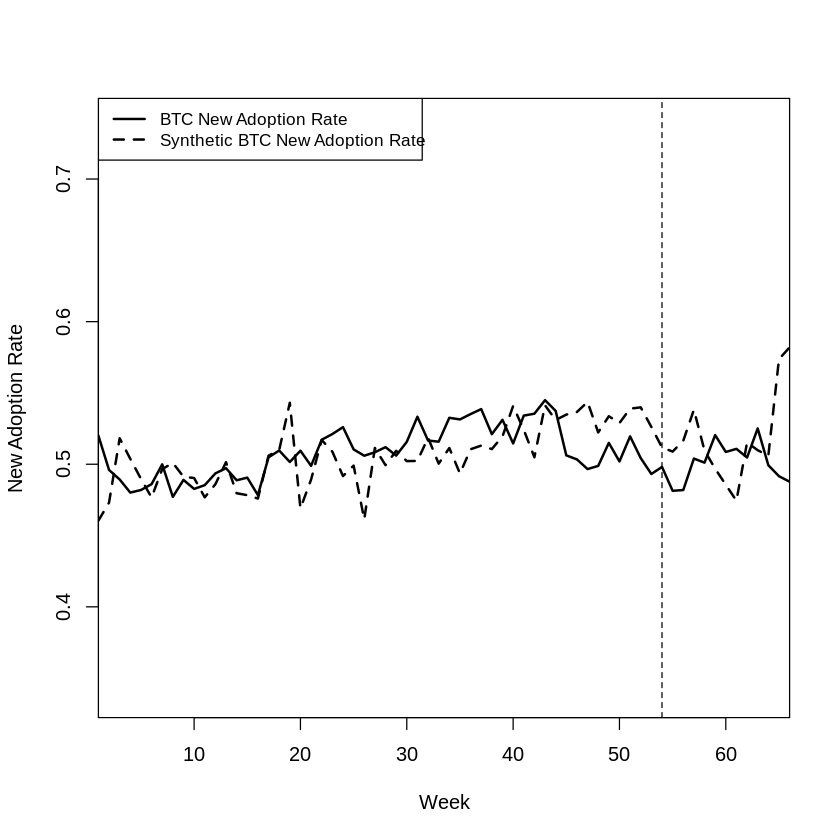

In [ ]:
# The percentage of new addresses making their first
# transaction out of all active addresses on a given day.
# This provides insight into the share that newcomers
# make out of total activity.

# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "mean_new_adoption_rate_New_Adoption_Rate",  # Use the wallet value as the dependent variable
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 1,  # Set the treated unit identifier
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)

# Run the synthetic control model
synth.out <- synth(dataprep.out)

# Get results and check fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)

# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "New Adoption Rate",
  Xlab = "Week",
  Legend = c("BTC New Adoption Rate", "Synthetic BTC New Adoption Rate"),
  Legend.position = "topleft"
)

abline(v   = 54,
       lty = 2)

## 2020 Y-Variable Placebo: log_number_of_transactions


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 0.06978774 

solution.v:
 0.04890412 0.0000116228 0.8675936 0.0003171149 0.001022532 0.0000142522 0.0005409303 0.001183415 0.01761629 0.05475064 0.008045526 

solution.w:
 0.00014616 0.0000007429 0.000000609 0.4502842 0.0000060325 0.000001748 0.0000011822 0.0000011909 0.0000002374 0.0000006399 0.0000138387 0.0000004298 0.0000023468 0.0000010297 0.0000054201 0.0000009845 0.0000094699 0.0000035755 0.5495202 

$tab.pred
                                                          Treated Synthetic
mean_active_addresses_ratio_Active                          0.029     0.043
mean_new_adoption_rate_New_Adoption_Rate                    0.508     0.224
log_number_of_transactions                                 12.672    12.627
total_addresses_normalized                                  0.588     0.022
trader_bal

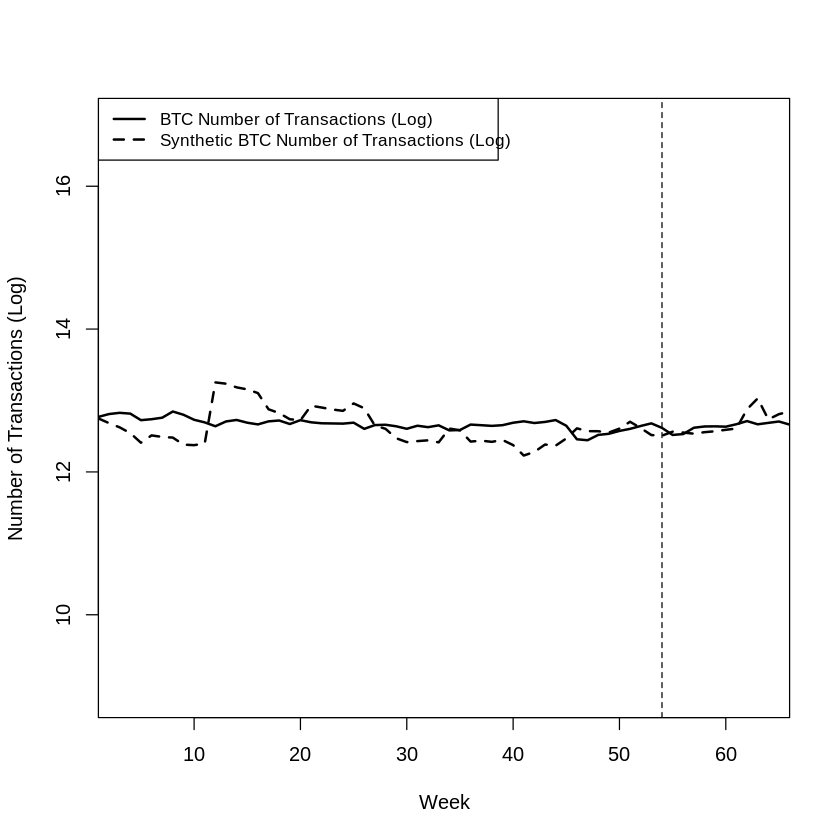

In [ ]:
# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "log_number_of_transactions",  # Use the wallet value as the dependent variable
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 1,  # Set the treated unit identifier
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)

# Run the synthetic control model
synth.out <- synth(dataprep.out)

# Get results and check fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)

# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "Number of Transactions (Log)",
  Xlab = "Week",
  Legend = c("BTC Number of Transactions (Log)", "Synthetic BTC Number of Transactions (Log)"),
  Legend.position = "topleft"
)

abline(v   = 54,
       lty = 2)

## 2020 Y-Variable Placebo: total_addresses_normalized


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 0.297038 

solution.v:
 0.01417846 0.01417849 0.01417928 0.7944099 0.01417945 0.07798108 0.01417861 0.01417893 0.01417882 0.01417853 0.01417841 

solution.w:
 0.0000000005 0.0000000002 0.0000000017 1 0.000000001 0.0000000009 0.0000000007 0.0000000004 0.0000000002 0 0.0000000009 0.0000000044 0.0000000006 0.0000000012 0.0000000009 0.0000000006 0.0000000011 0.000000001 0 

$tab.pred
                                                          Treated Synthetic
mean_active_addresses_ratio_Active                          0.029     0.023
mean_new_adoption_rate_New_Adoption_Rate                    0.508     0.416
log_number_of_transactions                                 12.672    10.321
total_addresses_normalized                                  0.588     0.045
trader_balance_normalized                       

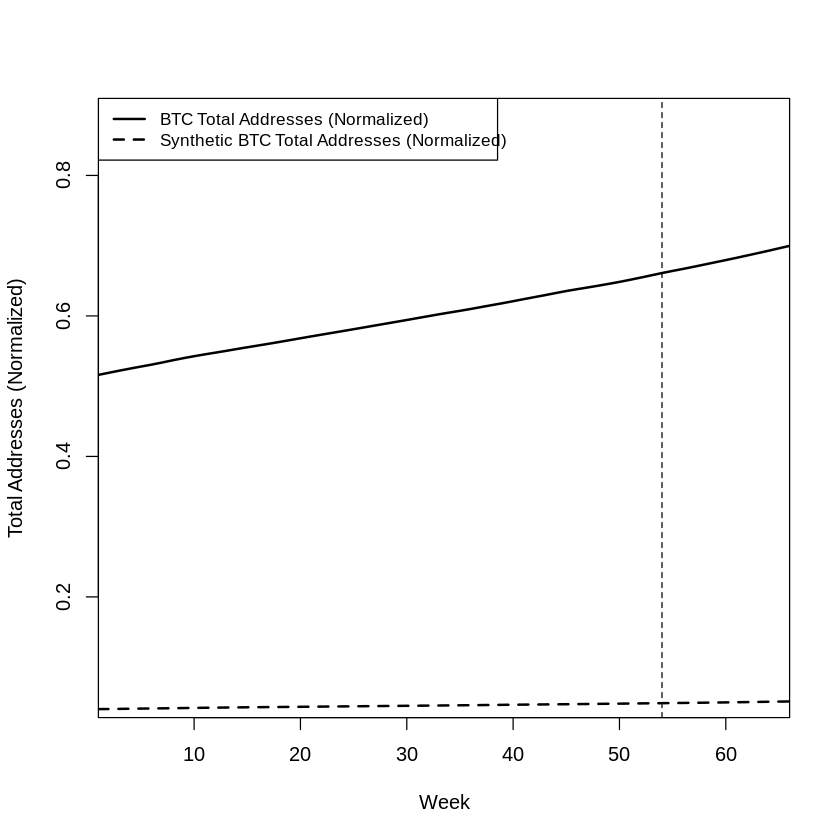

In [ ]:
# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "total_addresses_normalized",  # Use the wallet value as the dependent variable
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 1,  # Set the treated unit identifier
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)

# Run the synthetic control model
synth.out <- synth(dataprep.out)

# Get results and check fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)

# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "Total Addresses (Normalized)",
  Xlab = "Week",
  Legend = c("BTC Total Addresses (Normalized)", "Synthetic BTC Total Addresses (Normalized)"),
  Legend.position = "topleft"
)

abline(v   = 54,
       lty = 2)

## 2020 Y-Variable Placebo: trader_balance_normalized


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 0.0000008930478 

solution.v:
 0.1084061 0.0000040101 0.0000085179 0.0000877876 0.3660036 0.1131632 0.09749947 0.1094747 0.09029048 0.1063256 0.008736536 

solution.w:
 0.001690199 0.0000023633 0.0000001032 0.0002091146 0.0000012161 0.0000040247 0.5014226 0.0000228372 0.02130024 0.0000001182 0.000002819 0.001277425 0.2156353 0.0000115338 0.2583747 0.0000001972 0.0000003214 0.0000016668 0.0000432119 

$tab.pred
                                                          Treated Synthetic
mean_active_addresses_ratio_Active                          0.029     0.017
mean_new_adoption_rate_New_Adoption_Rate                    0.508     0.247
log_number_of_transactions                                 12.672     5.006
total_addresses_normalized                                  0.588     0.000
trader_balance_no

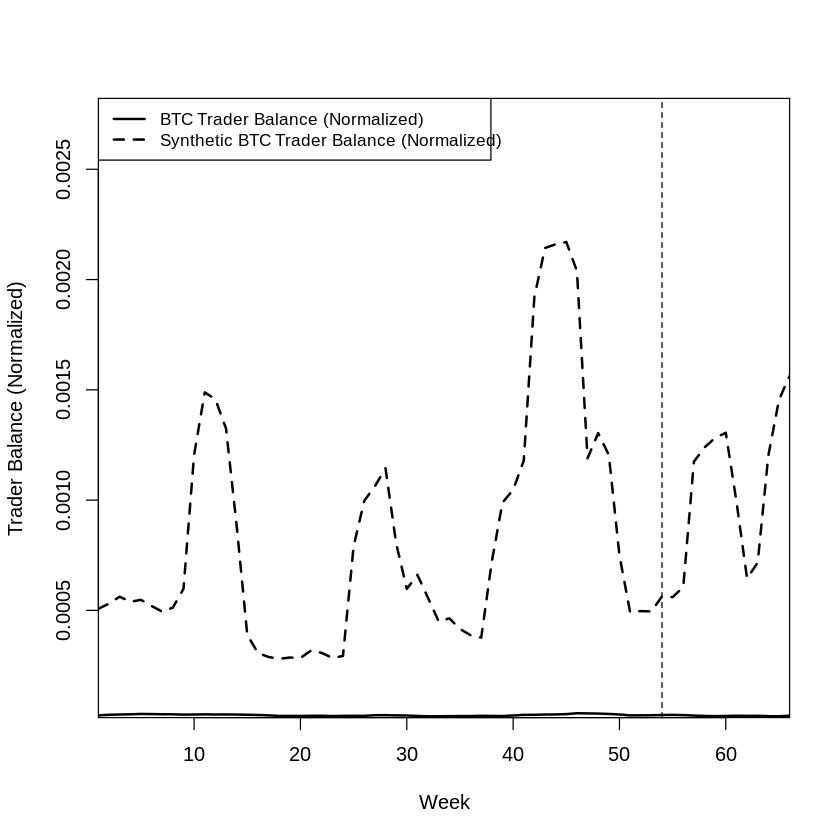

In [ ]:
# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "trader_balance_normalized",  # Use the wallet value as the dependent variable
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 1,  # Set the treated unit identifier
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)

# Run the synthetic control model
synth.out <- synth(dataprep.out)

# Get results and check fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)

# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "Trader Balance (Normalized)",
  Xlab = "Week",
  Legend = c("BTC Trader Balance (Normalized)", "Synthetic BTC Trader Balance (Normalized)"),
  Legend.position = "topleft"
)

abline(v   = 54,
       lty = 2)

## 2020 Y-Variable Placebo: mean_addresses_by_holdings_in_usd_X_0_00____1_00_share


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 2.455288 

solution.v:
 0.001437972 0.002215136 0.0006394308 0.002475916 0.005241137 0.5230554 0.001998987 0.05269898 0.08531156 0.3249235 0.000001986 

solution.w:
 0.3230673 0.0000419759 0.0000035941 0.03175011 0.0000000061 0.0000235639 0.000053949 0.000000878 0.0000642293 0.002808343 0.04391702 0.115114 0.2086218 0.0001017042 0.0000117284 0.2743645 0.0000411351 0.0000127908 0.0000013346 

$tab.pred
                                                          Treated Synthetic
mean_active_addresses_ratio_Active                          0.029     0.013
mean_new_adoption_rate_New_Adoption_Rate                    0.508     0.387
log_number_of_transactions                                 12.672     6.524
total_addresses_normalized                                  0.588     0.003
trader_balance_normalized 

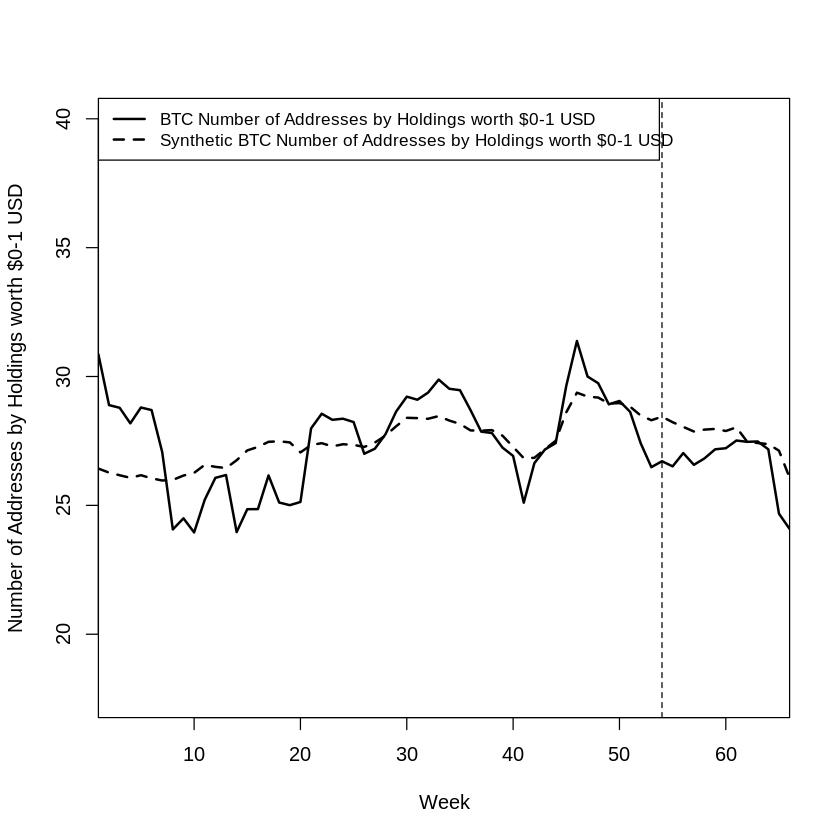

In [ ]:
# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "mean_addresses_by_holdings_in_usd_X_0_00____1_00_share",  # Use the wallet value as the dependent variable
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 1,  # Set the treated unit identifier
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)

# Run the synthetic control model
synth.out <- synth(dataprep.out)

# Get results and check fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)

# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "Number of Addresses by Holdings worth $0-1 USD",
  Xlab = "Week",
  Legend = c("BTC Number of Addresses by Holdings worth $0-1 USD", "Synthetic BTC Number of Addresses by Holdings worth $0-1 USD"),
  Legend.position = "topleft"
)

abline(v   = 54,
       lty = 2)

## 2020 Y-Variable Placebo: time_between_transactions_by_addresses


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 0.000000000001141974 

solution.v:
 0.2861991 0.04198917 0.09411012 0.009791491 0.0006604235 0.000000292 0.0009373142 0.01799088 0.03286264 0.493708 0.02175056 

solution.w:
 0.01964636 0.0000000009 0.0000000106 0.92905 0.0000000049 0.000000002 0.0000000015 0.000000005 0.0000001051 0.0000000004 0.0000000208 0.0000000042 0.0000000028 0.0000000223 0.0000000045 0.0000000028 0.0000000819 0.0000000029 0.05130333 

$tab.pred
                                                          Treated Synthetic
mean_active_addresses_ratio_Active                          0.029     0.024
mean_new_adoption_rate_New_Adoption_Rate                    0.508     0.400
log_number_of_transactions                                 12.672    10.486
total_addresses_normalized                                  0.588     0.042
trader_b

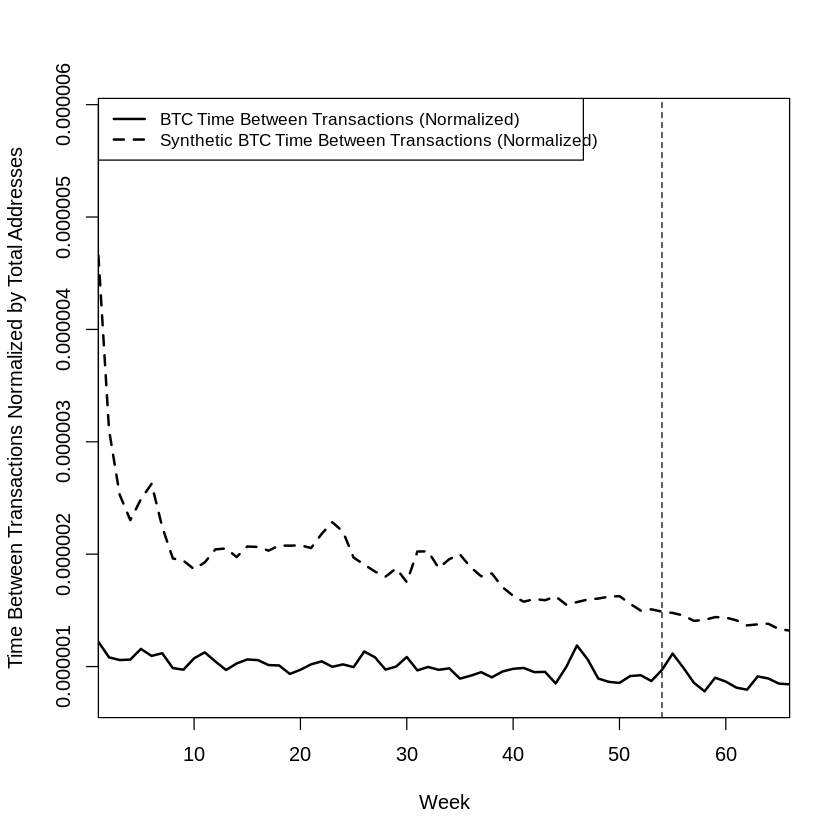

In [ ]:
# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "time_between_transactions_by_addresses",  # Use the wallet value as the dependent variable
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 1,  # Set the treated unit identifier
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)

# Run the synthetic control model
synth.out <- synth(dataprep.out)

# Get results and check fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)

# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "Time Between Transactions Normalized by Total Addresses",
  Xlab = "Week",
  Legend = c("BTC Time Between Transactions (Normalized)", "Synthetic BTC Time Between Transactions (Normalized)"),
  Legend.position = "topleft"
)

abline(v   = 54,
       lty = 2)

## 2020 Y-Variable Placebo: mean_total_addresses_Total_Zero_Balance_share


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 0.0001956078 

solution.v:
 0.1037614 0.01950956 0.00524821 0.0835617 0.0006228569 0.001983235 0.0001579487 0.0003675621 0.01430418 0.1971586 0.5733247 

solution.w:
 0.0000000002 0.0000000028 0.0000000181 0.9999998 0.0000000041 0.0000000046 0.0000000019 0.0000000087 0.0000000264 0.0000000021 0.0000000153 0.000000019 0.0000000049 0.0000000116 0.0000000077 0.0000000117 0.0000000334 0.0000000094 0.0000000118 

$tab.pred
                                                          Treated Synthetic
mean_active_addresses_ratio_Active                          0.029     0.023
mean_new_adoption_rate_New_Adoption_Rate                    0.508     0.416
log_number_of_transactions                                 12.672    10.321
total_addresses_normalized                                  0.588     0.045
trader_ba

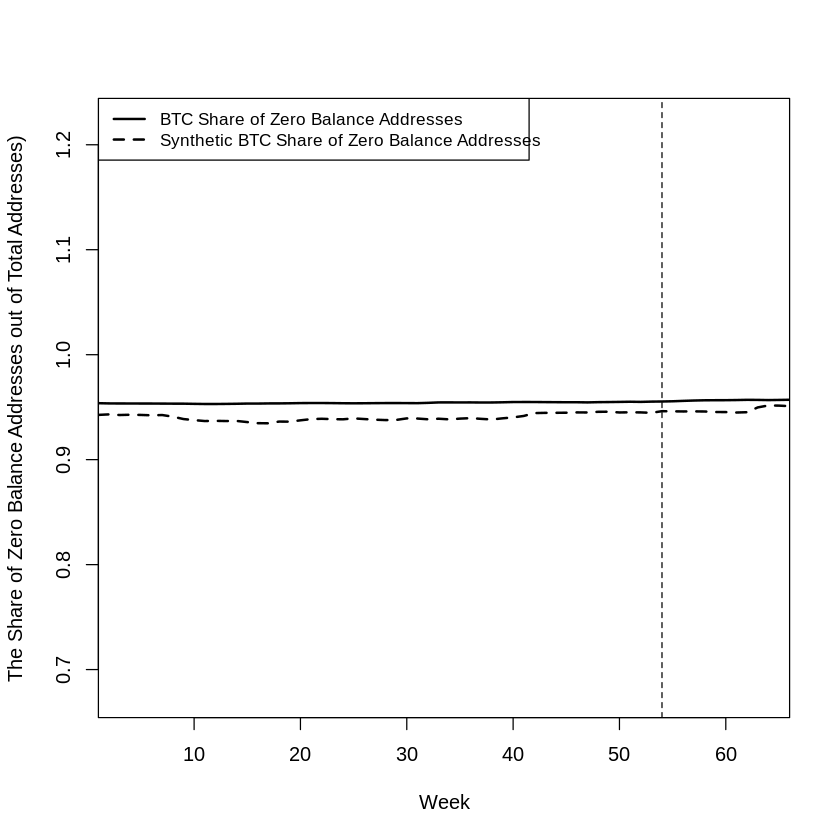

In [ ]:
# Prepare the data for Synth
dataprep.out <- dataprep(
  df,
  predictors = predictors_list,
  predictors.op = "mean",
  dependent = "mean_total_addresses_Total_Zero_Balance_share",  # Use the wallet value as the dependent variable
  unit.variable = "cryptono",
  time.variable = "week_index",
  unit.names.variable = "crypto",
  treatment.identifier = 1,  # Set the treated unit identifier
  controls.identifier = controls_identifier,
  time.predictors.prior = time_predictors_prior,
  time.optimize.ssr = time_optimize_ssr,
  time.plot = time_plot
)

# Run the synthetic control model
synth.out <- synth(dataprep.out)

# Get results and check fit
synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)
print(synth.tables)

# Plot the results
path.plot(
  synth.res = synth.out,
  dataprep.res = dataprep.out,
  Ylab = "The Share of Zero Balance Addresses out of Total Addresses)",
  Xlab = "Week",
  Legend = c("BTC Share of Zero Balance Addresses", "Synthetic BTC Share of Zero Balance Addresses"),
  Legend.position = "topleft"
)

abline(v   = 54,
       lty = 2)

# Appendix

## BTC observed price change during the study period

### 2024

In [ ]:
### From week 1 to 68

# Extract wallet values for week 1 and week 68
wallet_value_start <- df$wallet_value[df$week_index == 1 & df$cryptono == 1]
wallet_value_end <- df$wallet_value[df$week_index == 68 & df$cryptono == 1]

# Compute the absolute difference
wallet_value_diff <- wallet_value_end - wallet_value_start

# Compute the percentage change
wallet_value_pct_change <- ((wallet_value_end - wallet_value_start) / wallet_value_start) * 100

# Print results
cat(sprintf("Wallet Value Difference from week 1: %.2f\n", wallet_value_diff))
cat(sprintf("Wallet Value Percentage Change from week 1: %.2f%%\n", wallet_value_pct_change))

### From week 56 to 68
# Extract wallet values for week 1 and week 68
wallet_value_start <- df$wallet_value[df$week_index == 56 & df$cryptono == 1]
wallet_value_end <- df$wallet_value[df$week_index == 68 & df$cryptono == 1]

# Compute the absolute difference
wallet_value_diff <- wallet_value_end - wallet_value_start

# Compute the percentage change
wallet_value_pct_change <- ((wallet_value_end - wallet_value_start) / wallet_value_start) * 100

# Print results
cat(sprintf("Wallet Value Difference from week 56: %.2f\n", wallet_value_diff))
cat(sprintf("Wallet Value Percentage Change from week 56: %.2f%%\n", wallet_value_pct_change))

### Difference in Price
cat(sprintf("Price Change from week 1: %.2f\n",  df$mean_active_addresses_ratio_Price[df$week_index == 68 & df$cryptono == 1] - df$mean_active_addresses_ratio_Price[df$week_index == 1 & df$cryptono == 1]) )
# Extract price values for week_index = 1 and week_index = 68 where cryptono == 1
price_start <- df$mean_active_addresses_ratio_Price[df$week_index == 1 & df$cryptono == 1]
price_end <- df$mean_active_addresses_ratio_Price[df$week_index == 68 & df$cryptono == 1]

# Compute percentage change
price_pct_change <- ((price_end - price_start) / price_start) * 100

# Print formatted output
cat(sprintf("Price Percentage Change from week 1: %.2f%%\n", price_pct_change))


cat(sprintf("Price Change from week 56: %.2f\n",  df$mean_active_addresses_ratio_Price[df$week_index == 68 & df$cryptono == 1] - df$mean_active_addresses_ratio_Price[df$week_index == 56 & df$cryptono == 1]) )
# Extract price values for week_index = 56 and week_index = 68 where cryptono == 1
price_start <- df$mean_active_addresses_ratio_Price[df$week_index == 56 & df$cryptono == 1]
price_end <- df$mean_active_addresses_ratio_Price[df$week_index == 68 & df$cryptono == 1]

# Compute percentage change
price_pct_change <- ((price_end - price_start) / price_start) * 100

# Print formatted output
cat(sprintf("Price Percentage Change from week 56: %.2f%%\n", price_pct_change))

Wallet Value Difference from week 1: 128.41
Wallet Value Percentage Change from week 1: 128.41%
Wallet Value Difference from week 56: -2.74
Wallet Value Percentage Change from week 56: -1.19%
Price Change from week 1: 36026.35
Price Percentage Change from week 1: 128.41%
Price Change from week 56: -768.65
Price Percentage Change from week 56: -1.19%
